The [scikit learn](http://scikit-learn.org/) library contains an enormous number of data analysis and machine learning tools wrapped in a well-designed API. In this notebook, we will merely scratch the surface of all that it offers. We'll experiment with ways to use its vector embedding and point clustering tools on the SHMS dataset. Work on these tutorials has been supported in part by the Department of Energy Office of Nuclear Physics through EIC Detector R&D project eRD20.

# Initializaton

In [13]:
import uproot

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

#from lib.pdc import particle_drift_chamber as PDC
import lib.shms_helpers as shms

In [14]:
# Set Matplotlib drawing environment to enable interactive 2D/3D plots
%matplotlib notebook

In [15]:
# Open ROOT file
file = uproot.open('/volatile/hallc/comm2017/mkjones/ROOTfiles/shms_coin_replay_production_all_4019_100000.root')
tree = file['T']

# Set data key prefixes so we don't have to type them every time
h = 'P.dc.hits.'
g = 'P.dc.gtrack.'

# Data file locations
tsne2d_loc  = 'data/gtrack-tsne_embedding_2d'
tsne3d_loc = 'data/gtrack-tsne_embedding_3d'
dbscan2d_loc = 'data/gtrack-dbscan_clusterlabels_2d'
dbscan3d_loc = 'data/gtrack-dbscan_clusterlabels_3d'

# Data Processing

In [16]:
h_tracks = shms.collate(tree[h + 'plane'], tree[h + 'time'], tree[h + 'wirenum'], validate=False)
g_tracks = shms.collate(tree[g + 'plane'], tree[g + 'time'], tree[g + 'wirenum'], validate=False)

h_tracks_1 = [np.asarray([hit for hit in track if hit[0] <= 6]) for track in h_tracks]
h_tracks_2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in h_tracks]

g_tracks_1 = [np.asarray([hit for hit in track if hit[0] <= 6]) for track in g_tracks]
g_tracks_2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in g_tracks]

Create length-12 vectors for each filtered track, where the 12 dimensions correspond to the 12 planes. Each element of a vector is the number of the wire that detected the particle. We fill missing data with a value that doesn't appear in our dataset.

In [17]:
magic_num = -1  # value with which to fill missing data

g_vects = np.full(shape=(len(g_tracks), 12), fill_value=magic_num)

for i, track in enumerate(g_tracks):
    if len(track) > 0:
        track = track.transpose()
        for j in range(0, 12):
            if len( np.where(track[0]==j+1)[0] ) > 0:
                g_vects[i][j] = track[2][np.where(track[0]==j+1)[0][0]]

In [18]:
t = 1
print(g_tracks[t])
print(g_vects[t])

[]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


# Create vector embeddings
Often, the data we want to understand can have many more than three dimensions, which is the upper limit our visual cortex can easily handle. The [t-SNE algorithm](https://distill.pub/2016/misread-tsne/) can help us by embedding the many dimensional feature vectors of our dataset into a lower dimensional space (usually 2D or 3D). Viewing data after dimension reduction is like viewing the 2D shadow cast by a 3D object (t-SNE is much more clever than this, but the analogy is still helpful).

In [19]:
try:
    with open(tsne2d_loc) as f:
        datafile = np.loadtxt(f)
    print('File successfully loaded!')
except FileNotFoundError:
    print('Could not find file')
    
    print('Calculating T-SNE embedding...')
    import time
    tsne = TSNE(n_components=2, init='pca', verbose=1)

    start = time.clock()
    datafile = tsne.fit_transform(g_vects)  # this operation takes quite a while with all 85000+ tracks
    elapsed = time.clock() - start
    
    print('\nDone! ({}h {}m {}s)'.format(elapsed // 3600,
                                         (elapsed % 3600) // 60,
                                         round(elapsed % 60)
                                        ))
    
    print('\nSaving data file for future use...')
    np.savetxt(tsne2d_loc, datafile)
    print('Successfully saved file to location: "' + tsne2d_loc + '"')
    
g_embedded_tsne2d = datafile

File successfully loaded!


In [20]:
try:
    with open(tsne3d_loc) as f:
        datafile = np.loadtxt(f)
    print('File successfully loaded!')
except FileNotFoundError:
    print('Could not find file')
    
    print('Calculating T-SNE embedding...')
    import time
    tsne = TSNE(n_components=3, init='pca', verbose=1)

    start = time.clock()
    datafile = tsne.fit_transform(g_vects)  # this operation takes about 4h (on my machine) with all 85000+ tracks
    elapsed = time.clock() - start
    
    print('\nDone! ({}h {}m {}s)'.format(elapsed // 3600,
                                         (elapsed % 3600) // 60,
                                         round(elapsed % 60)
                                        ))
    
    print('\nSaving data file for future use...')
    np.savetxt(tsne3d_loc, datafile)
    print('Successfully saved file to location: "' + tsne3d_loc + '"')
    
g_embedded_tsne3d = datafile

File successfully loaded!


# Create DBSCAN clusters on T-SNE embeddng
Density-Based Spatial Clustering of Applications with Noise ([DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)) is an algorithm for finding clusters of datapoints. Unlike some other clustering algorithms (such as the popular [k-means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)), DBSCAN can find clusters of arbitrary shape. We'll try it on the embedded points we got from the t-SNE algorithm.

In [21]:
try:
    with open(dbscan2d_loc, 'r') as f:
        dbscan_labels2d = np.loadtxt(f)
    print('File successfully loaded!')
except FileNotFoundError:
    print('Could not find file')
    
    print('\nFreeing memory...')
    
    try:
        #del g_embedded_tsne2d
        #del g_embedded_tsne3d
        del dbscan_labels3d
    except NameError:
        pass
    
    try:
        del h_tracks
        del g_tracks
        del h_tracks_1
        del h_tracks_2
        del g_tracks_1
        del g_tracks_2
        del g_vects
    except NameError:
        pass
    
    try:
        del uproot
        del shms
        del TSNE
        del plt
    except NameError:
        pass
    
    print('Calculating DBSCAN clusters...')
    import time
    db = DBSCAN(eps=2.1, min_samples=25, verbose=2)
    
    start = time.clock()
    dbscan_labels2d = db.fit(g_embedded_tsne2d[:70000]).labels_
    elapsed = time.clock() - start
    
    print('Done! ({}h {}m {}s)'.format(elapsed // 3600,
                                         (elapsed % 3600) // 60,
                                         round(elapsed % 60)
                                        ))
    
    print('\nSaving data file for future use...')
    np.savetxt(dbscan2d_loc, dbscan_labels)
    print('Successfully saved file to location: "' + dbscan2d_loc + '"')
    print('\nPlease restart your kernel')

File successfully loaded!


In [22]:
try:
    with open(dbscan3d_loc, 'r') as f:
        dbscan_labels3d = np.loadtxt(f)
    print('File successfully loaded!')
except FileNotFoundError:
    print('Could not find file')
    
    print('\nFreeing memory...')
    
    try:
        del g_embedded_tsne2d
        #del g_embedded_tsne3d
        del dbscan_labels2d
    except NameError:
        pass
    
    try:
        del h_tracks
        del g_tracks
        del h_tracks_1
        del h_tracks_2
        del g_tracks_1
        del g_tracks_2
        del g_vects
    except NameError:
        pass
    
    try:
        del uproot
        del shms
        del TSNE
        del plt
    except NameError:
        pass
    
    print('Calculating DBSCAN clusters...')
    import time
    db = DBSCAN(eps=5, min_samples=25)
    
    start = time.clock()
    dbscan_labels3d = db.fit(g_embedded_tsne3d[:70000]).labels_
    elapsed = time.clock() - start
    
    print('Done! ({}h {}m {}s)'.format(elapsed // 3600,
                                         (elapsed % 3600) // 60,
                                         round(elapsed % 60)
                                        ))
    
    print('\nSaving data file for future use...')
    np.savetxt(dbscan3d_loc, dbscan_labels3d)
    print('Successfully saved file to location: "' + dbscan3d_loc + '"')
    print('\nPlease restart your kernel')

File successfully loaded!


# 2D visualization
### Helper function to retrieve selected points from Matplotlib figure
There is a [bug](https://github.com/jupyter/notebook/issues/244) in Jupyter that prevents `print()` statements inside `matplotlib` callbacks from working. In order to get around this, the callback first writes the points the user clicked into a file. Then this function reads the file, converts the string data back into numerical data, and returns the data. This may not be the most elegant solution (to put it mildly), but it works and is maintainable.

In [23]:
def last_click():
    # If file/line is empty, return empty lists for indices and points
    try:
        with open('temp.txt', 'r') as f:
            line = f.readlines()[-1]  # get the last line in the file
        if len(line) < 1:
            return ([], [])
    except IndexError:
        return ([], [])  # TODO: is catching this error really necessary?
    
    # Split string into half containing indices and half containing points
    i = 0
    while line[i] != ']':  # this line can become a problem (aka infinite loop) if the input is malformed/empty
        i += 1
    indices = line[:i]
    points = line[i+1:]
    
    # Convert strings back into numerical data
    indices = np.array([float(index) for index in
                        indices.replace(',', ' ') \
                               .replace('[', ' ') \
                               .replace(']', ' ') \
                               .split()]
                      )
    
    points = np.array([float(coord) for coord in
                       points.replace(',', ' ') \
                             .replace('(', ' ') \
                             .replace(')', ' ') \
                             .split()]
                     ).reshape((-1, 2))
    
    # Done
    return indices, points

In [24]:
# Array of indices of empty tracks
# The empty tracks form an extremely high-density region which
# throws off the histogram scale, so we want to remove them
g_empties = np.array([1, 5, 6, 8, 12, 18, 21, 23, 24, 31, 33, 35, 36, 37, 38, 39, 40, 41, 43, 49, 52, 53, 56, 62, 64, 70, 76, 82, 83, 85, 89, 92, 94, 95, 99, 102, 106, 108, 110, 113, 116, 117, 118, 124, 132, 137, 140, 144, 145, 149, 152, 155, 159, 171, 172, 173, 175, 177, 179, 181, 183, 187, 188, 190, 193, 196, 199, 203, 207, 209, 216, 220, 226, 227, 229, 232, 235, 237, 241, 248, 249, 250, 256, 257, 259, 260, 265, 270, 273, 275, 278, 280, 281, 290, 291, 292, 294, 297, 298, 303, 304, 305, 312, 313, 319, 320, 321, 322, 332, 339, 340, 347, 349, 350, 358, 359, 360, 362, 368, 369, 374, 375, 376, 382, 383, 384, 385, 389, 390, 392, 398, 400, 402, 403, 405, 408, 413, 418, 419, 420, 421, 423, 424, 427, 428, 432, 433, 434, 438, 441, 444, 445, 447, 452, 453, 458, 459, 461, 464, 467, 469, 475, 477, 482, 483, 487, 491, 495, 504, 507, 510, 513, 514, 516, 519, 521, 526, 532, 533, 535, 536, 537, 541, 542, 543, 551, 553, 554, 556, 560, 565, 567, 568, 570, 571, 573, 574, 575, 576, 579, 586, 587, 590, 595, 596, 598, 599, 600, 602, 604, 606, 607, 609, 610, 618, 619, 620, 630, 632, 639, 641, 646, 647, 648, 649, 651, 652, 654, 655, 656, 657, 658, 659, 660, 663, 665, 667, 672, 680, 682, 689, 690, 691, 699, 704, 709, 712, 720, 726, 727, 736, 745, 746, 748, 750, 755, 756, 759, 761, 763, 767, 768, 772, 773, 774, 779, 781, 790, 793, 799, 800, 801, 803, 816, 818, 824, 825, 826, 832, 833, 834, 838, 842, 848, 856, 857, 862, 863, 864, 865, 867, 871, 872, 875, 876, 882, 891, 900, 904, 905, 915, 917, 925, 927, 931, 938, 953, 954, 957, 959, 963, 969, 970, 975, 977, 979, 994, 996, 997, 1003, 1004, 1010, 1011, 1012, 1015, 1016, 1019, 1020, 1022, 1023, 1024, 1027, 1028, 1033, 1036, 1037, 1038, 1039, 1041, 1044, 1045, 1051, 1052, 1056, 1059, 1060, 1064, 1065, 1067, 1070, 1073, 1077, 1081, 1082, 1083, 1084, 1091, 1095, 1099, 1104, 1108, 1115, 1120, 1121, 1124, 1127, 1128, 1131, 1139, 1140, 1144, 1151, 1157, 1162, 1163, 1165, 1167, 1168, 1170, 1179, 1180, 1184, 1188, 1195, 1198, 1205, 1206, 1209, 1217, 1218, 1226, 1230, 1231, 1232, 1233, 1234, 1239, 1242, 1245, 1247, 1248, 1250, 1253, 1254, 1259, 1269, 1272, 1273, 1280, 1281, 1283, 1284, 1285, 1287, 1288, 1289, 1291, 1293, 1294, 1300, 1305, 1309, 1312, 1316, 1318, 1319, 1321, 1327, 1329, 1332, 1333, 1336, 1341, 1343, 1346, 1347, 1348, 1350, 1355, 1361, 1362, 1363, 1367, 1369, 1370, 1373, 1375, 1376, 1377, 1378, 1379, 1380, 1383, 1387, 1389, 1390, 1391, 1392, 1393, 1400, 1404, 1411, 1416, 1423, 1424, 1425, 1428, 1438, 1443, 1445, 1446, 1450, 1451, 1457, 1462, 1465, 1467, 1470, 1474, 1476, 1477, 1480, 1487, 1488, 1490, 1492, 1494, 1499, 1500, 1501, 1504, 1505, 1509, 1514, 1515, 1521, 1524, 1526, 1527, 1530, 1531, 1532, 1536, 1539, 1540, 1545, 1546, 1550, 1551, 1555, 1558, 1567, 1574, 1576, 1581, 1582, 1583, 1596, 1598, 1599, 1600, 1606, 1607, 1613, 1615, 1616, 1620, 1630, 1632, 1634, 1635, 1645, 1646, 1650, 1654, 1655, 1670, 1672, 1673, 1674, 1675, 1676, 1678, 1679, 1680, 1681, 1692, 1698, 1700, 1701, 1702, 1703, 1706, 1710, 1711, 1712, 1714, 1718, 1725, 1729, 1737, 1740, 1742, 1745, 1746, 1752, 1753, 1755, 1756, 1759, 1761, 1762, 1768, 1769, 1770, 1771, 1772, 1776, 1784, 1786, 1787, 1793, 1794, 1801, 1803, 1807, 1809, 1811, 1812, 1818, 1820, 1821, 1823, 1825, 1827, 1828, 1830, 1831, 1832, 1833, 1839, 1840, 1843, 1847, 1854, 1855, 1857, 1859, 1860, 1861, 1862, 1863, 1871, 1872, 1873, 1878, 1879, 1880, 1884, 1885, 1886, 1887, 1892, 1897, 1899, 1911, 1913, 1920, 1921, 1922, 1925, 1928, 1929, 1931, 1934, 1940, 1944, 1945, 1947, 1949, 1950, 1951, 1952, 1955, 1956, 1959, 1961, 1963, 1964, 1965, 1968, 1970, 1972, 1976, 1985, 1987, 1992, 1993, 1996, 2001, 2002, 2004, 2012, 2015, 2018, 2019, 2022, 2023, 2025, 2034, 2047, 2052, 2061, 2066, 2070, 2072, 2073, 2075, 2076, 2077, 2085, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2096, 2102, 2108, 2111, 2119, 2120, 2122, 2123, 2125, 2131, 2138, 2139, 2142, 2143, 2147, 2150, 2155, 2156, 2160, 2165, 2168, 2169, 2170, 2173, 2176, 2179, 2182, 2187, 2189, 2194, 2201, 2204, 2209, 2212, 2214, 2215, 2216, 2225, 2227, 2231, 2235, 2236, 2237, 2239, 2242, 2245, 2246, 2247, 2249, 2251, 2252, 2257, 2258, 2259, 2261, 2265, 2268, 2270, 2273, 2275, 2278, 2282, 2284, 2285, 2286, 2291, 2297, 2298, 2299, 2300, 2303, 2308, 2314, 2324, 2325, 2328, 2329, 2330, 2331, 2335, 2338, 2345, 2348, 2349, 2354, 2356, 2357, 2361, 2364, 2371, 2372, 2374, 2377, 2378, 2379, 2380, 2382, 2387, 2389, 2391, 2403, 2404, 2405, 2409, 2410, 2413, 2414, 2415, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2429, 2433, 2436, 2444, 2447, 2448, 2450, 2451, 2453, 2456, 2457, 2458, 2459, 2463, 2464, 2466, 2467, 2474, 2476, 2477, 2480, 2481, 2483, 2484, 2486, 2488, 2490, 2497, 2501, 2504, 2508, 2510, 2514, 2519, 2521, 2524, 2528, 2532, 2536, 2539, 2540, 2541, 2542, 2543, 2548, 2549, 2550, 2551, 2552, 2554, 2555, 2556, 2557, 2559, 2560, 2562, 2564, 2565, 2569, 2571, 2575, 2578, 2582, 2587, 2588, 2589, 2590, 2592, 2597, 2600, 2603, 2607, 2612, 2614, 2616, 2621, 2622, 2624, 2626, 2628, 2631, 2632, 2635, 2636, 2637, 2648, 2655, 2661, 2662, 2665, 2667, 2672, 2677, 2678, 2679, 2683, 2691, 2693, 2694, 2704, 2708, 2711, 2714, 2715, 2716, 2718, 2719, 2720, 2728, 2729, 2732, 2734, 2746, 2748, 2749, 2750, 2753, 2755, 2758, 2759, 2760, 2761, 2762, 2765, 2768, 2770, 2771, 2774, 2775, 2776, 2780, 2783, 2784, 2789, 2793, 2796, 2798, 2799, 2805, 2806, 2807, 2808, 2809, 2810, 2815, 2819, 2825, 2826, 2827, 2830, 2836, 2837, 2838, 2840, 2841, 2843, 2844, 2846, 2847, 2850, 2853, 2856, 2862, 2866, 2871, 2879, 2882, 2884, 2888, 2889, 2891, 2899, 2905, 2906, 2907, 2908, 2909, 2913, 2918, 2920, 2922, 2924, 2925, 2928, 2930, 2934, 2937, 2938, 2941, 2942, 2944, 2946, 2949, 2954, 2955, 2957, 2962, 2971, 2975, 2977, 2978, 2981, 2983, 2984, 2989, 2992, 2994, 2999, 3005, 3007, 3010, 3012, 3016, 3019, 3021, 3024, 3029, 3035, 3037, 3039, 3040, 3042, 3046, 3047, 3052, 3053, 3056, 3058, 3060, 3063, 3064, 3066, 3069, 3071, 3072, 3074, 3078, 3080, 3081, 3085, 3086, 3090, 3091, 3093, 3094, 3095, 3100, 3101, 3105, 3108, 3109, 3110, 3112, 3113, 3116, 3127, 3131, 3132, 3134, 3137, 3140, 3145, 3147, 3148, 3151, 3155, 3157, 3168, 3170, 3174, 3176, 3177, 3181, 3187, 3188, 3189, 3191, 3195, 3198, 3200, 3204, 3205, 3206, 3210, 3211, 3213, 3217, 3218, 3221, 3224, 3230, 3235, 3236, 3238, 3240, 3242, 3249, 3251, 3260, 3261, 3262, 3263, 3269, 3271, 3273, 3274, 3275, 3279, 3280, 3281, 3282, 3287, 3288, 3291, 3294, 3307, 3309, 3312, 3313, 3314, 3317, 3322, 3324, 3326, 3329, 3330, 3331, 3334, 3335, 3338, 3340, 3341, 3345, 3351, 3353, 3356, 3359, 3364, 3365, 3368, 3369, 3373, 3374, 3379, 3381, 3384, 3389, 3395, 3396, 3397, 3398, 3399, 3406, 3408, 3409, 3410, 3413, 3416, 3418, 3423, 3424, 3425, 3431, 3440, 3443, 3444, 3446, 3451, 3454, 3455, 3456, 3457, 3458, 3459, 3461, 3463, 3473, 3474, 3476, 3482, 3488, 3493, 3494, 3505, 3507, 3508, 3511, 3512, 3513, 3521, 3524, 3527, 3528, 3529, 3530, 3535, 3536, 3539, 3547, 3551, 3553, 3554, 3560, 3561, 3564, 3569, 3574, 3576, 3585, 3587, 3588, 3590, 3592, 3593, 3595, 3598, 3617, 3618, 3625, 3626, 3627, 3629, 3630, 3633, 3634, 3641, 3642, 3643, 3647, 3648, 3656, 3658, 3659, 3675, 3679, 3680, 3682, 3684, 3685, 3688, 3689, 3693, 3703, 3707, 3708, 3709, 3711, 3714, 3718, 3720, 3721, 3723, 3727, 3734, 3735, 3740, 3742, 3744, 3750, 3752, 3757, 3759, 3762, 3763, 3766, 3768, 3769, 3775, 3780, 3781, 3783, 3784, 3785, 3788, 3791, 3793, 3794, 3799, 3801, 3803, 3809, 3811, 3812, 3815, 3816, 3817, 3821, 3822, 3825, 3836, 3840, 3841, 3844, 3845, 3853, 3854, 3856, 3860, 3864, 3865, 3868, 3869, 3871, 3872, 3873, 3876, 3880, 3882, 3885, 3887, 3890, 3891, 3896, 3897, 3900, 3903, 3904, 3908, 3909, 3911, 3912, 3920, 3932, 3934, 3943, 3946, 3949, 3950, 3958, 3962, 3966, 3973, 3974, 3977, 3980, 3982, 3983, 3985, 3989, 3997, 4000, 4001, 4003, 4004, 4008, 4009, 4012, 4014, 4015, 4016, 4018, 4020, 4021, 4027, 4028, 4030, 4035, 4037, 4039, 4042, 4043, 4044, 4046, 4050, 4061, 4067, 4070, 4076, 4079, 4081, 4082, 4083, 4084, 4085, 4086, 4089, 4096, 4097, 4102, 4104, 4105, 4108, 4110, 4112, 4113, 4120, 4121, 4129, 4130, 4131, 4138, 4139, 4147, 4149, 4154, 4156, 4157, 4159, 4161, 4164, 4169, 4172, 4174, 4175, 4177, 4179, 4188, 4192, 4193, 4194, 4203, 4204, 4209, 4211, 4214, 4216, 4220, 4226, 4227, 4231, 4232, 4237, 4240, 4242, 4243, 4245, 4246, 4253, 4258, 4259, 4260, 4261, 4262, 4263, 4266, 4268, 4269, 4270, 4272, 4273, 4276, 4282, 4284, 4285, 4286, 4290, 4293, 4294, 4301, 4303, 4306, 4307, 4310, 4320, 4328, 4332, 4334, 4335, 4336, 4342, 4345, 4346, 4352, 4353, 4355, 4356, 4358, 4362, 4365, 4373, 4374, 4375, 4376, 4377, 4380, 4382, 4383, 4384, 4389, 4395, 4398, 4402, 4403, 4404, 4407, 4408, 4409, 4410, 4413, 4414, 4416, 4418, 4422, 4424, 4434, 4435, 4441, 4442, 4446, 4448, 4453, 4454, 4462, 4468, 4469, 4470, 4471, 4472, 4474, 4475, 4476, 4478, 4479, 4489, 4490, 4492, 4496, 4502, 4504, 4507, 4510, 4511, 4512, 4517, 4523, 4524, 4526, 4529, 4530, 4531, 4532, 4536, 4537, 4538, 4540, 4541, 4547, 4552, 4553, 4556, 4557, 4560, 4563, 4567, 4568, 4569, 4570, 4571, 4572, 4574, 4575, 4579, 4585, 4586, 4589, 4590, 4591, 4592, 4593, 4598, 4607, 4608, 4610, 4614, 4618, 4621, 4624, 4630, 4635, 4637, 4639, 4645, 4650, 4651, 4655, 4656, 4660, 4661, 4664, 4665, 4666, 4674, 4676, 4678, 4686, 4687, 4692, 4694, 4699, 4705, 4717, 4718, 4720, 4723, 4725, 4730, 4737, 4738, 4739, 4751, 4754, 4755, 4760, 4761, 4763, 4766, 4769, 4771, 4779, 4780, 4784, 4791, 4794, 4796, 4802, 4803, 4804, 4808, 4809, 4815, 4819, 4822, 4823, 4825, 4826, 4828, 4831, 4832, 4836, 4842, 4845, 4849, 4856, 4864, 4871, 4874, 4875, 4877, 4881, 4882, 4883, 4885, 4886, 4888, 4895, 4896, 4898, 4900, 4901, 4905, 4906, 4907, 4909, 4912, 4914, 4917, 4920, 4921, 4923, 4926, 4933, 4934, 4937, 4946, 4949, 4951, 4952, 4955, 4957, 4961, 4962, 4965, 4967, 4969, 4970, 4972, 4974, 4985, 4990, 4996, 4997, 5001, 5003, 5007, 5008, 5009, 5011, 5014, 5017, 5025, 5027, 5030, 5032, 5033, 5034, 5036, 5037, 5040, 5041, 5043, 5045, 5046, 5050, 5051, 5052, 5055, 5064, 5066, 5074, 5078, 5080, 5085, 5086, 5090, 5091, 5095, 5099, 5100, 5106, 5107, 5108, 5112, 5113, 5116, 5117, 5118, 5123, 5125, 5128, 5129, 5130, 5137, 5140, 5141, 5143, 5146, 5148, 5150, 5151, 5154, 5158, 5160, 5162, 5165, 5170, 5171, 5178, 5180, 5181, 5184, 5185, 5192, 5197, 5198, 5207, 5208, 5216, 5217, 5223, 5224, 5228, 5229, 5231, 5232, 5233, 5241, 5245, 5247, 5249, 5255, 5257, 5259, 5260, 5261, 5265, 5267, 5268, 5271, 5272, 5273, 5274, 5275, 5278, 5279, 5282, 5285, 5289, 5296, 5298, 5299, 5301, 5302, 5303, 5305, 5306, 5308, 5310, 5329, 5330, 5331, 5332, 5333, 5335, 5339, 5342, 5343, 5344, 5355, 5356, 5358, 5361, 5365, 5366, 5371, 5383, 5384, 5387, 5389, 5390, 5391, 5392, 5393, 5397, 5399, 5400, 5403, 5405, 5406, 5407, 5409, 5410, 5415, 5416, 5418, 5419, 5423, 5426, 5431, 5435, 5442, 5443, 5446, 5447, 5450, 5453, 5458, 5460, 5465, 5468, 5473, 5480, 5485, 5487, 5493, 5495, 5498, 5500, 5501, 5502, 5503, 5508, 5513, 5516, 5519, 5526, 5527, 5531, 5533, 5541, 5542, 5544, 5546, 5548, 5551, 5554, 5563, 5565, 5566, 5570, 5571, 5574, 5577, 5578, 5584, 5586, 5591, 5593, 5604, 5606, 5610, 5612, 5617, 5623, 5629, 5632, 5636, 5638, 5639, 5640, 5642, 5644, 5646, 5647, 5657, 5663, 5665, 5666, 5668, 5669, 5674, 5677, 5678, 5680, 5684, 5691, 5692, 5694, 5701, 5703, 5705, 5706, 5707, 5710, 5713, 5715, 5717, 5722, 5724, 5731, 5737, 5739, 5740, 5741, 5742, 5743, 5744, 5749, 5750, 5752, 5753, 5754, 5757, 5761, 5762, 5765, 5766, 5767, 5770, 5772, 5778, 5780, 5781, 5783, 5786, 5787, 5789, 5790, 5796, 5798, 5800, 5803, 5805, 5807, 5810, 5812, 5813, 5815, 5822, 5824, 5826, 5827, 5829, 5830, 5834, 5842, 5847, 5848, 5856, 5862, 5872, 5874, 5875, 5878, 5879, 5881, 5887, 5890, 5900, 5901, 5902, 5903, 5906, 5911, 5912, 5917, 5925, 5926, 5929, 5941, 5945, 5950, 5951, 5955, 5958, 5959, 5960, 5962, 5968, 5974, 5976, 5977, 5982, 5984, 5989, 5996, 5998, 6001, 6003, 6006, 6008, 6010, 6014, 6015, 6016, 6018, 6021, 6022, 6025, 6030, 6032, 6035, 6036, 6037, 6038, 6041, 6045, 6048, 6051, 6052, 6055, 6056, 6059, 6062, 6065, 6068, 6074, 6075, 6076, 6077, 6080, 6084, 6086, 6089, 6092, 6094, 6095, 6098, 6102, 6104, 6105, 6108, 6109, 6111, 6117, 6118, 6119, 6122, 6126, 6128, 6132, 6133, 6136, 6139, 6141, 6142, 6144, 6147, 6148, 6149, 6150, 6151, 6156, 6158, 6159, 6164, 6168, 6169, 6174, 6176, 6183, 6190, 6191, 6192, 6193, 6200, 6201, 6204, 6208, 6217, 6223, 6225, 6227, 6228, 6231, 6232, 6233, 6234, 6235, 6241, 6242, 6245, 6251, 6253, 6254, 6257, 6259, 6263, 6265, 6266, 6268, 6270, 6272, 6273, 6274, 6277, 6280, 6291, 6292, 6294, 6296, 6300, 6301, 6302, 6303, 6307, 6310, 6312, 6314, 6316, 6324, 6327, 6331, 6335, 6336, 6338, 6339, 6341, 6344, 6346, 6348, 6354, 6355, 6357, 6360, 6361, 6363, 6364, 6366, 6369, 6371, 6372, 6380, 6382, 6385, 6390, 6398, 6399, 6401, 6409, 6410, 6412, 6414, 6415, 6419, 6422, 6424, 6427, 6428, 6434, 6436, 6440, 6443, 6447, 6450, 6453, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6474, 6475, 6476, 6479, 6482, 6484, 6489, 6492, 6495, 6497, 6498, 6499, 6502, 6503, 6507, 6508, 6509, 6514, 6515, 6516, 6520, 6526, 6529, 6530, 6535, 6538, 6539, 6544, 6547, 6553, 6555, 6557, 6559, 6560, 6568, 6569, 6571, 6572, 6576, 6579, 6580, 6585, 6588, 6589, 6592, 6595, 6597, 6599, 6602, 6606, 6609, 6621, 6623, 6625, 6629, 6632, 6635, 6639, 6643, 6652, 6655, 6658, 6659, 6660, 6661, 6664, 6670, 6671, 6672, 6673, 6675, 6676, 6679, 6680, 6682, 6685, 6686, 6690, 6694, 6695, 6696, 6703, 6706, 6710, 6714, 6716, 6718, 6723, 6725, 6728, 6731, 6736, 6737, 6738, 6741, 6745, 6747, 6748, 6753, 6754, 6756, 6763, 6764, 6765, 6771, 6774, 6776, 6777, 6778, 6783, 6784, 6785, 6793, 6800, 6801, 6807, 6809, 6810, 6811, 6814, 6815, 6818, 6819, 6820, 6823, 6826, 6828, 6829, 6830, 6831, 6832, 6834, 6839, 6853, 6858, 6864, 6867, 6869, 6870, 6872, 6873, 6875, 6877, 6878, 6881, 6890, 6891, 6893, 6895, 6896, 6897, 6901, 6911, 6914, 6915, 6918, 6919, 6925, 6926, 6928, 6929, 6930, 6933, 6940, 6945, 6947, 6953, 6957, 6958, 6962, 6963, 6968, 6969, 6970, 6971, 6975, 6977, 6980, 6982, 6983, 6984, 6993, 6994, 6997, 6999, 7003, 7004, 7006, 7007, 7008, 7010, 7017, 7020, 7021, 7025, 7027, 7031, 7032, 7035, 7037, 7038, 7039, 7042, 7044, 7046, 7049, 7056, 7057, 7063, 7067, 7071, 7072, 7073, 7075, 7079, 7082, 7083, 7087, 7088, 7091, 7093, 7101, 7104, 7107, 7111, 7118, 7124, 7125, 7128, 7137, 7138, 7139, 7140, 7141, 7145, 7150, 7153, 7156, 7159, 7160, 7162, 7166, 7168, 7169, 7172, 7176, 7179, 7180, 7181, 7184, 7190, 7192, 7194, 7201, 7204, 7209, 7210, 7212, 7216, 7221, 7230, 7231, 7233, 7238, 7244, 7250, 7251, 7252, 7255, 7262, 7265, 7266, 7269, 7270, 7271, 7273, 7278, 7287, 7288, 7289, 7295, 7297, 7298, 7302, 7307, 7308, 7314, 7316, 7318, 7319, 7320, 7329, 7331, 7332, 7333, 7335, 7347, 7348, 7349, 7351, 7354, 7355, 7360, 7364, 7370, 7371, 7373, 7376, 7378, 7385, 7389, 7391, 7397, 7398, 7400, 7401, 7402, 7404, 7406, 7408, 7413, 7414, 7417, 7418, 7419, 7430, 7431, 7432, 7435, 7437, 7438, 7440, 7441, 7443, 7447, 7452, 7455, 7458, 7462, 7473, 7475, 7479, 7481, 7489, 7492, 7498, 7505, 7508, 7510, 7513, 7515, 7516, 7518, 7519, 7520, 7521, 7525, 7530, 7532, 7534, 7542, 7543, 7547, 7549, 7551, 7552, 7555, 7556, 7564, 7566, 7571, 7572, 7574, 7578, 7579, 7583, 7585, 7587, 7590, 7592, 7594, 7595, 7596, 7599, 7600, 7612, 7613, 7616, 7617, 7618, 7619, 7620, 7625, 7626, 7628, 7631, 7636, 7637, 7639, 7646, 7650, 7651, 7652, 7653, 7654, 7655, 7657, 7661, 7664, 7669, 7671, 7676, 7677, 7679, 7683, 7686, 7690, 7691, 7696, 7708, 7710, 7714, 7716, 7718, 7723, 7729, 7730, 7731, 7732, 7735, 7736, 7744, 7746, 7749, 7751, 7752, 7753, 7756, 7758, 7761, 7763, 7766, 7770, 7773, 7776, 7780, 7781, 7782, 7785, 7786, 7787, 7796, 7798, 7803, 7804, 7805, 7806, 7811, 7814, 7815, 7817, 7819, 7820, 7822, 7823, 7826, 7832, 7833, 7837, 7846, 7847, 7849, 7850, 7858, 7869, 7872, 7885, 7888, 7892, 7893, 7895, 7901, 7902, 7907, 7908, 7909, 7912, 7918, 7919, 7921, 7922, 7925, 7926, 7929, 7944, 7953, 7957, 7960, 7961, 7962, 7964, 7965, 7967, 7970, 7976, 7979, 7980, 7981, 7982, 7984, 7985, 7986, 7987, 7992, 7993, 7998, 8004, 8006, 8010, 8012, 8013, 8018, 8019, 8020, 8023, 8024, 8026, 8027, 8028, 8029, 8032, 8035, 8037, 8043, 8044, 8046, 8052, 8056, 8057, 8058, 8061, 8064, 8070, 8071, 8073, 8074, 8078, 8081, 8082, 8083, 8088, 8090, 8094, 8095, 8096, 8098, 8102, 8104, 8109, 8114, 8115, 8124, 8127, 8141, 8148, 8154, 8162, 8166, 8169, 8172, 8178, 8183, 8190, 8194, 8197, 8200, 8204, 8208, 8212, 8213, 8217, 8223, 8224, 8225, 8226, 8227, 8237, 8238, 8239, 8243, 8245, 8246, 8248, 8249, 8250, 8261, 8265, 8273, 8278, 8279, 8284, 8288, 8289, 8295, 8298, 8300, 8301, 8303, 8304, 8307, 8308, 8310, 8313, 8321, 8322, 8323, 8325, 8326, 8330, 8333, 8335, 8336, 8339, 8340, 8343, 8345, 8349, 8357, 8358, 8360, 8362, 8363, 8365, 8366, 8368, 8373, 8377, 8382, 8386, 8387, 8392, 8394, 8397, 8398, 8400, 8404, 8406, 8407, 8408, 8414, 8416, 8420, 8424, 8428, 8429, 8433, 8434, 8435, 8437, 8443, 8445, 8446, 8450, 8454, 8455, 8461, 8466, 8468, 8470, 8475, 8476, 8478, 8480, 8481, 8482, 8483, 8485, 8489, 8490, 8493, 8499, 8501, 8502, 8513, 8515, 8516, 8517, 8518, 8519, 8521, 8529, 8532, 8535, 8539, 8542, 8550, 8551, 8553, 8560, 8562, 8568, 8572, 8573, 8581, 8590, 8592, 8598, 8599, 8601, 8602, 8604, 8607, 8610, 8611, 8623, 8625, 8630, 8643, 8646, 8647, 8649, 8650, 8652, 8658, 8661, 8662, 8665, 8666, 8668, 8671, 8676, 8678, 8680, 8681, 8684, 8687, 8697, 8698, 8699, 8701, 8702, 8703, 8706, 8707, 8709, 8713, 8715, 8718, 8719, 8720, 8722, 8727, 8732, 8733, 8747, 8752, 8753, 8756, 8761, 8765, 8766, 8770, 8771, 8781, 8784, 8785, 8788, 8790, 8791, 8792, 8794, 8797, 8804, 8805, 8811, 8817, 8818, 8821, 8826, 8828, 8831, 8832, 8834, 8838, 8844, 8845, 8846, 8847, 8848, 8853, 8854, 8856, 8859, 8861, 8863, 8864, 8865, 8868, 8869, 8870, 8871, 8874, 8881, 8882, 8893, 8894, 8898, 8900, 8901, 8903, 8907, 8908, 8910, 8914, 8915, 8916, 8917, 8919, 8920, 8921, 8924, 8930, 8932, 8933, 8944, 8950, 8951, 8952, 8957, 8958, 8962, 8965, 8969, 8975, 8978, 8979, 8985, 8986, 8990, 8991, 8992, 8995, 8997, 9000, 9002, 9004, 9014, 9017, 9021, 9025, 9028, 9029, 9030, 9031, 9034, 9036, 9037, 9043, 9050, 9053, 9054, 9064, 9065, 9068, 9070, 9072, 9074, 9076, 9079, 9080, 9081, 9085, 9086, 9087, 9090, 9093, 9098, 9099, 9101, 9109, 9110, 9111, 9120, 9123, 9124, 9128, 9130, 9131, 9132, 9135, 9140, 9142, 9146, 9148, 9150, 9153, 9155, 9156, 9157, 9160, 9165, 9167, 9169, 9174, 9175, 9178, 9180, 9185, 9190, 9193, 9195, 9198, 9200, 9201, 9203, 9205, 9208, 9212, 9214, 9217, 9221, 9229, 9237, 9238, 9240, 9241, 9243, 9245, 9246, 9249, 9253, 9255, 9258, 9259, 9260, 9261, 9264, 9267, 9270, 9273, 9276, 9277, 9280, 9293, 9295, 9296, 9297, 9299, 9300, 9305, 9306, 9313, 9321, 9323, 9327, 9328, 9330, 9331, 9333, 9342, 9345, 9346, 9348, 9352, 9356, 9357, 9359, 9361, 9362, 9365, 9367, 9368, 9372, 9374, 9377, 9381, 9382, 9386, 9387, 9388, 9392, 9398, 9402, 9404, 9409, 9415, 9416, 9423, 9424, 9431, 9432, 9438, 9446, 9447, 9453, 9454, 9470, 9471, 9475, 9476, 9481, 9482, 9486, 9491, 9492, 9495, 9497, 9503, 9506, 9511, 9513, 9517, 9518, 9519, 9520, 9521, 9527, 9529, 9533, 9535, 9536, 9538, 9541, 9542, 9543, 9545, 9546, 9551, 9557, 9564, 9567, 9571, 9572, 9573, 9576, 9583, 9585, 9593, 9600, 9605, 9606, 9609, 9610, 9611, 9617, 9620, 9625, 9628, 9629, 9632, 9635, 9636, 9638, 9642, 9650, 9651, 9652, 9653, 9662, 9664, 9667, 9669, 9676, 9678, 9679, 9681, 9682, 9685, 9686, 9688, 9691, 9693, 9694, 9703, 9704, 9705, 9711, 9712, 9714, 9716, 9717, 9721, 9727, 9729, 9733, 9734, 9736, 9738, 9740, 9741, 9742, 9743, 9744, 9746, 9747, 9748, 9752, 9754, 9756, 9757, 9760, 9762, 9772, 9775, 9776, 9777, 9790, 9792, 9796, 9797, 9799, 9809, 9812, 9814, 9821, 9822, 9831, 9835, 9839, 9841, 9842, 9843, 9846, 9851, 9853, 9854, 9855, 9856, 9860, 9865, 9868, 9871, 9873, 9875, 9876, 9882, 9884, 9887, 9889, 9893, 9894, 9895, 9897, 9900, 9903, 9904, 9909, 9912, 9913, 9916, 9923, 9925, 9934, 9941, 9943, 9946, 9947, 9950, 9953, 9954, 9958, 9959, 9963, 9964, 9965, 9966, 9971, 9972, 9973, 9979, 9987, 9988, 9990, 9991, 9995, 9998, 10006, 10011, 10013, 10014, 10015, 10018, 10020, 10024, 10026, 10028, 10029, 10031, 10033, 10038, 10041, 10042, 10050, 10053, 10057, 10062, 10064, 10067, 10070, 10074, 10083, 10084, 10086, 10090, 10092, 10093, 10097, 10101, 10104, 10108, 10109, 10110, 10114, 10123, 10125, 10126, 10129, 10131, 10133, 10137, 10138, 10139, 10142, 10145, 10147, 10150, 10153, 10158, 10159, 10160, 10161, 10169, 10170, 10172, 10175, 10184, 10185, 10188, 10191, 10192, 10197, 10207, 10210, 10214, 10217, 10221, 10222, 10229, 10231, 10234, 10236, 10241, 10243, 10244, 10246, 10247, 10248, 10252, 10253, 10260, 10263, 10265, 10266, 10269, 10270, 10275, 10277, 10278, 10280, 10282, 10283, 10284, 10285, 10286, 10290, 10292, 10294, 10295, 10296, 10297, 10298, 10301, 10303, 10308, 10309, 10312, 10317, 10321, 10322, 10327, 10329, 10331, 10334, 10338, 10340, 10341, 10343, 10344, 10348, 10350, 10353, 10354, 10360, 10361, 10362, 10363, 10369, 10371, 10374, 10376, 10378, 10384, 10385, 10387, 10389, 10397, 10399, 10400, 10403, 10406, 10407, 10410, 10411, 10413, 10415, 10417, 10418, 10419, 10421, 10424, 10426, 10428, 10431, 10437, 10439, 10440, 10444, 10449, 10452, 10465, 10468, 10469, 10470, 10473, 10474, 10481, 10482, 10483, 10485, 10487, 10490, 10491, 10494, 10496, 10498, 10504, 10506, 10508, 10509, 10510, 10513, 10515, 10517, 10518, 10524, 10530, 10532, 10536, 10538, 10539, 10541, 10544, 10546, 10551, 10557, 10558, 10576, 10582, 10583, 10586, 10587, 10589, 10591, 10607, 10612, 10613, 10615, 10623, 10626, 10628, 10629, 10630, 10632, 10633, 10636, 10639, 10641, 10642, 10645, 10648, 10651, 10652, 10656, 10657, 10658, 10660, 10661, 10664, 10665, 10666, 10667, 10668, 10670, 10671, 10673, 10675, 10679, 10680, 10683, 10684, 10686, 10689, 10693, 10696, 10705, 10706, 10708, 10709, 10711, 10712, 10715, 10717, 10718, 10721, 10722, 10729, 10736, 10740, 10743, 10750, 10751, 10754, 10755, 10756, 10758, 10762, 10763, 10764, 10770, 10775, 10781, 10784, 10786, 10791, 10792, 10794, 10797, 10800, 10807, 10808, 10809, 10810, 10812, 10814, 10818, 10819, 10820, 10824, 10826, 10827, 10832, 10836, 10838, 10839, 10844, 10849, 10855, 10857, 10859, 10864, 10869, 10870, 10876, 10878, 10881, 10883, 10885, 10887, 10888, 10890, 10891, 10895, 10896, 10897, 10899, 10900, 10902, 10906, 10910, 10916, 10917, 10921, 10922, 10927, 10935, 10941, 10942, 10948, 10951, 10952, 10954, 10958, 10960, 10968, 10970, 10972, 10976, 10979, 10980, 10981, 10982, 10983, 10988, 10991, 10993, 11001, 11006, 11007, 11009, 11014, 11021, 11024, 11026, 11028, 11030, 11033, 11035, 11039, 11042, 11044, 11056, 11057, 11061, 11063, 11064, 11065, 11066, 11067, 11068, 11071, 11074, 11075, 11076, 11079, 11084, 11087, 11091, 11093, 11094, 11097, 11098, 11103, 11104, 11106, 11108, 11109, 11110, 11112, 11120, 11125, 11126, 11130, 11133, 11140, 11143, 11144, 11147, 11150, 11152, 11153, 11155, 11156, 11161, 11165, 11166, 11167, 11168, 11174, 11175, 11179, 11181, 11184, 11185, 11188, 11189, 11193, 11194, 11201, 11203, 11208, 11211, 11215, 11216, 11220, 11223, 11225, 11226, 11229, 11230, 11234, 11236, 11239, 11240, 11243, 11246, 11248, 11250, 11253, 11255, 11259, 11263, 11265, 11266, 11268, 11270, 11271, 11272, 11273, 11275, 11282, 11286, 11288, 11289, 11290, 11295, 11297, 11299, 11300, 11301, 11303, 11304, 11306, 11307, 11309, 11314, 11316, 11321, 11322, 11324, 11325, 11326, 11329, 11332, 11337, 11343, 11344, 11347, 11349, 11350, 11351, 11352, 11353, 11354, 11361, 11364, 11366, 11373, 11378, 11382, 11383, 11384, 11387, 11388, 11391, 11396, 11397, 11398, 11399, 11400, 11403, 11404, 11407, 11409, 11411, 11413, 11414, 11416, 11417, 11437, 11440, 11441, 11444, 11447, 11449, 11451, 11452, 11453, 11454, 11455, 11456, 11459, 11460, 11462, 11463, 11464, 11469, 11470, 11474, 11475, 11478, 11480, 11485, 11490, 11492, 11495, 11496, 11500, 11501, 11502, 11506, 11508, 11509, 11511, 11515, 11516, 11517, 11518, 11519, 11522, 11524, 11528, 11538, 11539, 11540, 11542, 11549, 11551, 11554, 11556, 11557, 11558, 11559, 11560, 11564, 11566, 11573, 11574, 11586, 11587, 11592, 11594, 11595, 11597, 11601, 11605, 11606, 11609, 11611, 11613, 11615, 11621, 11623, 11630, 11631, 11637, 11640, 11643, 11646, 11647, 11648, 11650, 11658, 11659, 11661, 11670, 11679, 11681, 11683, 11684, 11688, 11692, 11695, 11700, 11707, 11708, 11713, 11715, 11722, 11724, 11728, 11729, 11730, 11731, 11732, 11733, 11736, 11738, 11739, 11744, 11747, 11750, 11751, 11752, 11759, 11760, 11762, 11767, 11769, 11771, 11777, 11781, 11783, 11791, 11800, 11801, 11805, 11807, 11808, 11810, 11813, 11814, 11815, 11818, 11823, 11824, 11826, 11827, 11837, 11841, 11842, 11844, 11849, 11851, 11853, 11855, 11856, 11858, 11859, 11866, 11867, 11868, 11869, 11881, 11884, 11888, 11890, 11894, 11895, 11896, 11898, 11902, 11903, 11904, 11905, 11910, 11917, 11922, 11927, 11929, 11930, 11933, 11934, 11935, 11940, 11942, 11944, 11946, 11947, 11948, 11953, 11955, 11959, 11961, 11965, 11967, 11968, 11971, 11972, 11976, 11977, 11982, 11983, 11984, 11989, 11990, 11991, 11995, 11997, 11998, 11999, 12001, 12004, 12005, 12006, 12008, 12013, 12016, 12020, 12021, 12023, 12026, 12030, 12032, 12035, 12040, 12045, 12047, 12051, 12053, 12054, 12055, 12056, 12059, 12060, 12064, 12069, 12072, 12073, 12075, 12083, 12086, 12090, 12092, 12095, 12097, 12098, 12100, 12101, 12107, 12113, 12114, 12116, 12121, 12122, 12130, 12138, 12139, 12151, 12153, 12160, 12164, 12167, 12170, 12172, 12174, 12175, 12176, 12177, 12180, 12183, 12186, 12187, 12191, 12198, 12201, 12202, 12204, 12210, 12217, 12221, 12223, 12224, 12232, 12242, 12244, 12250, 12257, 12268, 12269, 12273, 12274, 12278, 12282, 12283, 12286, 12288, 12289, 12290, 12291, 12292, 12298, 12304, 12306, 12307, 12309, 12310, 12311, 12314, 12316, 12318, 12319, 12328, 12335, 12338, 12339, 12340, 12344, 12345, 12347, 12348, 12351, 12355, 12356, 12357, 12358, 12361, 12362, 12363, 12364, 12365, 12367, 12368, 12373, 12374, 12375, 12377, 12379, 12380, 12384, 12385, 12386, 12396, 12397, 12398, 12401, 12402, 12404, 12405, 12410, 12412, 12415, 12422, 12423, 12424, 12431, 12432, 12433, 12434, 12440, 12444, 12445, 12446, 12447, 12448, 12456, 12458, 12461, 12473, 12474, 12476, 12480, 12481, 12482, 12485, 12490, 12497, 12499, 12500, 12511, 12512, 12513, 12518, 12519, 12523, 12526, 12527, 12530, 12531, 12532, 12540, 12542, 12543, 12547, 12548, 12556, 12557, 12558, 12559, 12560, 12562, 12565, 12567, 12572, 12579, 12581, 12585, 12590, 12593, 12595, 12596, 12605, 12608, 12609, 12611, 12612, 12614, 12615, 12617, 12626, 12628, 12631, 12633, 12636, 12645, 12648, 12649, 12652, 12657, 12659, 12663, 12668, 12669, 12671, 12675, 12676, 12677, 12680, 12682, 12693, 12694, 12696, 12700, 12703, 12708, 12709, 12711, 12712, 12713, 12717, 12719, 12721, 12726, 12727, 12728, 12729, 12732, 12739, 12740, 12743, 12744, 12750, 12759, 12762, 12765, 12767, 12772, 12773, 12775, 12777, 12781, 12785, 12789, 12790, 12793, 12798, 12800, 12804, 12808, 12811, 12812, 12813, 12814, 12815, 12819, 12820, 12827, 12829, 12840, 12842, 12843, 12847, 12848, 12852, 12853, 12858, 12872, 12874, 12875, 12878, 12879, 12882, 12884, 12889, 12890, 12891, 12892, 12894, 12896, 12897, 12898, 12907, 12909, 12915, 12924, 12926, 12928, 12935, 12939, 12940, 12948, 12949, 12952, 12954, 12955, 12957, 12958, 12961, 12965, 12966, 12967, 12969, 12970, 12973, 12974, 12975, 12977, 12978, 12980, 12984, 12992, 12996, 12997, 13003, 13004, 13005, 13011, 13012, 13017, 13023, 13029, 13032, 13047, 13054, 13059, 13061, 13062, 13069, 13071, 13072, 13076, 13086, 13093, 13094, 13103, 13107, 13114, 13115, 13121, 13122, 13125, 13126, 13128, 13129, 13130, 13132, 13135, 13140, 13142, 13143, 13145, 13146, 13147, 13149, 13153, 13156, 13162, 13164, 13165, 13170, 13171, 13175, 13177, 13182, 13183, 13184, 13191, 13200, 13203, 13204, 13205, 13209, 13211, 13212, 13219, 13220, 13221, 13222, 13224, 13228, 13232, 13244, 13250, 13255, 13256, 13260, 13261, 13263, 13265, 13267, 13269, 13272, 13274, 13275, 13276, 13281, 13287, 13292, 13302, 13303, 13311, 13318, 13319, 13322, 13330, 13338, 13343, 13345, 13346, 13348, 13351, 13354, 13355, 13356, 13357, 13360, 13362, 13364, 13367, 13369, 13372, 13377, 13379, 13383, 13386, 13387, 13391, 13392, 13393, 13395, 13397, 13400, 13405, 13412, 13414, 13416, 13418, 13421, 13423, 13427, 13429, 13433, 13439, 13443, 13445, 13451, 13454, 13464, 13465, 13466, 13470, 13475, 13479, 13484, 13486, 13487, 13488, 13492, 13493, 13501, 13503, 13508, 13512, 13513, 13516, 13517, 13522, 13527, 13536, 13541, 13542, 13543, 13544, 13546, 13547, 13551, 13553, 13556, 13559, 13562, 13564, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13580, 13581, 13582, 13585, 13589, 13590, 13592, 13593, 13595, 13597, 13605, 13606, 13607, 13616, 13622, 13623, 13625, 13626, 13627, 13628, 13631, 13634, 13638, 13648, 13650, 13651, 13653, 13656, 13657, 13660, 13661, 13666, 13669, 13680, 13682, 13686, 13694, 13697, 13700, 13701, 13703, 13704, 13706, 13708, 13709, 13711, 13712, 13713, 13715, 13716, 13717, 13721, 13725, 13728, 13730, 13735, 13737, 13739, 13740, 13742, 13746, 13748, 13752, 13754, 13755, 13759, 13765, 13768, 13772, 13774, 13776, 13779, 13780, 13782, 13786, 13792, 13799, 13803, 13804, 13805, 13806, 13807, 13808, 13810, 13811, 13814, 13816, 13817, 13818, 13827, 13832, 13834, 13835, 13836, 13840, 13843, 13847, 13850, 13855, 13857, 13858, 13859, 13860, 13863, 13867, 13868, 13880, 13881, 13882, 13885, 13892, 13896, 13899, 13900, 13901, 13903, 13904, 13905, 13906, 13907, 13913, 13914, 13915, 13916, 13917, 13921, 13922, 13928, 13929, 13933, 13936, 13937, 13939, 13940, 13944, 13957, 13959, 13960, 13961, 13962, 13964, 13967, 13968, 13972, 13973, 13975, 13979, 13981, 13982, 13987, 13988, 13995, 13998, 14000, 14003, 14005, 14010, 14011, 14013, 14014, 14017, 14025, 14026, 14028, 14032, 14034, 14038, 14039, 14043, 14044, 14045, 14049, 14052, 14058, 14060, 14066, 14071, 14076, 14079, 14082, 14086, 14090, 14091, 14093, 14094, 14096, 14098, 14101, 14103, 14109, 14112, 14113, 14115, 14116, 14117, 14120, 14121, 14126, 14128, 14129, 14133, 14143, 14148, 14159, 14160, 14167, 14168, 14169, 14176, 14179, 14180, 14183, 14185, 14191, 14193, 14196, 14199, 14201, 14203, 14204, 14206, 14207, 14212, 14213, 14216, 14217, 14218, 14220, 14223, 14228, 14235, 14236, 14237, 14239, 14241, 14243, 14248, 14250, 14251, 14256, 14258, 14263, 14264, 14265, 14275, 14276, 14279, 14281, 14284, 14285, 14289, 14291, 14296, 14299, 14306, 14307, 14311, 14312, 14313, 14317, 14323, 14326, 14327, 14332, 14333, 14338, 14339, 14343, 14344, 14352, 14353, 14355, 14357, 14359, 14361, 14368, 14370, 14374, 14375, 14380, 14383, 14384, 14388, 14396, 14404, 14405, 14409, 14411, 14412, 14413, 14414, 14416, 14418, 14420, 14422, 14423, 14426, 14438, 14446, 14449, 14452, 14454, 14460, 14465, 14472, 14473, 14478, 14479, 14480, 14481, 14487, 14492, 14493, 14497, 14499, 14507, 14517, 14519, 14520, 14524, 14526, 14527, 14531, 14533, 14534, 14535, 14538, 14539, 14540, 14541, 14542, 14543, 14548, 14549, 14552, 14555, 14556, 14558, 14561, 14562, 14564, 14565, 14566, 14567, 14568, 14572, 14576, 14577, 14580, 14591, 14599, 14600, 14603, 14606, 14607, 14609, 14610, 14611, 14612, 14613, 14619, 14621, 14622, 14624, 14631, 14633, 14634, 14637, 14639, 14640, 14641, 14642, 14647, 14652, 14653, 14657, 14660, 14665, 14667, 14668, 14677, 14683, 14684, 14686, 14690, 14691, 14697, 14699, 14704, 14706, 14708, 14709, 14711, 14715, 14717, 14718, 14720, 14728, 14729, 14731, 14734, 14737, 14738, 14739, 14741, 14742, 14745, 14746, 14747, 14753, 14761, 14764, 14766, 14768, 14772, 14777, 14778, 14779, 14783, 14786, 14793, 14797, 14804, 14806, 14809, 14816, 14819, 14822, 14834, 14835, 14838, 14841, 14849, 14853, 14854, 14861, 14871, 14872, 14873, 14881, 14882, 14883, 14886, 14887, 14892, 14893, 14894, 14899, 14900, 14904, 14910, 14913, 14914, 14919, 14920, 14922, 14926, 14927, 14928, 14929, 14932, 14934, 14935, 14936, 14939, 14941, 14943, 14955, 14962, 14963, 14965, 14968, 14971, 14974, 14978, 14989, 14991, 14993, 14994, 15002, 15004, 15009, 15010, 15012, 15014, 15016, 15019, 15020, 15023, 15025, 15032, 15036, 15039, 15041, 15043, 15046, 15049, 15052, 15055, 15059, 15060, 15073, 15075, 15076, 15077, 15079, 15080, 15083, 15090, 15094, 15095, 15097, 15103, 15104, 15105, 15106, 15109, 15113, 15114, 15116, 15118, 15124, 15126, 15136, 15141, 15143, 15148, 15150, 15155, 15156, 15158, 15159, 15160, 15165, 15168, 15169, 15174, 15175, 15179, 15181, 15182, 15188, 15192, 15196, 15198, 15199, 15207, 15209, 15210, 15217, 15218, 15223, 15226, 15227, 15231, 15233, 15240, 15243, 15245, 15246, 15247, 15249, 15255, 15260, 15261, 15264, 15267, 15270, 15272, 15283, 15284, 15285, 15286, 15287, 15294, 15296, 15298, 15300, 15302, 15303, 15305, 15306, 15308, 15310, 15311, 15319, 15321, 15324, 15327, 15328, 15330, 15331, 15332, 15334, 15340, 15341, 15342, 15344, 15348, 15351, 15353, 15357, 15369, 15370, 15371, 15372, 15373, 15380, 15381, 15383, 15386, 15389, 15390, 15394, 15405, 15414, 15420, 15422, 15425, 15427, 15430, 15432, 15436, 15439, 15441, 15445, 15448, 15449, 15451, 15452, 15453, 15455, 15457, 15459, 15465, 15467, 15473, 15480, 15485, 15488, 15491, 15495, 15498, 15502, 15504, 15508, 15515, 15517, 15520, 15523, 15524, 15526, 15527, 15529, 15536, 15537, 15539, 15540, 15546, 15553, 15556, 15557, 15558, 15561, 15563, 15570, 15574, 15583, 15587, 15589, 15592, 15597, 15598, 15599, 15601, 15609, 15616, 15619, 15624, 15628, 15631, 15634, 15637, 15638, 15640, 15649, 15652, 15654, 15658, 15659, 15663, 15666, 15667, 15670, 15671, 15672, 15675, 15676, 15685, 15686, 15688, 15689, 15695, 15700, 15703, 15707, 15712, 15715, 15717, 15718, 15719, 15722, 15726, 15728, 15736, 15737, 15739, 15743, 15746, 15749, 15751, 15754, 15760, 15761, 15769, 15770, 15776, 15780, 15783, 15785, 15786, 15789, 15799, 15800, 15801, 15806, 15808, 15811, 15819, 15820, 15823, 15836, 15837, 15842, 15848, 15849, 15850, 15861, 15863, 15864, 15870, 15871, 15875, 15876, 15883, 15884, 15886, 15890, 15894, 15898, 15902, 15904, 15905, 15910, 15912, 15913, 15922, 15928, 15931, 15932, 15934, 15935, 15939, 15940, 15943, 15944, 15945, 15951, 15957, 15958, 15967, 15971, 15973, 15974, 15975, 15979, 15980, 15985, 15987, 15993, 15996, 15999, 16000, 16004, 16007, 16011, 16018, 16026, 16028, 16029, 16032, 16035, 16038, 16041, 16042, 16046, 16047, 16049, 16050, 16051, 16053, 16055, 16062, 16063, 16064, 16069, 16075, 16077, 16081, 16083, 16086, 16087, 16094, 16095, 16096, 16098, 16103, 16104, 16113, 16115, 16117, 16119, 16121, 16124, 16131, 16132, 16134, 16140, 16141, 16144, 16147, 16155, 16160, 16166, 16167, 16169, 16175, 16176, 16177, 16179, 16181, 16185, 16186, 16188, 16190, 16195, 16197, 16201, 16207, 16208, 16216, 16219, 16224, 16228, 16230, 16234, 16239, 16244, 16245, 16250, 16251, 16255, 16256, 16258, 16261, 16263, 16268, 16269, 16271, 16280, 16281, 16288, 16298, 16300, 16303, 16304, 16305, 16307, 16309, 16310, 16313, 16321, 16326, 16327, 16328, 16329, 16331, 16334, 16336, 16337, 16339, 16340, 16341, 16342, 16346, 16347, 16350, 16351, 16355, 16356, 16357, 16362, 16364, 16365, 16366, 16371, 16376, 16377, 16381, 16384, 16388, 16389, 16394, 16398, 16403, 16404, 16406, 16408, 16412, 16413, 16414, 16416, 16417, 16418, 16419, 16434, 16439, 16440, 16446, 16451, 16458, 16459, 16460, 16462, 16463, 16466, 16471, 16474, 16475, 16477, 16479, 16480, 16482, 16487, 16492, 16495, 16496, 16499, 16504, 16509, 16512, 16520, 16521, 16522, 16526, 16528, 16531, 16535, 16540, 16546, 16547, 16551, 16552, 16555, 16559, 16560, 16561, 16565, 16567, 16569, 16570, 16577, 16578, 16583, 16588, 16589, 16590, 16591, 16594, 16598, 16599, 16600, 16603, 16610, 16618, 16622, 16624, 16625, 16626, 16629, 16631, 16640, 16641, 16646, 16651, 16653, 16657, 16659, 16663, 16674, 16675, 16678, 16680, 16686, 16687, 16692, 16693, 16696, 16697, 16698, 16703, 16705, 16707, 16709, 16711, 16712, 16714, 16717, 16718, 16719, 16725, 16727, 16733, 16734, 16736, 16738, 16741, 16742, 16744, 16745, 16747, 16748, 16749, 16754, 16757, 16759, 16760, 16766, 16767, 16768, 16771, 16773, 16780, 16782, 16783, 16784, 16785, 16792, 16794, 16798, 16800, 16801, 16806, 16810, 16819, 16820, 16821, 16828, 16839, 16842, 16843, 16845, 16846, 16848, 16858, 16861, 16871, 16874, 16879, 16887, 16889, 16895, 16898, 16899, 16901, 16902, 16904, 16910, 16911, 16912, 16914, 16916, 16919, 16920, 16921, 16925, 16927, 16932, 16936, 16937, 16940, 16943, 16945, 16946, 16949, 16952, 16953, 16957, 16960, 16961, 16973, 16975, 16980, 16981, 16984, 16985, 16992, 17001, 17002, 17007, 17008, 17010, 17014, 17016, 17021, 17025, 17030, 17033, 17034, 17037, 17040, 17042, 17044, 17045, 17055, 17057, 17059, 17061, 17062, 17063, 17065, 17068, 17075, 17076, 17077, 17078, 17079, 17082, 17084, 17085, 17089, 17090, 17091, 17092, 17095, 17098, 17099, 17101, 17102, 17109, 17112, 17113, 17118, 17125, 17126, 17129, 17130, 17131, 17132, 17135, 17137, 17140, 17141, 17142, 17147, 17148, 17149, 17152, 17157, 17159, 17160, 17161, 17162, 17164, 17165, 17171, 17172, 17174, 17175, 17179, 17180, 17182, 17189, 17195, 17201, 17202, 17203, 17206, 17207, 17209, 17211, 17214, 17218, 17219, 17224, 17226, 17227, 17228, 17232, 17233, 17234, 17235, 17238, 17243, 17245, 17252, 17253, 17260, 17262, 17264, 17266, 17267, 17270, 17271, 17282, 17283, 17284, 17289, 17292, 17293, 17297, 17298, 17299, 17303, 17305, 17309, 17310, 17312, 17313, 17314, 17326, 17327, 17332, 17334, 17335, 17337, 17341, 17344, 17349, 17351, 17352, 17363, 17364, 17368, 17369, 17372, 17374, 17375, 17376, 17379, 17381, 17382, 17389, 17390, 17395, 17399, 17403, 17404, 17405, 17407, 17408, 17410, 17411, 17416, 17419, 17426, 17431, 17440, 17442, 17446, 17447, 17448, 17454, 17456, 17457, 17459, 17462, 17464, 17467, 17469, 17471, 17474, 17485, 17486, 17488, 17491, 17492, 17494, 17496, 17501, 17503, 17507, 17509, 17510, 17513, 17514, 17519, 17520, 17522, 17529, 17530, 17534, 17535, 17537, 17538, 17541, 17543, 17544, 17547, 17553, 17554, 17557, 17559, 17561, 17562, 17566, 17568, 17569, 17570, 17573, 17574, 17575, 17576, 17581, 17583, 17584, 17585, 17586, 17587, 17588, 17590, 17592, 17593, 17595, 17596, 17601, 17602, 17605, 17616, 17617, 17618, 17624, 17625, 17633, 17637, 17640, 17642, 17648, 17649, 17655, 17656, 17657, 17658, 17660, 17661, 17663, 17664, 17667, 17669, 17670, 17675, 17676, 17678, 17679, 17683, 17686, 17687, 17689, 17691, 17693, 17704, 17705, 17706, 17709, 17710, 17713, 17719, 17722, 17728, 17729, 17733, 17734, 17736, 17737, 17739, 17741, 17744, 17745, 17755, 17758, 17759, 17760, 17767, 17772, 17773, 17775, 17776, 17779, 17787, 17789, 17791, 17795, 17799, 17808, 17814, 17815, 17816, 17817, 17818, 17819, 17824, 17825, 17827, 17828, 17832, 17835, 17839, 17840, 17841, 17843, 17844, 17846, 17848, 17849, 17850, 17854, 17855, 17857, 17862, 17864, 17866, 17870, 17877, 17878, 17882, 17884, 17886, 17890, 17892, 17893, 17895, 17897, 17899, 17900, 17909, 17913, 17917, 17918, 17927, 17929, 17933, 17935, 17937, 17938, 17939, 17940, 17941, 17943, 17944, 17945, 17950, 17953, 17955, 17957, 17961, 17962, 17966, 17969, 17970, 17974, 17977, 17978, 17981, 17983, 17988, 17989, 17990, 17995, 17997, 17998, 18001, 18002, 18003, 18004, 18005, 18008, 18009, 18011, 18013, 18014, 18016, 18017, 18022, 18024, 18028, 18032, 18033, 18037, 18044, 18048, 18049, 18052, 18055, 18057, 18059, 18065, 18066, 18067, 18070, 18073, 18074, 18075, 18084, 18085, 18086, 18088, 18090, 18091, 18094, 18102, 18103, 18108, 18118, 18121, 18125, 18128, 18129, 18132, 18139, 18141, 18145, 18149, 18153, 18155, 18156, 18160, 18163, 18165, 18170, 18172, 18180, 18182, 18183, 18184, 18185, 18195, 18196, 18201, 18206, 18209, 18217, 18220, 18221, 18224, 18232, 18235, 18249, 18250, 18252, 18253, 18256, 18262, 18264, 18269, 18271, 18273, 18274, 18279, 18280, 18281, 18284, 18285, 18289, 18292, 18294, 18299, 18303, 18305, 18309, 18311, 18313, 18314, 18315, 18319, 18321, 18325, 18326, 18330, 18335, 18345, 18347, 18348, 18352, 18353, 18354, 18358, 18365, 18368, 18372, 18375, 18377, 18379, 18381, 18383, 18384, 18386, 18389, 18390, 18392, 18397, 18400, 18405, 18408, 18411, 18415, 18416, 18419, 18420, 18425, 18426, 18427, 18436, 18438, 18446, 18448, 18449, 18451, 18452, 18453, 18456, 18465, 18477, 18487, 18490, 18491, 18495, 18497, 18503, 18505, 18511, 18512, 18513, 18514, 18521, 18522, 18526, 18527, 18533, 18534, 18535, 18536, 18537, 18539, 18540, 18541, 18550, 18552, 18553, 18554, 18556, 18561, 18562, 18564, 18566, 18567, 18573, 18576, 18577, 18578, 18584, 18585, 18589, 18592, 18593, 18596, 18598, 18603, 18608, 18611, 18619, 18621, 18626, 18628, 18629, 18634, 18635, 18637, 18644, 18646, 18652, 18654, 18659, 18660, 18661, 18664, 18671, 18681, 18682, 18685, 18686, 18687, 18688, 18693, 18696, 18703, 18705, 18712, 18714, 18715, 18718, 18719, 18721, 18722, 18723, 18727, 18728, 18732, 18739, 18740, 18742, 18743, 18745, 18746, 18748, 18750, 18752, 18753, 18755, 18763, 18764, 18767, 18771, 18777, 18781, 18782, 18792, 18796, 18801, 18802, 18812, 18817, 18820, 18823, 18826, 18827, 18838, 18841, 18844, 18846, 18848, 18850, 18854, 18859, 18863, 18865, 18868, 18873, 18876, 18878, 18879, 18885, 18886, 18888, 18889, 18895, 18897, 18898, 18899, 18901, 18903, 18905, 18906, 18909, 18911, 18920, 18921, 18927, 18928, 18934, 18949, 18950, 18952, 18953, 18955, 18957, 18958, 18959, 18963, 18965, 18966, 18968, 18971, 18972, 18974, 18977, 18998, 18999, 19000, 19002, 19006, 19008, 19009, 19019, 19020, 19026, 19029, 19033, 19037, 19047, 19049, 19050, 19052, 19054, 19056, 19059, 19063, 19064, 19065, 19066, 19068, 19069, 19070, 19071, 19075, 19080, 19082, 19087, 19089, 19092, 19095, 19096, 19098, 19099, 19102, 19105, 19108, 19110, 19112, 19121, 19125, 19127, 19130, 19137, 19143, 19145, 19146, 19148, 19149, 19152, 19159, 19160, 19164, 19166, 19167, 19170, 19173, 19175, 19183, 19194, 19199, 19202, 19204, 19207, 19210, 19211, 19217, 19219, 19220, 19221, 19226, 19227, 19233, 19234, 19246, 19251, 19252, 19254, 19256, 19259, 19262, 19263, 19266, 19267, 19268, 19270, 19271, 19272, 19273, 19276, 19277, 19285, 19287, 19288, 19289, 19292, 19298, 19301, 19304, 19305, 19312, 19313, 19314, 19330, 19333, 19340, 19341, 19342, 19343, 19345, 19346, 19347, 19349, 19357, 19358, 19360, 19362, 19363, 19367, 19370, 19374, 19382, 19383, 19388, 19392, 19394, 19397, 19399, 19401, 19408, 19409, 19411, 19418, 19423, 19426, 19432, 19434, 19435, 19441, 19446, 19454, 19456, 19461, 19462, 19466, 19467, 19469, 19470, 19471, 19472, 19474, 19484, 19492, 19493, 19498, 19499, 19500, 19501, 19504, 19510, 19512, 19519, 19521, 19525, 19528, 19529, 19536, 19540, 19541, 19542, 19553, 19554, 19555, 19558, 19562, 19563, 19566, 19568, 19570, 19574, 19578, 19581, 19583, 19585, 19586, 19591, 19592, 19596, 19598, 19599, 19603, 19606, 19607, 19609, 19610, 19611, 19612, 19614, 19618, 19619, 19624, 19625, 19629, 19631, 19633, 19635, 19637, 19640, 19643, 19644, 19646, 19647, 19648, 19649, 19650, 19653, 19659, 19670, 19674, 19684, 19691, 19695, 19697, 19698, 19702, 19703, 19705, 19706, 19714, 19716, 19717, 19718, 19719, 19720, 19721, 19723, 19724, 19725, 19728, 19733, 19742, 19744, 19748, 19749, 19751, 19754, 19759, 19760, 19762, 19763, 19765, 19766, 19767, 19768, 19769, 19771, 19778, 19779, 19780, 19782, 19783, 19784, 19785, 19789, 19790, 19791, 19803, 19807, 19809, 19810, 19814, 19816, 19820, 19822, 19828, 19833, 19834, 19836, 19842, 19843, 19844, 19845, 19847, 19851, 19852, 19856, 19858, 19865, 19866, 19868, 19870, 19874, 19881, 19882, 19883, 19886, 19888, 19891, 19893, 19896, 19901, 19903, 19905, 19909, 19911, 19913, 19915, 19917, 19922, 19923, 19926, 19927, 19928, 19932, 19936, 19938, 19946, 19947, 19950, 19951, 19952, 19971, 19973, 19975, 19980, 19981, 19987, 19996, 20000, 20003, 20004, 20005, 20006, 20008, 20012, 20013, 20015, 20018, 20022, 20023, 20024, 20025, 20026, 20034, 20037, 20038, 20039, 20041, 20042, 20045, 20050, 20051, 20053, 20058, 20061, 20062, 20064, 20065, 20067, 20071, 20072, 20073, 20075, 20079, 20081, 20082, 20083, 20085, 20088, 20090, 20091, 20092, 20095, 20098, 20099, 20105, 20108, 20109, 20110, 20111, 20112, 20117, 20121, 20129, 20130, 20139, 20144, 20146, 20148, 20150, 20151, 20156, 20158, 20161, 20170, 20172, 20175, 20177, 20181, 20184, 20187, 20189, 20190, 20192, 20195, 20196, 20199, 20202, 20204, 20206, 20208, 20209, 20210, 20211, 20213, 20216, 20219, 20222, 20230, 20231, 20235, 20240, 20241, 20244, 20246, 20247, 20249, 20250, 20252, 20253, 20261, 20262, 20268, 20269, 20271, 20272, 20274, 20280, 20288, 20292, 20297, 20298, 20305, 20311, 20314, 20315, 20318, 20325, 20327, 20329, 20330, 20335, 20336, 20344, 20346, 20347, 20350, 20355, 20357, 20358, 20369, 20371, 20373, 20377, 20379, 20381, 20382, 20383, 20386, 20390, 20392, 20397, 20398, 20399, 20401, 20402, 20404, 20405, 20408, 20410, 20411, 20418, 20423, 20424, 20426, 20431, 20432, 20433, 20434, 20437, 20444, 20445, 20451, 20453, 20455, 20460, 20461, 20464, 20466, 20469, 20470, 20472, 20474, 20478, 20479, 20481, 20482, 20489, 20490, 20491, 20492, 20493, 20496, 20500, 20503, 20509, 20510, 20513, 20514, 20515, 20518, 20520, 20521, 20526, 20533, 20534, 20537, 20542, 20545, 20549, 20551, 20554, 20555, 20561, 20564, 20567, 20569, 20571, 20572, 20575, 20577, 20590, 20593, 20594, 20601, 20604, 20606, 20607, 20618, 20621, 20622, 20630, 20634, 20636, 20638, 20640, 20643, 20645, 20650, 20653, 20661, 20662, 20664, 20667, 20669, 20671, 20673, 20679, 20686, 20688, 20691, 20696, 20700, 20701, 20702, 20705, 20708, 20709, 20710, 20714, 20716, 20719, 20720, 20723, 20728, 20730, 20735, 20737, 20741, 20747, 20748, 20749, 20752, 20758, 20761, 20762, 20764, 20767, 20774, 20776, 20784, 20785, 20786, 20794, 20797, 20798, 20799, 20800, 20804, 20807, 20808, 20811, 20813, 20815, 20818, 20819, 20820, 20821, 20824, 20829, 20830, 20832, 20833, 20834, 20839, 20840, 20850, 20854, 20859, 20860, 20861, 20862, 20863, 20866, 20867, 20869, 20873, 20875, 20881, 20883, 20884, 20885, 20886, 20889, 20891, 20895, 20901, 20903, 20905, 20907, 20908, 20909, 20915, 20916, 20920, 20924, 20933, 20935, 20937, 20938, 20939, 20940, 20944, 20945, 20954, 20957, 20965, 20968, 20971, 20973, 20976, 20982, 20984, 20988, 20989, 20991, 20994, 20998, 20999, 21001, 21003, 21009, 21010, 21015, 21020, 21022, 21024, 21029, 21030, 21032, 21041, 21042, 21051, 21053, 21055, 21059, 21062, 21065, 21066, 21072, 21075, 21077, 21079, 21081, 21083, 21084, 21087, 21089, 21090, 21091, 21094, 21096, 21101, 21102, 21104, 21105, 21106, 21109, 21110, 21111, 21112, 21114, 21118, 21120, 21121, 21124, 21128, 21131, 21136, 21145, 21150, 21155, 21156, 21158, 21160, 21163, 21164, 21165, 21166, 21168, 21170, 21175, 21181, 21185, 21186, 21187, 21194, 21196, 21198, 21201, 21208, 21212, 21218, 21220, 21223, 21225, 21226, 21227, 21229, 21230, 21231, 21233, 21234, 21235, 21239, 21240, 21243, 21246, 21248, 21252, 21255, 21258, 21260, 21266, 21271, 21278, 21282, 21285, 21288, 21289, 21290, 21291, 21292, 21293, 21296, 21299, 21303, 21305, 21306, 21307, 21308, 21310, 21311, 21314, 21315, 21318, 21319, 21324, 21329, 21331, 21336, 21337, 21342, 21344, 21346, 21348, 21349, 21350, 21359, 21362, 21363, 21364, 21365, 21366, 21368, 21374, 21377, 21378, 21381, 21384, 21385, 21388, 21392, 21393, 21394, 21398, 21403, 21405, 21411, 21412, 21413, 21414, 21415, 21418, 21422, 21424, 21431, 21437, 21444, 21445, 21448, 21449, 21453, 21454, 21459, 21460, 21461, 21462, 21471, 21476, 21477, 21478, 21480, 21485, 21486, 21487, 21493, 21494, 21496, 21497, 21500, 21504, 21505, 21507, 21513, 21515, 21516, 21519, 21522, 21523, 21524, 21525, 21533, 21535, 21540, 21545, 21546, 21549, 21555, 21557, 21564, 21565, 21567, 21569, 21570, 21576, 21590, 21591, 21592, 21605, 21607, 21609, 21612, 21617, 21618, 21620, 21621, 21625, 21633, 21637, 21640, 21643, 21651, 21654, 21658, 21660, 21666, 21676, 21678, 21684, 21687, 21688, 21689, 21690, 21692, 21694, 21695, 21703, 21706, 21707, 21710, 21717, 21718, 21719, 21720, 21721, 21724, 21727, 21728, 21729, 21731, 21736, 21738, 21741, 21742, 21744, 21745, 21748, 21751, 21755, 21757, 21758, 21759, 21762, 21763, 21765, 21774, 21776, 21778, 21781, 21783, 21784, 21786, 21787, 21790, 21792, 21802, 21805, 21810, 21817, 21818, 21820, 21821, 21822, 21825, 21827, 21829, 21830, 21834, 21835, 21839, 21841, 21844, 21846, 21848, 21851, 21852, 21854, 21857, 21859, 21862, 21863, 21864, 21865, 21866, 21868, 21871, 21872, 21873, 21876, 21877, 21880, 21883, 21889, 21890, 21893, 21895, 21903, 21905, 21906, 21912, 21913, 21914, 21915, 21916, 21918, 21920, 21925, 21926, 21927, 21930, 21931, 21933, 21941, 21943, 21946, 21947, 21951, 21952, 21953, 21956, 21957, 21959, 21964, 21967, 21969, 21970, 21980, 21983, 21991, 21992, 21994, 21996, 22000, 22002, 22003, 22004, 22007, 22020, 22022, 22027, 22030, 22032, 22036, 22037, 22038, 22047, 22051, 22054, 22057, 22058, 22060, 22063, 22065, 22067, 22068, 22070, 22072, 22075, 22076, 22078, 22081, 22084, 22086, 22087, 22093, 22094, 22095, 22097, 22102, 22103, 22105, 22106, 22107, 22108, 22109, 22111, 22114, 22116, 22120, 22123, 22124, 22126, 22128, 22134, 22137, 22138, 22154, 22155, 22164, 22167, 22168, 22173, 22174, 22175, 22186, 22189, 22190, 22193, 22196, 22197, 22198, 22200, 22208, 22212, 22214, 22221, 22223, 22225, 22227, 22229, 22230, 22235, 22238, 22241, 22245, 22250, 22253, 22258, 22263, 22267, 22269, 22271, 22273, 22275, 22283, 22285, 22286, 22290, 22296, 22302, 22303, 22306, 22307, 22317, 22318, 22321, 22326, 22329, 22330, 22335, 22339, 22340, 22341, 22345, 22348, 22349, 22350, 22351, 22358, 22359, 22363, 22369, 22370, 22377, 22379, 22380, 22386, 22388, 22389, 22390, 22391, 22396, 22401, 22403, 22410, 22414, 22420, 22421, 22422, 22423, 22427, 22429, 22430, 22432, 22434, 22435, 22438, 22445, 22450, 22453, 22455, 22457, 22460, 22462, 22464, 22465, 22467, 22468, 22469, 22471, 22474, 22477, 22485, 22486, 22488, 22501, 22503, 22505, 22509, 22511, 22512, 22514, 22517, 22518, 22522, 22530, 22531, 22532, 22533, 22534, 22537, 22538, 22539, 22544, 22546, 22548, 22549, 22550, 22551, 22554, 22555, 22558, 22559, 22560, 22561, 22562, 22565, 22566, 22567, 22568, 22569, 22573, 22574, 22578, 22585, 22588, 22593, 22595, 22600, 22601, 22604, 22607, 22608, 22609, 22616, 22617, 22620, 22621, 22622, 22623, 22624, 22629, 22632, 22641, 22643, 22645, 22646, 22647, 22648, 22652, 22661, 22663, 22666, 22668, 22669, 22670, 22671, 22674, 22676, 22677, 22679, 22684, 22685, 22686, 22688, 22690, 22691, 22695, 22700, 22703, 22705, 22707, 22708, 22713, 22715, 22716, 22717, 22718, 22719, 22722, 22723, 22729, 22730, 22731, 22740, 22743, 22749, 22751, 22753, 22755, 22757, 22761, 22762, 22764, 22768, 22770, 22772, 22773, 22775, 22778, 22781, 22782, 22783, 22785, 22786, 22791, 22793, 22795, 22803, 22807, 22810, 22814, 22816, 22820, 22826, 22835, 22838, 22841, 22842, 22846, 22848, 22850, 22853, 22855, 22856, 22860, 22863, 22865, 22868, 22869, 22870, 22874, 22876, 22878, 22883, 22885, 22890, 22894, 22900, 22902, 22905, 22909, 22916, 22918, 22919, 22921, 22922, 22923, 22924, 22930, 22931, 22932, 22934, 22937, 22942, 22943, 22944, 22947, 22949, 22956, 22958, 22965, 22966, 22967, 22968, 22969, 22971, 22974, 22982, 22984, 22985, 22987, 22988, 22990, 23008, 23010, 23011, 23013, 23014, 23018, 23019, 23020, 23022, 23026, 23027, 23029, 23033, 23043, 23044, 23045, 23047, 23048, 23054, 23056, 23062, 23063, 23066, 23068, 23069, 23082, 23083, 23085, 23087, 23089, 23090, 23091, 23092, 23098, 23100, 23103, 23105, 23108, 23115, 23116, 23117, 23119, 23122, 23125, 23132, 23137, 23138, 23139, 23142, 23145, 23148, 23149, 23150, 23156, 23170, 23171, 23173, 23174, 23182, 23185, 23186, 23188, 23191, 23194, 23197, 23201, 23202, 23203, 23209, 23210, 23213, 23214, 23215, 23219, 23220, 23221, 23225, 23227, 23230, 23234, 23237, 23242, 23243, 23245, 23246, 23247, 23252, 23254, 23263, 23264, 23265, 23266, 23271, 23274, 23276, 23280, 23281, 23282, 23283, 23284, 23285, 23289, 23296, 23306, 23308, 23311, 23312, 23314, 23318, 23322, 23327, 23328, 23338, 23339, 23341, 23342, 23348, 23352, 23359, 23361, 23363, 23369, 23371, 23372, 23374, 23375, 23376, 23381, 23384, 23385, 23386, 23388, 23393, 23396, 23397, 23406, 23413, 23416, 23421, 23422, 23427, 23429, 23430, 23433, 23435, 23440, 23444, 23447, 23451, 23459, 23460, 23463, 23465, 23467, 23472, 23473, 23477, 23481, 23483, 23484, 23487, 23494, 23496, 23498, 23499, 23501, 23502, 23504, 23507, 23509, 23510, 23513, 23514, 23515, 23517, 23521, 23524, 23527, 23530, 23534, 23536, 23537, 23542, 23547, 23548, 23550, 23556, 23564, 23570, 23572, 23576, 23577, 23579, 23583, 23584, 23585, 23592, 23595, 23598, 23603, 23604, 23606, 23607, 23608, 23610, 23612, 23613, 23615, 23616, 23618, 23619, 23623, 23632, 23633, 23636, 23640, 23644, 23646, 23650, 23652, 23659, 23661, 23664, 23666, 23668, 23669, 23671, 23672, 23673, 23678, 23681, 23682, 23685, 23687, 23689, 23691, 23692, 23698, 23700, 23701, 23702, 23708, 23709, 23711, 23712, 23713, 23715, 23716, 23722, 23723, 23724, 23725, 23729, 23731, 23737, 23743, 23744, 23745, 23751, 23759, 23760, 23771, 23773, 23776, 23778, 23779, 23783, 23785, 23792, 23800, 23804, 23805, 23806, 23807, 23808, 23812, 23820, 23821, 23822, 23829, 23832, 23837, 23840, 23856, 23864, 23865, 23867, 23869, 23870, 23871, 23883, 23886, 23887, 23888, 23894, 23900, 23902, 23903, 23906, 23909, 23912, 23913, 23914, 23916, 23922, 23923, 23925, 23926, 23931, 23939, 23941, 23944, 23947, 23949, 23951, 23953, 23955, 23958, 23961, 23963, 23966, 23967, 23968, 23970, 23971, 23973, 23974, 23975, 23976, 23977, 23987, 23989, 23992, 23996, 23997, 23999, 24000, 24001, 24003, 24004, 24013, 24014, 24016, 24018, 24021, 24025, 24026, 24036, 24038, 24039, 24042, 24043, 24047, 24048, 24050, 24051, 24052, 24054, 24057, 24058, 24060, 24063, 24065, 24068, 24070, 24072, 24074, 24078, 24080, 24084, 24090, 24092, 24098, 24102, 24107, 24109, 24113, 24114, 24121, 24124, 24126, 24127, 24131, 24140, 24141, 24142, 24145, 24148, 24151, 24152, 24153, 24165, 24169, 24170, 24175, 24177, 24180, 24182, 24185, 24186, 24189, 24192, 24193, 24194, 24197, 24198, 24201, 24207, 24208, 24211, 24213, 24215, 24219, 24224, 24226, 24227, 24232, 24238, 24247, 24249, 24250, 24251, 24253, 24254, 24255, 24260, 24261, 24265, 24266, 24267, 24269, 24273, 24274, 24278, 24282, 24284, 24286, 24288, 24292, 24293, 24295, 24296, 24299, 24300, 24305, 24308, 24311, 24312, 24313, 24315, 24323, 24324, 24335, 24339, 24341, 24347, 24349, 24352, 24355, 24356, 24360, 24361, 24362, 24366, 24367, 24369, 24370, 24371, 24382, 24386, 24391, 24394, 24395, 24396, 24399, 24400, 24402, 24404, 24406, 24407, 24409, 24411, 24413, 24414, 24419, 24422, 24423, 24424, 24427, 24428, 24429, 24430, 24432, 24433, 24435, 24438, 24440, 24445, 24446, 24449, 24454, 24460, 24462, 24467, 24472, 24473, 24475, 24477, 24478, 24484, 24486, 24487, 24488, 24490, 24492, 24496, 24497, 24499, 24509, 24510, 24515, 24519, 24525, 24531, 24532, 24533, 24534, 24536, 24539, 24542, 24544, 24556, 24557, 24561, 24562, 24566, 24573, 24575, 24578, 24582, 24585, 24592, 24593, 24596, 24599, 24600, 24615, 24619, 24620, 24621, 24625, 24628, 24629, 24630, 24634, 24637, 24638, 24641, 24647, 24648, 24652, 24653, 24657, 24658, 24660, 24662, 24669, 24670, 24671, 24672, 24673, 24675, 24682, 24684, 24686, 24690, 24692, 24693, 24700, 24705, 24713, 24715, 24719, 24732, 24733, 24737, 24738, 24741, 24745, 24748, 24750, 24752, 24754, 24761, 24763, 24764, 24768, 24772, 24773, 24774, 24777, 24780, 24781, 24783, 24784, 24787, 24791, 24792, 24794, 24796, 24806, 24807, 24808, 24809, 24810, 24812, 24813, 24815, 24816, 24819, 24820, 24823, 24826, 24827, 24828, 24830, 24837, 24841, 24842, 24849, 24852, 24853, 24854, 24856, 24858, 24860, 24862, 24864, 24866, 24871, 24872, 24874, 24877, 24884, 24886, 24887, 24890, 24891, 24900, 24903, 24906, 24912, 24916, 24917, 24919, 24925, 24931, 24932, 24935, 24936, 24937, 24939, 24941, 24952, 24953, 24954, 24958, 24960, 24963, 24965, 24966, 24972, 24978, 24981, 24982, 24984, 24986, 24988, 24990, 24996, 25000, 25004, 25005, 25008, 25011, 25015, 25016, 25023, 25025, 25032, 25039, 25043, 25047, 25054, 25057, 25060, 25063, 25064, 25066, 25071, 25075, 25078, 25079, 25082, 25083, 25084, 25087, 25088, 25092, 25093, 25094, 25098, 25100, 25102, 25104, 25105, 25116, 25119, 25122, 25125, 25126, 25127, 25128, 25131, 25134, 25139, 25141, 25143, 25145, 25147, 25150, 25151, 25161, 25162, 25163, 25164, 25165, 25166, 25169, 25171, 25173, 25176, 25177, 25179, 25182, 25190, 25192, 25193, 25195, 25196, 25201, 25204, 25207, 25208, 25209, 25213, 25216, 25217, 25221, 25226, 25227, 25229, 25231, 25232, 25242, 25249, 25253, 25257, 25258, 25259, 25263, 25266, 25273, 25277, 25278, 25280, 25284, 25299, 25305, 25307, 25309, 25310, 25311, 25317, 25320, 25321, 25322, 25325, 25326, 25328, 25329, 25330, 25331, 25334, 25336, 25337, 25338, 25339, 25340, 25343, 25347, 25348, 25350, 25351, 25352, 25357, 25363, 25364, 25366, 25367, 25369, 25370, 25373, 25375, 25376, 25377, 25378, 25380, 25382, 25383, 25388, 25390, 25391, 25392, 25394, 25397, 25399, 25400, 25402, 25408, 25411, 25417, 25421, 25433, 25438, 25441, 25444, 25448, 25449, 25454, 25456, 25468, 25469, 25473, 25475, 25477, 25483, 25484, 25488, 25492, 25494, 25495, 25498, 25512, 25515, 25516, 25523, 25525, 25529, 25532, 25537, 25538, 25539, 25540, 25543, 25546, 25547, 25551, 25555, 25558, 25560, 25564, 25566, 25567, 25576, 25580, 25581, 25582, 25586, 25589, 25591, 25593, 25594, 25596, 25599, 25601, 25603, 25604, 25609, 25610, 25612, 25616, 25619, 25622, 25627, 25631, 25634, 25638, 25647, 25651, 25655, 25659, 25660, 25662, 25663, 25664, 25667, 25669, 25673, 25674, 25677, 25679, 25683, 25687, 25689, 25691, 25692, 25695, 25701, 25703, 25706, 25707, 25709, 25710, 25722, 25723, 25725, 25729, 25735, 25737, 25742, 25746, 25747, 25748, 25751, 25753, 25756, 25759, 25763, 25765, 25767, 25773, 25777, 25780, 25784, 25790, 25791, 25792, 25797, 25803, 25804, 25805, 25810, 25813, 25815, 25819, 25822, 25824, 25825, 25826, 25830, 25837, 25842, 25843, 25856, 25863, 25864, 25868, 25869, 25872, 25875, 25876, 25878, 25881, 25884, 25886, 25888, 25891, 25894, 25895, 25896, 25900, 25901, 25902, 25905, 25906, 25916, 25923, 25924, 25925, 25932, 25933, 25934, 25936, 25939, 25945, 25946, 25949, 25951, 25953, 25955, 25957, 25960, 25961, 25962, 25969, 25975, 25976, 25977, 25980, 25982, 25987, 25996, 25997, 26007, 26009, 26010, 26011, 26015, 26020, 26024, 26031, 26033, 26035, 26036, 26039, 26046, 26047, 26051, 26053, 26056, 26057, 26061, 26063, 26065, 26067, 26068, 26069, 26071, 26074, 26079, 26081, 26082, 26085, 26087, 26088, 26091, 26092, 26095, 26098, 26101, 26104, 26117, 26118, 26122, 26124, 26130, 26134, 26135, 26136, 26138, 26140, 26141, 26143, 26153, 26154, 26156, 26157, 26161, 26162, 26170, 26171, 26173, 26174, 26176, 26182, 26184, 26190, 26208, 26210, 26213, 26214, 26218, 26222, 26225, 26228, 26231, 26233, 26234, 26237, 26238, 26239, 26240, 26241, 26244, 26245, 26251, 26252, 26256, 26257, 26263, 26265, 26266, 26267, 26272, 26278, 26283, 26295, 26296, 26302, 26304, 26305, 26310, 26312, 26313, 26317, 26318, 26321, 26323, 26325, 26326, 26330, 26337, 26340, 26342, 26343, 26346, 26347, 26352, 26360, 26362, 26363, 26365, 26371, 26372, 26374, 26375, 26379, 26380, 26381, 26384, 26389, 26390, 26391, 26392, 26393, 26395, 26401, 26405, 26411, 26414, 26419, 26420, 26422, 26426, 26427, 26428, 26433, 26434, 26436, 26440, 26443, 26445, 26450, 26452, 26457, 26461, 26463, 26470, 26473, 26476, 26480, 26481, 26482, 26484, 26485, 26486, 26488, 26490, 26494, 26498, 26499, 26501, 26505, 26506, 26507, 26508, 26513, 26516, 26517, 26518, 26520, 26521, 26526, 26536, 26537, 26538, 26542, 26550, 26556, 26558, 26562, 26564, 26565, 26568, 26571, 26572, 26583, 26587, 26593, 26594, 26598, 26605, 26606, 26608, 26609, 26610, 26611, 26613, 26615, 26616, 26619, 26620, 26622, 26627, 26630, 26632, 26633, 26639, 26640, 26641, 26642, 26644, 26645, 26646, 26651, 26653, 26656, 26660, 26662, 26667, 26669, 26671, 26675, 26681, 26692, 26693, 26695, 26699, 26700, 26701, 26705, 26707, 26708, 26709, 26711, 26714, 26716, 26718, 26720, 26721, 26723, 26732, 26736, 26739, 26745, 26750, 26753, 26760, 26761, 26763, 26768, 26771, 26772, 26773, 26774, 26775, 26776, 26781, 26782, 26785, 26788, 26789, 26791, 26792, 26795, 26799, 26801, 26808, 26809, 26810, 26813, 26818, 26821, 26824, 26826, 26833, 26834, 26835, 26836, 26838, 26841, 26849, 26856, 26857, 26869, 26870, 26871, 26872, 26877, 26883, 26891, 26894, 26899, 26901, 26907, 26909, 26911, 26912, 26913, 26918, 26919, 26920, 26921, 26924, 26928, 26930, 26931, 26936, 26939, 26944, 26945, 26946, 26952, 26957, 26958, 26960, 26961, 26965, 26970, 26972, 26973, 26974, 26976, 26978, 26979, 26981, 26983, 26984, 26987, 26989, 26996, 26997, 27000, 27001, 27003, 27004, 27006, 27010, 27011, 27013, 27014, 27016, 27018, 27019, 27025, 27026, 27027, 27028, 27031, 27032, 27034, 27038, 27039, 27044, 27046, 27047, 27048, 27052, 27055, 27059, 27062, 27070, 27071, 27073, 27074, 27075, 27077, 27082, 27084, 27086, 27087, 27095, 27096, 27099, 27101, 27105, 27110, 27114, 27117, 27120, 27122, 27123, 27129, 27132, 27138, 27140, 27141, 27142, 27143, 27144, 27157, 27158, 27160, 27163, 27170, 27171, 27174, 27179, 27181, 27182, 27185, 27198, 27199, 27200, 27207, 27211, 27213, 27215, 27216, 27217, 27218, 27221, 27225, 27227, 27230, 27231, 27233, 27235, 27237, 27238, 27242, 27250, 27251, 27255, 27256, 27260, 27261, 27262, 27264, 27273, 27276, 27278, 27283, 27284, 27286, 27287, 27289, 27296, 27297, 27306, 27308, 27313, 27318, 27319, 27322, 27324, 27325, 27332, 27338, 27339, 27341, 27342, 27343, 27347, 27352, 27354, 27355, 27356, 27358, 27366, 27374, 27379, 27381, 27382, 27387, 27389, 27394, 27401, 27403, 27405, 27406, 27407, 27411, 27412, 27419, 27420, 27422, 27426, 27427, 27429, 27430, 27435, 27444, 27445, 27446, 27449, 27457, 27460, 27462, 27468, 27479, 27481, 27484, 27486, 27490, 27493, 27495, 27500, 27503, 27504, 27505, 27506, 27513, 27514, 27515, 27516, 27517, 27523, 27524, 27526, 27528, 27531, 27546, 27550, 27559, 27561, 27565, 27567, 27568, 27580, 27584, 27589, 27591, 27594, 27598, 27601, 27605, 27610, 27611, 27614, 27616, 27617, 27619, 27630, 27631, 27632, 27633, 27634, 27635, 27637, 27638, 27651, 27658, 27663, 27664, 27667, 27670, 27678, 27679, 27680, 27681, 27689, 27691, 27692, 27699, 27700, 27702, 27704, 27705, 27706, 27707, 27710, 27714, 27715, 27721, 27722, 27723, 27724, 27725, 27728, 27736, 27740, 27743, 27745, 27748, 27750, 27754, 27757, 27759, 27764, 27767, 27771, 27773, 27774, 27780, 27785, 27792, 27793, 27794, 27796, 27800, 27801, 27808, 27809, 27813, 27814, 27823, 27824, 27825, 27826, 27827, 27834, 27837, 27841, 27851, 27852, 27854, 27856, 27858, 27859, 27863, 27873, 27875, 27878, 27879, 27886, 27888, 27890, 27891, 27893, 27896, 27897, 27900, 27902, 27903, 27909, 27910, 27912, 27914, 27915, 27919, 27920, 27923, 27927, 27929, 27934, 27936, 27943, 27945, 27947, 27949, 27955, 27957, 27960, 27970, 27972, 27976, 27977, 27978, 27979, 27982, 27987, 27998, 28001, 28007, 28011, 28014, 28017, 28021, 28025, 28026, 28028, 28033, 28039, 28040, 28041, 28042, 28043, 28045, 28049, 28050, 28053, 28056, 28061, 28071, 28074, 28075, 28077, 28084, 28086, 28087, 28089, 28090, 28094, 28099, 28105, 28109, 28110, 28113, 28119, 28126, 28127, 28132, 28133, 28135, 28144, 28147, 28149, 28151, 28169, 28171, 28174, 28178, 28182, 28188, 28189, 28194, 28198, 28199, 28203, 28206, 28207, 28208, 28210, 28214, 28217, 28229, 28230, 28233, 28234, 28235, 28241, 28242, 28243, 28246, 28248, 28252, 28253, 28254, 28255, 28261, 28262, 28267, 28269, 28271, 28272, 28273, 28274, 28275, 28279, 28281, 28282, 28285, 28287, 28288, 28292, 28296, 28299, 28300, 28301, 28302, 28304, 28309, 28312, 28314, 28315, 28316, 28317, 28321, 28325, 28327, 28329, 28330, 28333, 28334, 28335, 28337, 28339, 28342, 28343, 28346, 28350, 28353, 28356, 28358, 28366, 28370, 28376, 28380, 28383, 28388, 28393, 28394, 28398, 28399, 28402, 28405, 28413, 28414, 28415, 28416, 28420, 28422, 28423, 28426, 28427, 28428, 28432, 28434, 28437, 28440, 28443, 28447, 28448, 28452, 28455, 28461, 28463, 28465, 28466, 28470, 28471, 28476, 28478, 28480, 28482, 28487, 28488, 28489, 28490, 28494, 28496, 28500, 28506, 28507, 28510, 28511, 28515, 28520, 28522, 28525, 28529, 28530, 28535, 28539, 28544, 28545, 28546, 28551, 28556, 28559, 28561, 28572, 28574, 28575, 28581, 28585, 28586, 28588, 28595, 28600, 28604, 28606, 28609, 28610, 28617, 28619, 28620, 28621, 28629, 28631, 28632, 28633, 28635, 28636, 28637, 28640, 28642, 28644, 28646, 28656, 28657, 28658, 28660, 28661, 28664, 28670, 28671, 28673, 28674, 28675, 28676, 28680, 28681, 28682, 28696, 28698, 28702, 28708, 28713, 28716, 28719, 28722, 28724, 28728, 28730, 28733, 28737, 28741, 28742, 28743, 28745, 28751, 28752, 28755, 28760, 28761, 28765, 28769, 28770, 28773, 28780, 28781, 28782, 28783, 28790, 28791, 28796, 28798, 28799, 28803, 28804, 28805, 28807, 28819, 28823, 28828, 28830, 28832, 28833, 28836, 28847, 28851, 28853, 28854, 28856, 28859, 28864, 28865, 28870, 28871, 28876, 28877, 28878, 28879, 28882, 28883, 28884, 28885, 28891, 28895, 28897, 28899, 28901, 28902, 28909, 28910, 28911, 28912, 28918, 28922, 28925, 28926, 28931, 28932, 28933, 28935, 28939, 28940, 28942, 28944, 28947, 28954, 28958, 28966, 28968, 28969, 28973, 28974, 28979, 28980, 28981, 28987, 28989, 28992, 28994, 28997, 29005, 29008, 29010, 29019, 29021, 29022, 29026, 29036, 29037, 29039, 29040, 29043, 29047, 29048, 29053, 29063, 29065, 29066, 29067, 29070, 29075, 29077, 29079, 29080, 29083, 29087, 29098, 29102, 29108, 29113, 29115, 29118, 29120, 29121, 29125, 29128, 29129, 29131, 29133, 29134, 29141, 29144, 29145, 29148, 29152, 29153, 29157, 29161, 29163, 29165, 29167, 29169, 29173, 29174, 29178, 29179, 29180, 29189, 29190, 29191, 29194, 29195, 29199, 29201, 29202, 29205, 29210, 29217, 29220, 29229, 29231, 29235, 29236, 29240, 29246, 29249, 29252, 29255, 29256, 29257, 29269, 29273, 29276, 29277, 29278, 29279, 29280, 29281, 29287, 29288, 29292, 29293, 29298, 29303, 29311, 29312, 29313, 29316, 29323, 29326, 29327, 29331, 29332, 29340, 29342, 29343, 29345, 29346, 29347, 29351, 29352, 29353, 29354, 29356, 29358, 29360, 29361, 29367, 29368, 29376, 29380, 29390, 29398, 29401, 29403, 29410, 29412, 29416, 29418, 29419, 29420, 29426, 29427, 29428, 29429, 29431, 29432, 29437, 29439, 29440, 29444, 29449, 29454, 29457, 29458, 29459, 29461, 29465, 29469, 29472, 29474, 29476, 29479, 29483, 29486, 29494, 29495, 29496, 29498, 29499, 29500, 29501, 29503, 29507, 29513, 29518, 29519, 29521, 29522, 29529, 29537, 29542, 29546, 29549, 29552, 29553, 29554, 29555, 29556, 29557, 29563, 29566, 29567, 29570, 29572, 29573, 29576, 29580, 29581, 29585, 29587, 29592, 29593, 29594, 29596, 29597, 29598, 29599, 29602, 29604, 29606, 29607, 29610, 29612, 29613, 29614, 29617, 29619, 29620, 29621, 29626, 29627, 29628, 29629, 29631, 29639, 29640, 29642, 29647, 29650, 29651, 29658, 29660, 29661, 29665, 29667, 29669, 29670, 29673, 29674, 29677, 29678, 29679, 29681, 29688, 29690, 29695, 29696, 29703, 29705, 29706, 29708, 29715, 29720, 29723, 29725, 29726, 29728, 29734, 29743, 29759, 29762, 29763, 29765, 29770, 29771, 29772, 29780, 29781, 29787, 29793, 29802, 29803, 29804, 29805, 29807, 29814, 29819, 29820, 29829, 29837, 29838, 29841, 29844, 29848, 29851, 29855, 29857, 29861, 29862, 29863, 29870, 29872, 29873, 29874, 29875, 29876, 29877, 29884, 29886, 29893, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29903, 29905, 29906, 29908, 29910, 29912, 29916, 29919, 29924, 29927, 29934, 29935, 29937, 29939, 29941, 29942, 29944, 29948, 29950, 29955, 29960, 29964, 29967, 29970, 29971, 29974, 29979, 29980, 29984, 29986, 29987, 29990, 29994, 29998, 30006, 30007, 30010, 30016, 30018, 30025, 30037, 30039, 30040, 30043, 30044, 30045, 30052, 30062, 30064, 30065, 30067, 30070, 30077, 30080, 30083, 30084, 30086, 30088, 30094, 30098, 30099, 30104, 30106, 30108, 30113, 30115, 30116, 30118, 30119, 30120, 30121, 30122, 30129, 30131, 30135, 30138, 30140, 30146, 30148, 30149, 30152, 30153, 30155, 30165, 30167, 30172, 30173, 30174, 30175, 30176, 30177, 30183, 30184, 30186, 30188, 30191, 30194, 30198, 30203, 30208, 30209, 30210, 30214, 30216, 30227, 30237, 30239, 30243, 30244, 30246, 30247, 30250, 30258, 30263, 30267, 30270, 30272, 30274, 30276, 30279, 30281, 30282, 30287, 30288, 30290, 30291, 30297, 30298, 30299, 30305, 30309, 30313, 30317, 30320, 30321, 30326, 30330, 30332, 30334, 30335, 30338, 30340, 30344, 30345, 30347, 30353, 30355, 30357, 30360, 30363, 30368, 30369, 30373, 30377, 30380, 30389, 30390, 30391, 30392, 30394, 30395, 30404, 30406, 30407, 30409, 30411, 30412, 30413, 30417, 30425, 30435, 30436, 30437, 30438, 30442, 30443, 30444, 30445, 30447, 30448, 30449, 30450, 30455, 30458, 30459, 30461, 30462, 30467, 30468, 30470, 30471, 30474, 30476, 30477, 30479, 30481, 30483, 30489, 30493, 30494, 30497, 30499, 30505, 30508, 30512, 30514, 30516, 30518, 30530, 30534, 30536, 30546, 30548, 30560, 30561, 30564, 30567, 30575, 30583, 30587, 30594, 30595, 30610, 30613, 30616, 30617, 30618, 30625, 30626, 30627, 30630, 30631, 30637, 30640, 30643, 30644, 30649, 30656, 30657, 30658, 30664, 30667, 30672, 30673, 30674, 30675, 30676, 30678, 30682, 30685, 30687, 30689, 30691, 30692, 30701, 30703, 30704, 30707, 30710, 30716, 30724, 30725, 30730, 30734, 30738, 30739, 30740, 30741, 30743, 30745, 30746, 30748, 30752, 30753, 30761, 30762, 30763, 30769, 30771, 30772, 30773, 30774, 30778, 30779, 30781, 30783, 30785, 30786, 30787, 30792, 30793, 30794, 30795, 30796, 30802, 30806, 30807, 30808, 30809, 30810, 30814, 30815, 30825, 30833, 30835, 30837, 30839, 30841, 30844, 30848, 30852, 30854, 30857, 30865, 30868, 30870, 30871, 30872, 30873, 30874, 30875, 30876, 30879, 30880, 30885, 30887, 30889, 30890, 30892, 30893, 30896, 30897, 30902, 30905, 30906, 30907, 30908, 30912, 30913, 30914, 30916, 30917, 30923, 30930, 30933, 30936, 30937, 30939, 30940, 30943, 30945, 30946, 30948, 30951, 30957, 30960, 30961, 30963, 30967, 30968, 30969, 30970, 30974, 30982, 30983, 30984, 30990, 30993, 30997, 31005, 31007, 31009, 31011, 31013, 31014, 31017, 31019, 31024, 31025, 31030, 31033, 31034, 31036, 31037, 31038, 31045, 31047, 31048, 31050, 31056, 31059, 31060, 31062, 31064, 31067, 31068, 31073, 31074, 31088, 31090, 31098, 31101, 31104, 31105, 31109, 31112, 31113, 31115, 31116, 31118, 31122, 31127, 31128, 31137, 31140, 31142, 31143, 31146, 31153, 31154, 31157, 31163, 31165, 31168, 31171, 31172, 31177, 31178, 31179, 31186, 31188, 31189, 31190, 31197, 31200, 31204, 31207, 31208, 31209, 31214, 31218, 31223, 31224, 31229, 31230, 31232, 31234, 31237, 31239, 31249, 31253, 31256, 31259, 31262, 31270, 31271, 31274, 31283, 31285, 31286, 31289, 31290, 31293, 31296, 31297, 31301, 31304, 31309, 31310, 31311, 31312, 31315, 31320, 31328, 31329, 31332, 31335, 31337, 31339, 31345, 31356, 31359, 31361, 31367, 31371, 31373, 31374, 31377, 31379, 31381, 31384, 31386, 31387, 31389, 31390, 31392, 31393, 31394, 31396, 31398, 31399, 31401, 31405, 31406, 31407, 31411, 31412, 31413, 31417, 31419, 31422, 31424, 31429, 31430, 31436, 31439, 31440, 31443, 31446, 31448, 31455, 31456, 31462, 31463, 31466, 31467, 31470, 31473, 31474, 31476, 31479, 31480, 31488, 31489, 31492, 31495, 31497, 31498, 31499, 31506, 31507, 31509, 31514, 31518, 31522, 31523, 31529, 31537, 31540, 31541, 31542, 31546, 31549, 31550, 31554, 31555, 31559, 31562, 31563, 31564, 31566, 31569, 31572, 31578, 31579, 31583, 31587, 31590, 31592, 31594, 31595, 31596, 31597, 31598, 31600, 31606, 31608, 31610, 31611, 31612, 31613, 31620, 31623, 31635, 31636, 31642, 31644, 31645, 31655, 31657, 31658, 31659, 31660, 31661, 31664, 31666, 31667, 31672, 31681, 31682, 31686, 31689, 31690, 31691, 31701, 31713, 31720, 31721, 31722, 31726, 31729, 31731, 31732, 31733, 31745, 31747, 31749, 31750, 31751, 31752, 31753, 31757, 31758, 31766, 31767, 31771, 31772, 31773, 31775, 31779, 31783, 31786, 31791, 31801, 31803, 31804, 31805, 31809, 31810, 31813, 31815, 31817, 31818, 31821, 31823, 31824, 31827, 31829, 31833, 31836, 31839, 31841, 31845, 31847, 31851, 31854, 31856, 31863, 31866, 31874, 31875, 31878, 31881, 31885, 31887, 31889, 31891, 31892, 31894, 31896, 31897, 31898, 31902, 31903, 31905, 31907, 31912, 31919, 31925, 31926, 31927, 31928, 31935, 31938, 31939, 31947, 31948, 31950, 31953, 31961, 31963, 31968, 31971, 31972, 31973, 31974, 31979, 31981, 31984, 31988, 31991, 32006, 32008, 32009, 32010, 32013, 32020, 32025, 32031, 32033, 32035, 32044, 32045, 32048, 32051, 32053, 32055, 32056, 32057, 32058, 32064, 32066, 32068, 32070, 32073, 32080, 32082, 32085, 32086, 32091, 32095, 32096, 32100, 32103, 32108, 32114, 32116, 32117, 32119, 32124, 32127, 32129, 32133, 32138, 32144, 32145, 32146, 32151, 32153, 32157, 32158, 32161, 32163, 32167, 32168, 32170, 32173, 32180, 32184, 32187, 32190, 32196, 32199, 32200, 32205, 32212, 32215, 32217, 32219, 32220, 32223, 32224, 32228, 32230, 32231, 32235, 32236, 32239, 32242, 32244, 32245, 32248, 32253, 32255, 32258, 32262, 32263, 32264, 32269, 32272, 32275, 32279, 32281, 32285, 32287, 32299, 32301, 32302, 32304, 32305, 32306, 32310, 32311, 32314, 32319, 32329, 32332, 32340, 32347, 32349, 32350, 32354, 32358, 32362, 32364, 32365, 32366, 32369, 32370, 32371, 32373, 32374, 32381, 32383, 32394, 32398, 32402, 32403, 32404, 32406, 32409, 32417, 32418, 32431, 32432, 32437, 32440, 32444, 32448, 32449, 32451, 32452, 32454, 32455, 32464, 32465, 32467, 32469, 32470, 32472, 32475, 32479, 32483, 32485, 32489, 32490, 32492, 32495, 32496, 32500, 32501, 32503, 32506, 32510, 32516, 32518, 32523, 32524, 32526, 32528, 32533, 32534, 32538, 32539, 32545, 32546, 32551, 32552, 32554, 32556, 32559, 32560, 32563, 32564, 32565, 32566, 32568, 32570, 32571, 32572, 32573, 32574, 32577, 32584, 32587, 32588, 32589, 32591, 32592, 32593, 32595, 32596, 32598, 32602, 32604, 32607, 32611, 32612, 32616, 32617, 32620, 32623, 32625, 32627, 32628, 32629, 32631, 32635, 32636, 32638, 32641, 32642, 32645, 32647, 32654, 32656, 32657, 32660, 32662, 32668, 32669, 32671, 32672, 32674, 32675, 32677, 32681, 32684, 32685, 32686, 32687, 32689, 32695, 32697, 32698, 32699, 32703, 32708, 32710, 32711, 32712, 32715, 32716, 32719, 32720, 32721, 32722, 32725, 32726, 32729, 32730, 32731, 32735, 32736, 32737, 32740, 32741, 32744, 32747, 32748, 32749, 32753, 32762, 32767, 32768, 32769, 32772, 32776, 32778, 32781, 32782, 32796, 32798, 32804, 32806, 32807, 32810, 32811, 32818, 32819, 32822, 32824, 32828, 32831, 32835, 32836, 32837, 32838, 32839, 32842, 32847, 32853, 32855, 32856, 32859, 32860, 32861, 32863, 32865, 32867, 32868, 32870, 32871, 32873, 32875, 32879, 32880, 32882, 32883, 32884, 32885, 32889, 32890, 32891, 32893, 32896, 32897, 32902, 32903, 32906, 32910, 32912, 32913, 32914, 32915, 32917, 32921, 32926, 32933, 32935, 32937, 32942, 32945, 32947, 32954, 32956, 32957, 32958, 32967, 32972, 32976, 32977, 32978, 32979, 32981, 32984, 32990, 32994, 32996, 33000, 33003, 33005, 33007, 33016, 33017, 33019, 33021, 33023, 33025, 33026, 33030, 33031, 33032, 33034, 33040, 33043, 33044, 33048, 33051, 33052, 33059, 33062, 33067, 33071, 33075, 33078, 33083, 33085, 33087, 33088, 33090, 33094, 33098, 33103, 33105, 33110, 33117, 33118, 33120, 33121, 33122, 33125, 33130, 33133, 33134, 33136, 33137, 33138, 33139, 33141, 33145, 33150, 33154, 33156, 33160, 33161, 33164, 33165, 33168, 33171, 33173, 33176, 33178, 33181, 33186, 33188, 33189, 33191, 33197, 33201, 33206, 33208, 33222, 33223, 33224, 33226, 33232, 33233, 33237, 33241, 33244, 33245, 33249, 33253, 33255, 33260, 33265, 33269, 33270, 33272, 33276, 33279, 33280, 33284, 33285, 33291, 33296, 33297, 33301, 33302, 33304, 33306, 33311, 33312, 33314, 33317, 33318, 33319, 33321, 33322, 33324, 33327, 33328, 33330, 33337, 33347, 33350, 33351, 33352, 33354, 33357, 33358, 33359, 33360, 33362, 33369, 33371, 33372, 33375, 33377, 33388, 33391, 33395, 33396, 33401, 33402, 33406, 33408, 33411, 33412, 33415, 33416, 33417, 33419, 33428, 33430, 33439, 33440, 33441, 33442, 33450, 33454, 33458, 33466, 33471, 33472, 33473, 33475, 33477, 33478, 33480, 33486, 33487, 33489, 33490, 33494, 33497, 33498, 33503, 33507, 33509, 33510, 33511, 33514, 33516, 33520, 33524, 33534, 33537, 33540, 33546, 33552, 33554, 33557, 33561, 33563, 33566, 33575, 33576, 33579, 33581, 33583, 33585, 33586, 33587, 33589, 33593, 33598, 33601, 33602, 33603, 33606, 33613, 33616, 33624, 33632, 33634, 33636, 33638, 33640, 33645, 33647, 33648, 33651, 33653, 33656, 33657, 33666, 33669, 33672, 33677, 33682, 33683, 33690, 33692, 33694, 33696, 33702, 33711, 33714, 33718, 33720, 33722, 33724, 33726, 33730, 33733, 33738, 33742, 33743, 33744, 33747, 33750, 33751, 33752, 33756, 33758, 33759, 33761, 33767, 33772, 33773, 33774, 33782, 33785, 33786, 33787, 33788, 33789, 33797, 33799, 33801, 33802, 33804, 33807, 33813, 33814, 33817, 33820, 33825, 33826, 33831, 33832, 33837, 33839, 33845, 33846, 33850, 33855, 33860, 33871, 33875, 33876, 33877, 33884, 33885, 33886, 33887, 33890, 33891, 33892, 33894, 33897, 33898, 33901, 33903, 33906, 33910, 33914, 33915, 33919, 33920, 33925, 33928, 33930, 33932, 33935, 33937, 33938, 33941, 33946, 33950, 33952, 33953, 33956, 33959, 33960, 33961, 33965, 33978, 33981, 33985, 33988, 33990, 33991, 33992, 33993, 33994, 33997, 33998, 34000, 34003, 34010, 34013, 34016, 34020, 34024, 34025, 34027, 34030, 34032, 34034, 34039, 34043, 34044, 34047, 34050, 34056, 34059, 34061, 34063, 34069, 34070, 34071, 34079, 34084, 34089, 34094, 34096, 34097, 34098, 34101, 34105, 34107, 34108, 34112, 34114, 34121, 34130, 34137, 34139, 34140, 34141, 34144, 34146, 34147, 34148, 34151, 34162, 34163, 34166, 34169, 34171, 34173, 34175, 34178, 34180, 34182, 34185, 34192, 34193, 34194, 34198, 34202, 34203, 34205, 34211, 34214, 34218, 34219, 34220, 34222, 34223, 34224, 34230, 34231, 34234, 34236, 34237, 34239, 34240, 34246, 34248, 34253, 34254, 34257, 34259, 34270, 34271, 34274, 34276, 34278, 34283, 34291, 34293, 34294, 34298, 34306, 34309, 34313, 34314, 34316, 34319, 34323, 34324, 34330, 34332, 34336, 34339, 34343, 34345, 34347, 34349, 34352, 34353, 34355, 34362, 34363, 34365, 34366, 34368, 34374, 34376, 34385, 34387, 34395, 34396, 34403, 34415, 34422, 34425, 34430, 34432, 34433, 34441, 34443, 34445, 34446, 34450, 34456, 34462, 34467, 34468, 34469, 34470, 34473, 34475, 34477, 34491, 34492, 34494, 34495, 34496, 34497, 34500, 34501, 34502, 34506, 34509, 34515, 34516, 34519, 34521, 34531, 34533, 34534, 34536, 34541, 34544, 34545, 34546, 34547, 34549, 34550, 34559, 34561, 34564, 34569, 34570, 34571, 34574, 34577, 34580, 34582, 34585, 34588, 34590, 34596, 34597, 34599, 34604, 34610, 34614, 34615, 34616, 34622, 34626, 34628, 34629, 34640, 34641, 34642, 34645, 34649, 34655, 34657, 34658, 34665, 34671, 34672, 34682, 34683, 34686, 34689, 34690, 34694, 34701, 34705, 34707, 34710, 34717, 34720, 34721, 34724, 34730, 34733, 34734, 34738, 34740, 34741, 34750, 34753, 34764, 34765, 34767, 34768, 34771, 34772, 34776, 34780, 34783, 34788, 34789, 34794, 34796, 34798, 34799, 34800, 34801, 34802, 34803, 34804, 34807, 34809, 34811, 34814, 34816, 34820, 34821, 34827, 34828, 34830, 34832, 34834, 34835, 34837, 34839, 34840, 34841, 34852, 34859, 34860, 34863, 34871, 34875, 34876, 34877, 34879, 34884, 34888, 34890, 34893, 34895, 34901, 34903, 34905, 34907, 34910, 34911, 34913, 34914, 34917, 34918, 34919, 34920, 34921, 34925, 34926, 34928, 34930, 34940, 34941, 34943, 34947, 34952, 34955, 34956, 34963, 34972, 34973, 34975, 34978, 34982, 34985, 34986, 34992, 34993, 34994, 34995, 34996, 34997, 35000, 35003, 35004, 35008, 35011, 35014, 35015, 35016, 35017, 35018, 35022, 35024, 35025, 35026, 35030, 35032, 35033, 35034, 35036, 35042, 35047, 35049, 35053, 35054, 35056, 35058, 35060, 35061, 35062, 35067, 35074, 35079, 35081, 35087, 35093, 35096, 35100, 35106, 35111, 35114, 35119, 35121, 35125, 35127, 35130, 35135, 35147, 35148, 35155, 35160, 35165, 35167, 35170, 35172, 35174, 35175, 35181, 35182, 35188, 35189, 35192, 35193, 35194, 35196, 35197, 35199, 35200, 35207, 35212, 35218, 35228, 35229, 35231, 35232, 35233, 35236, 35241, 35245, 35247, 35254, 35255, 35258, 35259, 35263, 35264, 35269, 35270, 35276, 35277, 35284, 35289, 35293, 35295, 35297, 35302, 35305, 35308, 35313, 35317, 35318, 35326, 35327, 35330, 35332, 35334, 35337, 35343, 35346, 35350, 35356, 35357, 35362, 35364, 35366, 35369, 35371, 35375, 35377, 35378, 35379, 35380, 35381, 35386, 35389, 35392, 35394, 35397, 35403, 35404, 35405, 35407, 35408, 35410, 35411, 35413, 35415, 35425, 35430, 35431, 35439, 35445, 35446, 35447, 35452, 35454, 35458, 35459, 35461, 35462, 35463, 35466, 35469, 35471, 35478, 35485, 35486, 35488, 35489, 35493, 35496, 35501, 35502, 35507, 35511, 35512, 35517, 35519, 35521, 35527, 35528, 35529, 35531, 35535, 35536, 35540, 35543, 35551, 35556, 35557, 35564, 35571, 35576, 35579, 35581, 35584, 35594, 35600, 35601, 35604, 35605, 35608, 35610, 35612, 35618, 35620, 35621, 35625, 35627, 35635, 35638, 35644, 35646, 35647, 35648, 35649, 35650, 35651, 35654, 35659, 35660, 35662, 35664, 35671, 35674, 35675, 35678, 35681, 35685, 35689, 35694, 35695, 35696, 35698, 35702, 35708, 35712, 35719, 35723, 35724, 35725, 35733, 35738, 35739, 35744, 35747, 35748, 35752, 35757, 35761, 35765, 35767, 35769, 35770, 35774, 35780, 35783, 35786, 35788, 35789, 35796, 35799, 35806, 35808, 35813, 35814, 35817, 35822, 35826, 35827, 35829, 35831, 35832, 35833, 35839, 35843, 35845, 35847, 35849, 35855, 35859, 35862, 35864, 35874, 35875, 35878, 35880, 35881, 35887, 35890, 35898, 35903, 35909, 35910, 35922, 35924, 35927, 35928, 35932, 35936, 35941, 35944, 35945, 35948, 35957, 35961, 35964, 35966, 35967, 35972, 35974, 35981, 35982, 35987, 35988, 35990, 35996, 35997, 35999, 36000, 36002, 36003, 36004, 36007, 36013, 36018, 36024, 36028, 36030, 36032, 36034, 36038, 36040, 36042, 36045, 36047, 36049, 36054, 36057, 36070, 36071, 36072, 36075, 36078, 36081, 36086, 36090, 36093, 36094, 36095, 36096, 36099, 36104, 36105, 36110, 36112, 36114, 36115, 36118, 36122, 36125, 36126, 36129, 36131, 36132, 36133, 36138, 36142, 36149, 36151, 36157, 36158, 36162, 36165, 36172, 36173, 36176, 36177, 36178, 36179, 36182, 36184, 36194, 36195, 36196, 36201, 36202, 36205, 36206, 36213, 36214, 36215, 36217, 36220, 36222, 36223, 36225, 36229, 36232, 36233, 36234, 36236, 36237, 36238, 36239, 36242, 36245, 36250, 36257, 36268, 36278, 36282, 36284, 36294, 36296, 36302, 36303, 36310, 36311, 36312, 36313, 36315, 36318, 36322, 36325, 36326, 36328, 36329, 36330, 36339, 36341, 36342, 36344, 36345, 36351, 36356, 36357, 36358, 36359, 36362, 36363, 36366, 36368, 36372, 36380, 36381, 36385, 36389, 36392, 36393, 36396, 36403, 36406, 36412, 36413, 36414, 36415, 36416, 36418, 36419, 36422, 36423, 36424, 36425, 36426, 36428, 36429, 36431, 36437, 36440, 36442, 36445, 36447, 36454, 36457, 36460, 36467, 36470, 36475, 36476, 36478, 36481, 36493, 36496, 36500, 36503, 36510, 36512, 36515, 36521, 36525, 36527, 36529, 36531, 36532, 36533, 36537, 36538, 36546, 36548, 36554, 36556, 36557, 36560, 36563, 36564, 36566, 36567, 36571, 36572, 36573, 36575, 36580, 36583, 36585, 36590, 36595, 36605, 36607, 36613, 36620, 36621, 36625, 36627, 36631, 36638, 36640, 36646, 36649, 36650, 36652, 36661, 36663, 36665, 36666, 36670, 36674, 36675, 36677, 36678, 36679, 36681, 36683, 36684, 36687, 36696, 36698, 36701, 36702, 36703, 36706, 36707, 36713, 36716, 36721, 36722, 36727, 36729, 36733, 36737, 36739, 36741, 36742, 36745, 36752, 36758, 36759, 36760, 36761, 36763, 36764, 36766, 36773, 36774, 36778, 36781, 36783, 36784, 36786, 36793, 36794, 36796, 36797, 36798, 36803, 36811, 36812, 36815, 36819, 36826, 36827, 36828, 36829, 36830, 36832, 36833, 36841, 36843, 36851, 36852, 36854, 36860, 36863, 36873, 36874, 36876, 36878, 36880, 36884, 36887, 36888, 36889, 36891, 36895, 36899, 36904, 36905, 36906, 36911, 36913, 36920, 36922, 36923, 36924, 36927, 36928, 36930, 36934, 36935, 36941, 36942, 36944, 36946, 36955, 36963, 36966, 36968, 36970, 36971, 36972, 36977, 36978, 36979, 36982, 36983, 36984, 36986, 36988, 36990, 36991, 36993, 36994, 36995, 36999, 37001, 37003, 37005, 37007, 37013, 37014, 37015, 37028, 37029, 37032, 37033, 37034, 37038, 37044, 37047, 37049, 37050, 37051, 37052, 37055, 37059, 37060, 37062, 37068, 37069, 37070, 37071, 37072, 37073, 37080, 37081, 37085, 37091, 37092, 37093, 37097, 37106, 37110, 37119, 37121, 37123, 37124, 37125, 37127, 37133, 37134, 37135, 37140, 37144, 37152, 37153, 37154, 37156, 37157, 37159, 37160, 37162, 37164, 37169, 37175, 37176, 37178, 37181, 37182, 37184, 37186, 37187, 37189, 37194, 37196, 37201, 37202, 37207, 37209, 37210, 37212, 37213, 37216, 37218, 37219, 37224, 37226, 37230, 37231, 37233, 37237, 37238, 37240, 37241, 37243, 37244, 37245, 37248, 37251, 37255, 37256, 37260, 37266, 37267, 37275, 37278, 37279, 37297, 37298, 37299, 37302, 37304, 37306, 37313, 37316, 37317, 37318, 37321, 37324, 37327, 37331, 37334, 37342, 37345, 37346, 37347, 37349, 37350, 37351, 37356, 37358, 37359, 37360, 37361, 37363, 37365, 37367, 37370, 37376, 37377, 37379, 37380, 37384, 37385, 37386, 37390, 37391, 37392, 37395, 37397, 37398, 37399, 37402, 37403, 37407, 37411, 37417, 37419, 37421, 37422, 37423, 37430, 37432, 37439, 37441, 37445, 37447, 37450, 37451, 37454, 37459, 37460, 37462, 37465, 37469, 37474, 37475, 37477, 37481, 37482, 37483, 37488, 37491, 37492, 37493, 37495, 37496, 37500, 37501, 37502, 37503, 37506, 37509, 37510, 37516, 37517, 37518, 37520, 37526, 37527, 37528, 37531, 37536, 37541, 37542, 37547, 37548, 37549, 37551, 37552, 37554, 37556, 37560, 37562, 37567, 37568, 37570, 37571, 37573, 37574, 37576, 37583, 37584, 37586, 37589, 37595, 37596, 37599, 37600, 37607, 37609, 37613, 37617, 37625, 37626, 37628, 37632, 37633, 37636, 37638, 37639, 37640, 37646, 37648, 37649, 37655, 37657, 37662, 37665, 37666, 37669, 37673, 37674, 37681, 37686, 37687, 37690, 37692, 37702, 37703, 37704, 37705, 37706, 37708, 37712, 37713, 37720, 37721, 37722, 37724, 37735, 37736, 37737, 37740, 37744, 37746, 37747, 37755, 37756, 37758, 37760, 37763, 37764, 37766, 37767, 37768, 37776, 37782, 37790, 37794, 37798, 37800, 37801, 37802, 37803, 37806, 37807, 37823, 37824, 37825, 37827, 37828, 37833, 37836, 37840, 37841, 37842, 37850, 37854, 37856, 37857, 37858, 37861, 37864, 37865, 37866, 37868, 37872, 37875, 37876, 37878, 37879, 37881, 37882, 37886, 37892, 37893, 37895, 37897, 37898, 37902, 37905, 37907, 37912, 37916, 37917, 37924, 37927, 37929, 37931, 37935, 37940, 37942, 37945, 37946, 37947, 37950, 37953, 37960, 37962, 37963, 37966, 37969, 37970, 37972, 37981, 37982, 37985, 37986, 37987, 37989, 37990, 37994, 38000, 38005, 38006, 38013, 38014, 38023, 38024, 38026, 38030, 38031, 38032, 38035, 38042, 38043, 38044, 38046, 38047, 38051, 38054, 38056, 38057, 38063, 38067, 38068, 38072, 38074, 38086, 38087, 38092, 38096, 38098, 38099, 38100, 38101, 38103, 38104, 38105, 38107, 38108, 38111, 38112, 38119, 38121, 38126, 38136, 38137, 38139, 38142, 38144, 38146, 38158, 38159, 38162, 38163, 38172, 38173, 38179, 38184, 38189, 38190, 38191, 38196, 38197, 38199, 38201, 38212, 38213, 38223, 38226, 38227, 38233, 38234, 38240, 38241, 38243, 38246, 38249, 38250, 38262, 38265, 38268, 38269, 38270, 38274, 38277, 38279, 38280, 38283, 38288, 38289, 38295, 38296, 38297, 38298, 38300, 38302, 38304, 38306, 38307, 38310, 38311, 38312, 38318, 38323, 38326, 38330, 38332, 38334, 38340, 38343, 38345, 38354, 38356, 38357, 38360, 38363, 38367, 38369, 38370, 38371, 38372, 38373, 38379, 38380, 38381, 38383, 38384, 38389, 38391, 38393, 38396, 38398, 38408, 38409, 38410, 38416, 38421, 38422, 38424, 38425, 38428, 38434, 38436, 38438, 38440, 38447, 38448, 38450, 38451, 38455, 38456, 38460, 38473, 38475, 38477, 38483, 38486, 38496, 38506, 38510, 38511, 38512, 38516, 38517, 38520, 38524, 38525, 38527, 38529, 38531, 38532, 38534, 38536, 38538, 38541, 38546, 38547, 38550, 38554, 38556, 38563, 38566, 38568, 38570, 38571, 38573, 38574, 38577, 38579, 38580, 38582, 38586, 38591, 38597, 38598, 38600, 38605, 38608, 38611, 38616, 38619, 38625, 38627, 38631, 38634, 38647, 38648, 38652, 38663, 38664, 38665, 38667, 38668, 38670, 38675, 38676, 38678, 38681, 38682, 38683, 38686, 38687, 38688, 38689, 38691, 38693, 38695, 38699, 38701, 38704, 38712, 38715, 38716, 38717, 38726, 38733, 38734, 38736, 38739, 38742, 38743, 38747, 38751, 38754, 38755, 38756, 38759, 38761, 38763, 38764, 38766, 38767, 38768, 38774, 38780, 38785, 38786, 38787, 38790, 38794, 38795, 38796, 38798, 38802, 38804, 38806, 38808, 38809, 38813, 38816, 38818, 38822, 38825, 38828, 38831, 38833, 38837, 38840, 38842, 38844, 38846, 38849, 38850, 38856, 38859, 38863, 38865, 38867, 38868, 38870, 38871, 38874, 38875, 38876, 38878, 38880, 38883, 38894, 38898, 38900, 38902, 38907, 38913, 38915, 38919, 38922, 38925, 38929, 38933, 38935, 38936, 38937, 38940, 38941, 38948, 38956, 38957, 38960, 38964, 38966, 38975, 38976, 38983, 38984, 38985, 38987, 38989, 38990, 38991, 38993, 38995, 38996, 38997, 39001, 39004, 39008, 39009, 39012, 39013, 39014, 39017, 39019, 39021, 39023, 39028, 39032, 39040, 39041, 39044, 39049, 39050, 39055, 39056, 39057, 39059, 39060, 39062, 39065, 39068, 39072, 39074, 39075, 39076, 39079, 39080, 39085, 39089, 39090, 39091, 39096, 39100, 39101, 39108, 39110, 39111, 39112, 39113, 39115, 39116, 39117, 39118, 39120, 39123, 39124, 39127, 39128, 39130, 39132, 39136, 39138, 39139, 39141, 39152, 39156, 39157, 39160, 39164, 39167, 39171, 39172, 39177, 39178, 39182, 39185, 39186, 39187, 39188, 39191, 39193, 39196, 39199, 39201, 39206, 39207, 39209, 39220, 39224, 39225, 39228, 39229, 39233, 39235, 39245, 39246, 39249, 39250, 39256, 39259, 39260, 39265, 39266, 39269, 39272, 39273, 39278, 39281, 39286, 39287, 39291, 39293, 39294, 39297, 39298, 39306, 39309, 39310, 39315, 39316, 39320, 39322, 39327, 39328, 39330, 39333, 39334, 39344, 39348, 39351, 39353, 39355, 39356, 39361, 39365, 39367, 39368, 39369, 39376, 39381, 39382, 39384, 39385, 39394, 39395, 39398, 39402, 39403, 39410, 39411, 39417, 39418, 39431, 39432, 39438, 39443, 39445, 39449, 39453, 39454, 39455, 39458, 39466, 39469, 39472, 39474, 39475, 39482, 39483, 39486, 39490, 39491, 39493, 39503, 39505, 39506, 39511, 39512, 39514, 39516, 39518, 39522, 39524, 39527, 39529, 39532, 39535, 39536, 39539, 39540, 39541, 39543, 39544, 39548, 39549, 39552, 39555, 39571, 39575, 39577, 39579, 39580, 39581, 39583, 39586, 39588, 39590, 39593, 39594, 39595, 39600, 39603, 39605, 39606, 39607, 39609, 39611, 39612, 39614, 39630, 39631, 39633, 39634, 39636, 39637, 39638, 39639, 39646, 39652, 39655, 39657, 39664, 39672, 39674, 39675, 39676, 39678, 39679, 39684, 39686, 39689, 39703, 39705, 39708, 39710, 39711, 39713, 39721, 39723, 39725, 39727, 39734, 39736, 39737, 39741, 39743, 39744, 39746, 39754, 39755, 39758, 39764, 39767, 39774, 39785, 39798, 39801, 39802, 39804, 39807, 39808, 39810, 39811, 39812, 39814, 39817, 39821, 39826, 39828, 39832, 39837, 39838, 39839, 39841, 39846, 39848, 39851, 39862, 39863, 39865, 39866, 39868, 39869, 39870, 39871, 39874, 39875, 39876, 39877, 39878, 39886, 39887, 39891, 39892, 39893, 39897, 39898, 39899, 39900, 39905, 39909, 39910, 39912, 39921, 39922, 39923, 39926, 39931, 39932, 39933, 39936, 39940, 39947, 39948, 39951, 39959, 39961, 39966, 39970, 39973, 39974, 39975, 39977, 39981, 39983, 39988, 39993, 39995, 40002, 40005, 40006, 40010, 40012, 40018, 40019, 40020, 40021, 40025, 40029, 40030, 40033, 40037, 40038, 40041, 40042, 40043, 40044, 40053, 40054, 40059, 40068, 40069, 40070, 40071, 40073, 40074, 40075, 40077, 40078, 40081, 40082, 40089, 40101, 40102, 40106, 40108, 40109, 40111, 40114, 40119, 40120, 40126, 40127, 40131, 40132, 40134, 40135, 40138, 40139, 40140, 40141, 40142, 40144, 40146, 40149, 40152, 40159, 40167, 40170, 40171, 40173, 40178, 40179, 40180, 40184, 40187, 40188, 40194, 40198, 40199, 40200, 40202, 40204, 40206, 40207, 40211, 40213, 40214, 40219, 40222, 40223, 40226, 40230, 40240, 40241, 40245, 40246, 40247, 40248, 40250, 40251, 40253, 40255, 40258, 40260, 40261, 40265, 40267, 40284, 40285, 40289, 40291, 40293, 40294, 40295, 40298, 40299, 40300, 40306, 40307, 40308, 40310, 40313, 40316, 40317, 40321, 40323, 40328, 40330, 40336, 40337, 40340, 40341, 40350, 40358, 40361, 40366, 40368, 40372, 40374, 40383, 40384, 40386, 40393, 40397, 40402, 40408, 40409, 40413, 40420, 40423, 40427, 40429, 40430, 40431, 40440, 40443, 40445, 40446, 40447, 40449, 40450, 40453, 40456, 40458, 40459, 40460, 40463, 40467, 40468, 40469, 40471, 40474, 40477, 40479, 40481, 40484, 40489, 40492, 40493, 40494, 40495, 40497, 40498, 40499, 40500, 40501, 40502, 40503, 40516, 40524, 40525, 40528, 40537, 40540, 40542, 40544, 40548, 40551, 40554, 40558, 40561, 40565, 40566, 40573, 40576, 40578, 40579, 40582, 40583, 40588, 40590, 40591, 40594, 40603, 40604, 40606, 40608, 40611, 40619, 40622, 40623, 40631, 40643, 40644, 40645, 40650, 40657, 40661, 40662, 40664, 40665, 40669, 40675, 40678, 40679, 40684, 40686, 40689, 40692, 40694, 40695, 40697, 40699, 40701, 40703, 40704, 40713, 40722, 40724, 40727, 40730, 40731, 40732, 40733, 40734, 40738, 40741, 40742, 40745, 40746, 40751, 40758, 40761, 40769, 40775, 40777, 40778, 40785, 40794, 40805, 40807, 40808, 40810, 40811, 40815, 40821, 40822, 40825, 40829, 40831, 40832, 40842, 40843, 40845, 40850, 40851, 40852, 40856, 40857, 40860, 40861, 40862, 40863, 40867, 40870, 40873, 40875, 40878, 40889, 40893, 40897, 40898, 40900, 40903, 40904, 40906, 40908, 40912, 40914, 40915, 40917, 40926, 40929, 40930, 40933, 40936, 40937, 40938, 40939, 40940, 40942, 40947, 40948, 40949, 40950, 40951, 40953, 40955, 40956, 40958, 40960, 40970, 40971, 40974, 40977, 40980, 40981, 40983, 40984, 40985, 40987, 40989, 40990, 40991, 40993, 40994, 41000, 41007, 41011, 41017, 41019, 41021, 41026, 41027, 41029, 41033, 41038, 41042, 41045, 41048, 41049, 41050, 41053, 41057, 41062, 41063, 41070, 41071, 41072, 41073, 41080, 41082, 41095, 41103, 41107, 41111, 41112, 41116, 41117, 41129, 41130, 41131, 41138, 41141, 41148, 41150, 41152, 41154, 41162, 41167, 41168, 41178, 41184, 41185, 41188, 41193, 41194, 41197, 41201, 41202, 41203, 41204, 41205, 41216, 41218, 41219, 41220, 41221, 41223, 41224, 41225, 41229, 41238, 41239, 41240, 41242, 41250, 41255, 41256, 41261, 41264, 41265, 41271, 41272, 41276, 41278, 41280, 41281, 41282, 41284, 41285, 41287, 41291, 41292, 41299, 41303, 41307, 41308, 41310, 41311, 41313, 41314, 41317, 41318, 41322, 41323, 41325, 41326, 41327, 41329, 41330, 41331, 41333, 41337, 41338, 41343, 41345, 41346, 41348, 41360, 41362, 41364, 41365, 41378, 41379, 41381, 41387, 41391, 41392, 41396, 41399, 41404, 41405, 41410, 41413, 41415, 41417, 41418, 41420, 41421, 41424, 41427, 41430, 41431, 41432, 41435, 41438, 41439, 41440, 41446, 41448, 41450, 41451, 41452, 41455, 41459, 41461, 41466, 41471, 41481, 41482, 41483, 41487, 41489, 41491, 41492, 41493, 41495, 41496, 41499, 41500, 41502, 41503, 41506, 41508, 41509, 41512, 41515, 41516, 41519, 41521, 41524, 41526, 41532, 41533, 41535, 41538, 41541, 41545, 41549, 41551, 41553, 41555, 41561, 41562, 41563, 41569, 41570, 41571, 41574, 41578, 41582, 41584, 41597, 41602, 41605, 41610, 41611, 41613, 41615, 41621, 41622, 41624, 41626, 41629, 41635, 41639, 41642, 41644, 41648, 41649, 41659, 41660, 41663, 41665, 41666, 41677, 41678, 41680, 41681, 41685, 41690, 41693, 41694, 41699, 41700, 41701, 41703, 41704, 41706, 41709, 41711, 41714, 41716, 41721, 41722, 41723, 41725, 41726, 41727, 41728, 41730, 41732, 41733, 41741, 41743, 41744, 41745, 41749, 41753, 41758, 41764, 41767, 41769, 41772, 41773, 41775, 41776, 41783, 41784, 41786, 41791, 41794, 41798, 41800, 41801, 41802, 41803, 41804, 41812, 41814, 41815, 41818, 41820, 41821, 41829, 41832, 41837, 41838, 41841, 41842, 41844, 41846, 41850, 41856, 41857, 41858, 41860, 41861, 41863, 41864, 41865, 41867, 41868, 41871, 41872, 41875, 41880, 41883, 41889, 41892, 41893, 41896, 41899, 41902, 41907, 41912, 41914, 41915, 41918, 41919, 41922, 41926, 41927, 41937, 41938, 41942, 41943, 41944, 41946, 41950, 41955, 41956, 41961, 41968, 41969, 41970, 41971, 41977, 41978, 41979, 41980, 41989, 41990, 41991, 41992, 41993, 41996, 41999, 42000, 42013, 42018, 42021, 42022, 42023, 42024, 42025, 42028, 42033, 42035, 42038, 42041, 42042, 42044, 42045, 42046, 42048, 42050, 42058, 42061, 42067, 42077, 42079, 42084, 42087, 42089, 42092, 42093, 42099, 42100, 42107, 42108, 42111, 42113, 42115, 42116, 42117, 42126, 42130, 42132, 42134, 42137, 42139, 42141, 42144, 42148, 42156, 42158, 42162, 42164, 42168, 42169, 42170, 42173, 42174, 42175, 42176, 42179, 42180, 42183, 42187, 42189, 42192, 42199, 42202, 42205, 42207, 42210, 42211, 42212, 42213, 42215, 42216, 42217, 42218, 42219, 42225, 42232, 42235, 42236, 42237, 42240, 42242, 42244, 42246, 42248, 42249, 42251, 42252, 42262, 42265, 42266, 42267, 42268, 42270, 42271, 42273, 42288, 42295, 42296, 42302, 42304, 42305, 42308, 42311, 42313, 42314, 42315, 42316, 42324, 42331, 42332, 42334, 42336, 42337, 42339, 42340, 42343, 42349, 42351, 42354, 42358, 42359, 42364, 42370, 42373, 42374, 42378, 42379, 42383, 42384, 42387, 42392, 42393, 42394, 42398, 42399, 42401, 42405, 42407, 42409, 42413, 42418, 42420, 42426, 42432, 42436, 42437, 42442, 42444, 42445, 42447, 42449, 42453, 42454, 42457, 42459, 42460, 42464, 42465, 42466, 42467, 42468, 42471, 42472, 42474, 42475, 42476, 42479, 42481, 42484, 42485, 42487, 42490, 42493, 42500, 42501, 42513, 42520, 42525, 42531, 42532, 42534, 42544, 42545, 42559, 42561, 42565, 42568, 42569, 42576, 42577, 42579, 42581, 42588, 42591, 42593, 42598, 42599, 42602, 42604, 42605, 42606, 42607, 42610, 42614, 42615, 42619, 42620, 42621, 42626, 42627, 42637, 42647, 42648, 42654, 42660, 42662, 42663, 42671, 42673, 42675, 42678, 42684, 42688, 42689, 42693, 42695, 42697, 42699, 42700, 42702, 42703, 42705, 42708, 42710, 42711, 42713, 42714, 42718, 42720, 42723, 42725, 42729, 42736, 42737, 42738, 42743, 42745, 42746, 42748, 42751, 42753, 42754, 42768, 42770, 42771, 42773, 42777, 42778, 42779, 42780, 42782, 42783, 42784, 42790, 42797, 42801, 42804, 42806, 42811, 42812, 42815, 42816, 42821, 42826, 42830, 42837, 42839, 42841, 42843, 42844, 42855, 42860, 42862, 42864, 42867, 42869, 42870, 42879, 42883, 42886, 42887, 42888, 42891, 42892, 42896, 42899, 42900, 42901, 42902, 42907, 42909, 42911, 42916, 42920, 42922, 42930, 42931, 42937, 42940, 42941, 42949, 42953, 42956, 42959, 42964, 42969, 42972, 42978, 42980, 42981, 42986, 42987, 42989, 42990, 42992, 42994, 42995, 43005, 43006, 43007, 43009, 43010, 43014, 43015, 43020, 43023, 43024, 43025, 43026, 43029, 43030, 43032, 43033, 43036, 43043, 43046, 43050, 43053, 43054, 43057, 43063, 43065, 43069, 43070, 43071, 43073, 43074, 43078, 43082, 43084, 43085, 43086, 43091, 43093, 43104, 43106, 43108, 43109, 43113, 43115, 43116, 43118, 43119, 43120, 43122, 43123, 43131, 43132, 43140, 43141, 43143, 43147, 43149, 43152, 43155, 43156, 43157, 43159, 43164, 43165, 43169, 43172, 43174, 43179, 43183, 43184, 43188, 43190, 43191, 43193, 43194, 43195, 43201, 43202, 43203, 43205, 43208, 43210, 43216, 43217, 43218, 43221, 43223, 43224, 43226, 43227, 43232, 43233, 43234, 43241, 43243, 43244, 43255, 43265, 43273, 43277, 43279, 43282, 43283, 43290, 43293, 43294, 43295, 43297, 43298, 43303, 43306, 43308, 43309, 43310, 43311, 43315, 43326, 43328, 43335, 43336, 43337, 43341, 43343, 43347, 43349, 43350, 43351, 43358, 43359, 43361, 43367, 43373, 43378, 43379, 43381, 43383, 43384, 43385, 43389, 43390, 43392, 43397, 43408, 43409, 43419, 43420, 43422, 43424, 43430, 43436, 43439, 43441, 43443, 43447, 43449, 43452, 43453, 43455, 43458, 43461, 43465, 43466, 43472, 43474, 43477, 43479, 43485, 43491, 43494, 43495, 43502, 43507, 43508, 43526, 43528, 43531, 43532, 43537, 43541, 43543, 43545, 43550, 43558, 43559, 43561, 43564, 43568, 43570, 43571, 43572, 43573, 43578, 43579, 43580, 43581, 43582, 43586, 43587, 43588, 43596, 43598, 43600, 43603, 43604, 43605, 43606, 43612, 43615, 43616, 43618, 43621, 43633, 43634, 43637, 43639, 43641, 43642, 43643, 43646, 43649, 43652, 43654, 43658, 43659, 43661, 43662, 43664, 43669, 43675, 43677, 43678, 43681, 43683, 43685, 43686, 43689, 43692, 43695, 43697, 43698, 43699, 43708, 43709, 43711, 43714, 43716, 43725, 43728, 43734, 43735, 43738, 43739, 43741, 43742, 43743, 43746, 43752, 43754, 43755, 43759, 43762, 43765, 43771, 43775, 43780, 43781, 43782, 43783, 43786, 43791, 43799, 43800, 43801, 43807, 43808, 43809, 43818, 43820, 43821, 43822, 43823, 43829, 43832, 43833, 43843, 43845, 43846, 43847, 43850, 43852, 43857, 43858, 43862, 43865, 43868, 43874, 43876, 43878, 43881, 43885, 43888, 43889, 43891, 43894, 43895, 43897, 43899, 43910, 43911, 43915, 43917, 43918, 43930, 43931, 43933, 43934, 43937, 43938, 43941, 43945, 43948, 43949, 43950, 43952, 43955, 43960, 43965, 43967, 43971, 43975, 43988, 43989, 43999, 44003, 44005, 44010, 44011, 44013, 44017, 44020, 44022, 44027, 44032, 44033, 44034, 44036, 44037, 44039, 44040, 44041, 44044, 44045, 44046, 44050, 44052, 44056, 44057, 44062, 44064, 44065, 44066, 44068, 44070, 44071, 44072, 44073, 44075, 44076, 44085, 44086, 44087, 44092, 44095, 44096, 44098, 44106, 44113, 44114, 44115, 44117, 44119, 44128, 44130, 44131, 44133, 44140, 44141, 44142, 44152, 44157, 44164, 44165, 44168, 44169, 44172, 44175, 44178, 44179, 44180, 44182, 44186, 44189, 44193, 44195, 44198, 44199, 44201, 44203, 44204, 44206, 44207, 44215, 44223, 44226, 44227, 44229, 44230, 44232, 44234, 44242, 44243, 44245, 44248, 44249, 44252, 44257, 44267, 44268, 44271, 44272, 44273, 44278, 44283, 44284, 44287, 44288, 44289, 44292, 44293, 44295, 44297, 44307, 44310, 44314, 44315, 44317, 44319, 44320, 44321, 44330, 44331, 44332, 44335, 44338, 44340, 44343, 44345, 44349, 44352, 44353, 44354, 44355, 44360, 44361, 44367, 44374, 44376, 44378, 44386, 44388, 44392, 44393, 44395, 44396, 44397, 44399, 44403, 44404, 44405, 44408, 44409, 44414, 44415, 44417, 44418, 44419, 44423, 44430, 44438, 44440, 44441, 44445, 44449, 44451, 44452, 44456, 44458, 44461, 44463, 44467, 44469, 44470, 44472, 44474, 44476, 44477, 44478, 44480, 44488, 44493, 44495, 44498, 44500, 44505, 44509, 44510, 44513, 44515, 44516, 44517, 44518, 44534, 44536, 44537, 44548, 44550, 44560, 44565, 44568, 44569, 44571, 44572, 44575, 44576, 44577, 44578, 44581, 44583, 44585, 44586, 44589, 44591, 44592, 44594, 44601, 44605, 44615, 44625, 44628, 44631, 44632, 44637, 44638, 44639, 44642, 44644, 44646, 44649, 44651, 44657, 44658, 44660, 44667, 44669, 44675, 44676, 44681, 44686, 44691, 44694, 44697, 44701, 44705, 44706, 44710, 44713, 44715, 44716, 44717, 44722, 44725, 44731, 44732, 44736, 44737, 44743, 44745, 44749, 44756, 44760, 44761, 44764, 44765, 44766, 44770, 44771, 44773, 44774, 44781, 44789, 44795, 44798, 44800, 44804, 44809, 44810, 44811, 44813, 44817, 44819, 44820, 44821, 44822, 44823, 44833, 44835, 44844, 44852, 44855, 44859, 44861, 44862, 44863, 44865, 44870, 44872, 44873, 44874, 44875, 44876, 44878, 44879, 44883, 44887, 44888, 44889, 44891, 44892, 44898, 44907, 44910, 44915, 44917, 44919, 44920, 44921, 44923, 44924, 44925, 44926, 44927, 44928, 44937, 44938, 44939, 44941, 44945, 44948, 44952, 44959, 44963, 44965, 44969, 44972, 44976, 44982, 44983, 44987, 44988, 44990, 44992, 44993, 44995, 44998, 44999, 45000, 45002, 45003, 45006, 45008, 45011, 45015, 45016, 45017, 45019, 45026, 45029, 45033, 45036, 45038, 45043, 45046, 45050, 45057, 45061, 45062, 45063, 45064, 45072, 45073, 45083, 45088, 45089, 45090, 45102, 45104, 45110, 45115, 45118, 45122, 45123, 45126, 45129, 45133, 45138, 45139, 45144, 45147, 45152, 45153, 45155, 45156, 45157, 45160, 45162, 45166, 45169, 45171, 45179, 45184, 45191, 45192, 45196, 45197, 45200, 45202, 45204, 45205, 45209, 45214, 45216, 45217, 45221, 45226, 45227, 45229, 45231, 45240, 45241, 45243, 45244, 45246, 45249, 45253, 45257, 45259, 45261, 45262, 45263, 45266, 45270, 45274, 45276, 45277, 45278, 45281, 45287, 45291, 45292, 45293, 45301, 45303, 45307, 45308, 45313, 45321, 45322, 45326, 45330, 45338, 45344, 45346, 45349, 45353, 45356, 45361, 45362, 45367, 45368, 45373, 45374, 45375, 45376, 45380, 45382, 45390, 45394, 45395, 45401, 45402, 45404, 45406, 45409, 45411, 45413, 45415, 45416, 45417, 45418, 45419, 45420, 45424, 45426, 45433, 45435, 45437, 45438, 45442, 45443, 45445, 45446, 45449, 45452, 45453, 45458, 45459, 45463, 45464, 45465, 45466, 45475, 45477, 45479, 45482, 45484, 45488, 45492, 45496, 45498, 45501, 45506, 45507, 45511, 45516, 45520, 45523, 45526, 45529, 45530, 45535, 45536, 45544, 45550, 45552, 45554, 45556, 45560, 45569, 45570, 45573, 45579, 45581, 45586, 45591, 45592, 45597, 45604, 45607, 45608, 45611, 45615, 45619, 45620, 45621, 45624, 45625, 45629, 45630, 45639, 45647, 45649, 45650, 45652, 45655, 45658, 45660, 45665, 45672, 45673, 45675, 45680, 45682, 45684, 45687, 45691, 45695, 45696, 45697, 45699, 45703, 45711, 45716, 45721, 45722, 45726, 45728, 45731, 45733, 45737, 45738, 45739, 45741, 45744, 45747, 45749, 45750, 45751, 45754, 45755, 45756, 45766, 45776, 45777, 45781, 45790, 45791, 45793, 45796, 45804, 45805, 45807, 45810, 45811, 45813, 45814, 45815, 45817, 45818, 45819, 45821, 45822, 45824, 45829, 45830, 45832, 45833, 45839, 45840, 45844, 45846, 45853, 45859, 45862, 45863, 45869, 45872, 45873, 45880, 45887, 45890, 45892, 45895, 45896, 45897, 45900, 45903, 45904, 45909, 45911, 45913, 45918, 45919, 45921, 45923, 45928, 45931, 45935, 45936, 45937, 45939, 45943, 45952, 45953, 45956, 45958, 45959, 45961, 45971, 45975, 45979, 45981, 45984, 45987, 45995, 45996, 45998, 46002, 46004, 46007, 46008, 46012, 46013, 46015, 46016, 46021, 46026, 46028, 46029, 46031, 46034, 46035, 46038, 46042, 46054, 46055, 46056, 46058, 46059, 46063, 46065, 46067, 46069, 46070, 46075, 46082, 46084, 46090, 46096, 46097, 46100, 46103, 46113, 46114, 46117, 46118, 46127, 46132, 46133, 46135, 46136, 46137, 46138, 46145, 46150, 46154, 46157, 46168, 46173, 46176, 46182, 46183, 46189, 46190, 46192, 46195, 46196, 46197, 46198, 46201, 46204, 46205, 46206, 46210, 46214, 46215, 46216, 46218, 46219, 46220, 46230, 46234, 46238, 46241, 46243, 46247, 46252, 46253, 46254, 46257, 46262, 46263, 46264, 46265, 46267, 46272, 46286, 46288, 46293, 46295, 46300, 46302, 46305, 46312, 46314, 46319, 46321, 46322, 46324, 46325, 46327, 46329, 46332, 46333, 46334, 46338, 46340, 46343, 46348, 46349, 46350, 46351, 46354, 46357, 46358, 46364, 46367, 46371, 46375, 46377, 46382, 46383, 46386, 46392, 46393, 46397, 46399, 46400, 46402, 46413, 46415, 46421, 46430, 46433, 46434, 46436, 46447, 46451, 46453, 46454, 46456, 46458, 46459, 46461, 46464, 46465, 46469, 46471, 46479, 46481, 46482, 46488, 46491, 46494, 46497, 46499, 46500, 46501, 46502, 46504, 46512, 46515, 46520, 46521, 46524, 46530, 46533, 46537, 46538, 46539, 46540, 46541, 46546, 46547, 46550, 46562, 46564, 46567, 46571, 46574, 46577, 46578, 46579, 46583, 46591, 46592, 46603, 46608, 46615, 46617, 46622, 46627, 46629, 46631, 46632, 46634, 46636, 46640, 46647, 46652, 46653, 46654, 46655, 46656, 46657, 46658, 46661, 46662, 46663, 46665, 46666, 46671, 46672, 46675, 46676, 46678, 46679, 46682, 46686, 46687, 46692, 46693, 46698, 46705, 46706, 46707, 46709, 46710, 46711, 46713, 46715, 46716, 46718, 46722, 46724, 46725, 46731, 46733, 46735, 46739, 46741, 46742, 46743, 46745, 46746, 46747, 46751, 46759, 46760, 46763, 46766, 46767, 46768, 46771, 46772, 46773, 46775, 46776, 46778, 46781, 46783, 46784, 46787, 46788, 46791, 46792, 46795, 46796, 46797, 46804, 46806, 46808, 46809, 46811, 46812, 46821, 46826, 46827, 46842, 46843, 46845, 46846, 46847, 46849, 46855, 46862, 46863, 46866, 46869, 46872, 46875, 46879, 46882, 46887, 46888, 46890, 46896, 46899, 46900, 46902, 46903, 46904, 46905, 46906, 46907, 46914, 46917, 46918, 46920, 46940, 46941, 46944, 46946, 46957, 46961, 46964, 46965, 46969, 46972, 46974, 46976, 46977, 46982, 46984, 46986, 46992, 46995, 47000, 47004, 47014, 47017, 47021, 47022, 47025, 47029, 47030, 47036, 47037, 47039, 47042, 47044, 47051, 47057, 47059, 47060, 47062, 47064, 47065, 47068, 47074, 47075, 47077, 47078, 47080, 47088, 47089, 47090, 47091, 47093, 47097, 47098, 47100, 47106, 47107, 47109, 47112, 47119, 47122, 47124, 47125, 47126, 47127, 47129, 47133, 47135, 47137, 47140, 47145, 47152, 47153, 47162, 47166, 47169, 47171, 47175, 47176, 47177, 47180, 47181, 47184, 47185, 47186, 47188, 47190, 47193, 47195, 47198, 47199, 47200, 47201, 47205, 47207, 47208, 47209, 47210, 47212, 47216, 47220, 47222, 47228, 47234, 47236, 47238, 47243, 47248, 47254, 47255, 47257, 47258, 47261, 47262, 47263, 47266, 47271, 47273, 47277, 47286, 47287, 47290, 47297, 47299, 47301, 47303, 47307, 47310, 47311, 47322, 47326, 47329, 47332, 47336, 47345, 47348, 47349, 47356, 47363, 47365, 47368, 47369, 47371, 47372, 47375, 47377, 47379, 47383, 47386, 47389, 47398, 47400, 47401, 47403, 47405, 47409, 47413, 47417, 47419, 47420, 47421, 47426, 47434, 47443, 47448, 47453, 47457, 47459, 47467, 47468, 47469, 47470, 47471, 47472, 47474, 47476, 47478, 47484, 47485, 47487, 47490, 47491, 47492, 47496, 47498, 47500, 47502, 47507, 47509, 47510, 47511, 47513, 47523, 47527, 47529, 47533, 47534, 47536, 47538, 47547, 47548, 47549, 47550, 47556, 47558, 47560, 47561, 47564, 47565, 47569, 47572, 47574, 47577, 47580, 47581, 47583, 47588, 47595, 47597, 47598, 47602, 47611, 47617, 47619, 47621, 47630, 47632, 47640, 47647, 47648, 47651, 47657, 47658, 47659, 47660, 47662, 47669, 47671, 47674, 47675, 47681, 47682, 47684, 47686, 47687, 47688, 47689, 47693, 47694, 47700, 47702, 47706, 47714, 47722, 47726, 47727, 47729, 47730, 47731, 47732, 47734, 47741, 47745, 47746, 47747, 47749, 47751, 47753, 47754, 47755, 47759, 47761, 47772, 47775, 47780, 47781, 47786, 47790, 47797, 47798, 47802, 47804, 47806, 47807, 47808, 47812, 47815, 47822, 47823, 47827, 47828, 47829, 47830, 47834, 47836, 47840, 47843, 47846, 47852, 47857, 47859, 47864, 47867, 47868, 47870, 47872, 47874, 47878, 47883, 47884, 47886, 47887, 47888, 47889, 47890, 47898, 47900, 47908, 47912, 47916, 47924, 47926, 47931, 47933, 47937, 47942, 47943, 47949, 47952, 47956, 47964, 47967, 47974, 47979, 47980, 47981, 47982, 47987, 47989, 47990, 47999, 48002, 48003, 48007, 48010, 48011, 48012, 48016, 48018, 48022, 48023, 48028, 48033, 48034, 48035, 48037, 48038, 48040, 48042, 48043, 48044, 48046, 48048, 48049, 48055, 48059, 48062, 48066, 48068, 48070, 48074, 48075, 48078, 48080, 48084, 48085, 48088, 48092, 48095, 48098, 48099, 48100, 48102, 48104, 48114, 48116, 48119, 48121, 48123, 48132, 48133, 48134, 48138, 48140, 48144, 48152, 48153, 48157, 48166, 48167, 48169, 48171, 48173, 48177, 48179, 48180, 48183, 48184, 48188, 48196, 48206, 48207, 48208, 48212, 48216, 48222, 48223, 48226, 48230, 48232, 48235, 48238, 48241, 48244, 48248, 48250, 48253, 48254, 48258, 48261, 48264, 48272, 48278, 48286, 48289, 48291, 48293, 48295, 48306, 48307, 48311, 48313, 48316, 48322, 48324, 48325, 48326, 48338, 48344, 48345, 48350, 48354, 48355, 48356, 48360, 48361, 48363, 48364, 48368, 48376, 48381, 48382, 48387, 48388, 48391, 48394, 48395, 48400, 48408, 48414, 48417, 48419, 48421, 48422, 48423, 48426, 48428, 48430, 48431, 48441, 48445, 48451, 48455, 48456, 48466, 48470, 48471, 48473, 48477, 48480, 48485, 48488, 48489, 48490, 48491, 48495, 48496, 48498, 48503, 48509, 48514, 48521, 48533, 48535, 48538, 48540, 48541, 48544, 48547, 48549, 48551, 48553, 48555, 48557, 48562, 48564, 48565, 48570, 48572, 48573, 48583, 48584, 48585, 48586, 48589, 48590, 48591, 48596, 48600, 48601, 48602, 48604, 48605, 48611, 48614, 48616, 48618, 48620, 48622, 48624, 48633, 48635, 48638, 48639, 48641, 48642, 48646, 48653, 48659, 48668, 48671, 48675, 48676, 48677, 48679, 48680, 48683, 48684, 48698, 48703, 48709, 48710, 48712, 48714, 48716, 48720, 48727, 48733, 48735, 48740, 48741, 48743, 48744, 48748, 48749, 48753, 48757, 48766, 48770, 48771, 48772, 48773, 48775, 48779, 48780, 48781, 48788, 48793, 48794, 48801, 48807, 48811, 48816, 48827, 48830, 48831, 48834, 48835, 48837, 48838, 48841, 48845, 48848, 48850, 48851, 48853, 48855, 48858, 48860, 48861, 48862, 48864, 48867, 48871, 48872, 48876, 48885, 48889, 48895, 48896, 48898, 48905, 48909, 48911, 48914, 48916, 48917, 48918, 48919, 48922, 48925, 48927, 48932, 48934, 48935, 48936, 48939, 48940, 48941, 48942, 48943, 48947, 48950, 48952, 48954, 48955, 48957, 48959, 48966, 48968, 48970, 48971, 48972, 48973, 48974, 48983, 48984, 48990, 48994, 49001, 49005, 49006, 49010, 49012, 49013, 49014, 49015, 49016, 49017, 49019, 49025, 49032, 49033, 49037, 49039, 49040, 49042, 49044, 49051, 49055, 49057, 49061, 49064, 49067, 49071, 49074, 49076, 49077, 49078, 49079, 49081, 49092, 49093, 49095, 49097, 49099, 49100, 49107, 49110, 49114, 49117, 49118, 49124, 49126, 49129, 49130, 49135, 49139, 49140, 49143, 49145, 49146, 49150, 49154, 49156, 49157, 49161, 49163, 49164, 49166, 49168, 49169, 49170, 49171, 49174, 49177, 49178, 49179, 49180, 49182, 49187, 49195, 49206, 49207, 49209, 49212, 49213, 49214, 49215, 49219, 49224, 49228, 49229, 49230, 49232, 49234, 49237, 49240, 49247, 49249, 49251, 49253, 49255, 49257, 49260, 49262, 49264, 49267, 49268, 49272, 49275, 49277, 49280, 49281, 49285, 49287, 49296, 49300, 49305, 49306, 49309, 49312, 49313, 49316, 49318, 49319, 49322, 49323, 49324, 49328, 49330, 49332, 49334, 49339, 49342, 49345, 49350, 49353, 49354, 49365, 49369, 49371, 49374, 49378, 49379, 49380, 49382, 49384, 49386, 49391, 49392, 49397, 49405, 49409, 49411, 49420, 49424, 49425, 49428, 49431, 49433, 49438, 49442, 49445, 49447, 49448, 49453, 49470, 49475, 49477, 49478, 49480, 49483, 49486, 49488, 49492, 49493, 49506, 49516, 49520, 49524, 49527, 49530, 49531, 49533, 49535, 49538, 49541, 49543, 49545, 49546, 49551, 49554, 49556, 49557, 49560, 49562, 49566, 49568, 49570, 49571, 49572, 49575, 49576, 49581, 49586, 49587, 49588, 49594, 49601, 49603, 49606, 49610, 49612, 49613, 49617, 49622, 49623, 49624, 49626, 49629, 49631, 49633, 49637, 49641, 49645, 49646, 49649, 49650, 49651, 49652, 49655, 49656, 49657, 49658, 49666, 49667, 49669, 49671, 49674, 49677, 49678, 49679, 49684, 49687, 49690, 49696, 49704, 49705, 49707, 49708, 49710, 49711, 49715, 49716, 49719, 49720, 49721, 49722, 49725, 49726, 49729, 49730, 49731, 49733, 49734, 49736, 49739, 49742, 49745, 49746, 49749, 49751, 49755, 49758, 49759, 49762, 49764, 49766, 49768, 49769, 49770, 49771, 49785, 49788, 49790, 49795, 49797, 49802, 49803, 49806, 49809, 49810, 49815, 49817, 49818, 49823, 49824, 49825, 49826, 49831, 49833, 49836, 49837, 49840, 49844, 49858, 49863, 49864, 49869, 49874, 49877, 49882, 49884, 49888, 49889, 49891, 49894, 49895, 49897, 49902, 49903, 49905, 49906, 49909, 49911, 49914, 49915, 49919, 49924, 49926, 49934, 49935, 49937, 49940, 49941, 49942, 49945, 49949, 49958, 49960, 49962, 49963, 49967, 49975, 49976, 49977, 49978, 49979, 49981, 49982, 49993, 49994, 49999, 50000, 50006, 50008, 50010, 50012, 50015, 50020, 50021, 50023, 50025, 50026, 50027, 50028, 50038, 50039, 50041, 50043, 50044, 50045, 50046, 50048, 50049, 50051, 50052, 50056, 50057, 50058, 50062, 50064, 50066, 50067, 50068, 50069, 50073, 50074, 50079, 50083, 50087, 50090, 50095, 50097, 50099, 50105, 50109, 50115, 50116, 50120, 50121, 50126, 50128, 50131, 50134, 50135, 50137, 50139, 50140, 50148, 50149, 50151, 50152, 50157, 50162, 50163, 50166, 50167, 50170, 50171, 50176, 50178, 50184, 50186, 50188, 50189, 50191, 50192, 50193, 50195, 50197, 50199, 50202, 50203, 50205, 50208, 50210, 50215, 50216, 50218, 50221, 50222, 50236, 50238, 50242, 50249, 50254, 50256, 50260, 50266, 50267, 50268, 50273, 50274, 50275, 50277, 50280, 50282, 50283, 50290, 50292, 50295, 50297, 50299, 50309, 50310, 50312, 50313, 50319, 50323, 50324, 50325, 50329, 50333, 50336, 50338, 50342, 50344, 50346, 50347, 50348, 50350, 50351, 50352, 50354, 50357, 50364, 50366, 50368, 50369, 50374, 50378, 50379, 50389, 50390, 50391, 50394, 50395, 50397, 50399, 50401, 50403, 50411, 50414, 50420, 50426, 50435, 50439, 50441, 50442, 50445, 50447, 50456, 50457, 50459, 50461, 50467, 50469, 50471, 50473, 50480, 50482, 50483, 50484, 50486, 50490, 50492, 50497, 50498, 50499, 50501, 50505, 50508, 50509, 50513, 50515, 50518, 50519, 50521, 50524, 50526, 50529, 50530, 50531, 50540, 50541, 50546, 50551, 50556, 50557, 50560, 50561, 50565, 50567, 50568, 50572, 50577, 50579, 50580, 50581, 50590, 50591, 50593, 50594, 50606, 50610, 50612, 50615, 50616, 50618, 50621, 50623, 50626, 50631, 50636, 50637, 50638, 50640, 50643, 50644, 50647, 50655, 50658, 50659, 50662, 50664, 50668, 50669, 50686, 50692, 50693, 50698, 50702, 50705, 50708, 50709, 50714, 50717, 50726, 50730, 50732, 50734, 50736, 50738, 50739, 50741, 50742, 50745, 50748, 50749, 50750, 50756, 50763, 50764, 50770, 50771, 50774, 50776, 50784, 50792, 50796, 50799, 50800, 50804, 50807, 50810, 50818, 50820, 50823, 50825, 50827, 50831, 50832, 50842, 50843, 50847, 50848, 50850, 50852, 50858, 50864, 50866, 50867, 50870, 50874, 50876, 50879, 50882, 50884, 50885, 50886, 50889, 50893, 50897, 50898, 50902, 50903, 50906, 50907, 50908, 50909, 50910, 50911, 50914, 50916, 50930, 50931, 50932, 50933, 50937, 50948, 50953, 50954, 50955, 50957, 50958, 50961, 50964, 50965, 50967, 50969, 50970, 50972, 50977, 50978, 50983, 50984, 50986, 50987, 50988, 50991, 50992, 50994, 51001, 51004, 51007, 51008, 51009, 51011, 51016, 51017, 51019, 51020, 51025, 51028, 51033, 51035, 51036, 51038, 51039, 51040, 51041, 51044, 51045, 51046, 51051, 51054, 51055, 51056, 51057, 51060, 51062, 51063, 51067, 51069, 51072, 51073, 51078, 51080, 51090, 51091, 51092, 51093, 51098, 51099, 51104, 51113, 51114, 51117, 51118, 51122, 51123, 51130, 51132, 51133, 51136, 51138, 51143, 51144, 51146, 51153, 51155, 51156, 51157, 51162, 51163, 51164, 51165, 51168, 51169, 51171, 51172, 51178, 51180, 51181, 51189, 51190, 51194, 51197, 51201, 51204, 51205, 51206, 51211, 51212, 51213, 51215, 51217, 51219, 51222, 51223, 51224, 51226, 51227, 51233, 51234, 51240, 51242, 51244, 51245, 51246, 51248, 51253, 51256, 51257, 51263, 51264, 51270, 51276, 51277, 51278, 51279, 51282, 51286, 51290, 51292, 51293, 51297, 51299, 51302, 51303, 51305, 51306, 51307, 51309, 51314, 51321, 51322, 51323, 51326, 51332, 51336, 51339, 51343, 51344, 51351, 51353, 51354, 51355, 51357, 51358, 51360, 51361, 51363, 51366, 51367, 51369, 51370, 51372, 51374, 51375, 51376, 51380, 51382, 51383, 51387, 51390, 51394, 51397, 51398, 51402, 51403, 51405, 51412, 51417, 51418, 51425, 51428, 51433, 51434, 51436, 51443, 51445, 51446, 51450, 51452, 51459, 51461, 51462, 51463, 51464, 51465, 51466, 51468, 51471, 51478, 51482, 51483, 51485, 51486, 51487, 51488, 51489, 51495, 51497, 51499, 51501, 51503, 51505, 51506, 51514, 51518, 51520, 51521, 51522, 51523, 51525, 51529, 51531, 51533, 51534, 51538, 51539, 51542, 51543, 51544, 51545, 51550, 51551, 51554, 51557, 51561, 51565, 51586, 51587, 51589, 51595, 51599, 51603, 51607, 51613, 51614, 51615, 51616, 51617, 51621, 51635, 51638, 51640, 51645, 51648, 51650, 51652, 51653, 51656, 51660, 51661, 51663, 51669, 51670, 51671, 51674, 51677, 51680, 51683, 51691, 51692, 51693, 51694, 51698, 51706, 51713, 51714, 51716, 51717, 51718, 51722, 51726, 51728, 51732, 51733, 51734, 51739, 51741, 51743, 51744, 51752, 51756, 51762, 51763, 51764, 51767, 51769, 51770, 51771, 51772, 51773, 51777, 51781, 51782, 51792, 51795, 51798, 51801, 51808, 51809, 51813, 51816, 51817, 51821, 51823, 51826, 51828, 51831, 51837, 51838, 51840, 51843, 51845, 51849, 51852, 51853, 51854, 51856, 51858, 51863, 51865, 51867, 51871, 51875, 51879, 51880, 51883, 51886, 51887, 51891, 51892, 51895, 51896, 51899, 51900, 51905, 51909, 51911, 51912, 51914, 51918, 51919, 51924, 51933, 51934, 51946, 51949, 51950, 51953, 51955, 51959, 51962, 51964, 51965, 51973, 51977, 51980, 51985, 51986, 51990, 51992, 51995, 51996, 51998, 51999, 52000, 52003, 52004, 52008, 52009, 52011, 52013, 52015, 52018, 52019, 52021, 52024, 52025, 52028, 52029, 52037, 52040, 52045, 52051, 52053, 52055, 52058, 52059, 52060, 52066, 52068, 52070, 52071, 52073, 52078, 52079, 52099, 52100, 52101, 52102, 52103, 52105, 52106, 52109, 52111, 52112, 52113, 52116, 52121, 52122, 52124, 52125, 52128, 52130, 52133, 52140, 52144, 52155, 52156, 52157, 52158, 52163, 52166, 52170, 52172, 52173, 52175, 52184, 52185, 52187, 52188, 52189, 52190, 52195, 52207, 52208, 52210, 52215, 52223, 52228, 52229, 52241, 52242, 52243, 52244, 52246, 52247, 52248, 52250, 52255, 52256, 52260, 52262, 52269, 52274, 52277, 52278, 52281, 52283, 52284, 52285, 52287, 52288, 52291, 52292, 52293, 52295, 52296, 52304, 52311, 52314, 52318, 52325, 52328, 52330, 52332, 52333, 52338, 52344, 52346, 52348, 52350, 52352, 52354, 52355, 52361, 52364, 52366, 52367, 52371, 52372, 52375, 52376, 52378, 52379, 52386, 52387, 52391, 52392, 52408, 52409, 52410, 52423, 52425, 52426, 52427, 52434, 52437, 52440, 52442, 52443, 52445, 52446, 52447, 52452, 52454, 52455, 52457, 52459, 52463, 52465, 52467, 52468, 52469, 52470, 52473, 52474, 52478, 52479, 52480, 52489, 52490, 52494, 52495, 52496, 52501, 52503, 52505, 52506, 52511, 52514, 52519, 52526, 52531, 52534, 52535, 52536, 52539, 52540, 52547, 52554, 52558, 52562, 52563, 52564, 52566, 52570, 52572, 52577, 52581, 52582, 52587, 52590, 52593, 52594, 52598, 52600, 52605, 52607, 52608, 52609, 52611, 52612, 52618, 52619, 52620, 52621, 52630, 52632, 52639, 52643, 52646, 52647, 52653, 52654, 52655, 52656, 52660, 52661, 52665, 52669, 52672, 52677, 52684, 52690, 52692, 52695, 52699, 52700, 52703, 52705, 52707, 52708, 52710, 52711, 52713, 52716, 52717, 52719, 52721, 52724, 52725, 52728, 52730, 52736, 52738, 52740, 52741, 52748, 52749, 52752, 52753, 52754, 52755, 52756, 52758, 52762, 52765, 52766, 52768, 52772, 52773, 52775, 52781, 52784, 52798, 52800, 52802, 52805, 52809, 52815, 52820, 52821, 52826, 52828, 52829, 52831, 52833, 52834, 52835, 52838, 52839, 52845, 52846, 52850, 52851, 52852, 52855, 52858, 52859, 52860, 52865, 52866, 52868, 52869, 52870, 52873, 52874, 52876, 52878, 52879, 52881, 52886, 52887, 52890, 52891, 52893, 52894, 52895, 52896, 52898, 52901, 52909, 52912, 52913, 52914, 52915, 52930, 52937, 52938, 52939, 52944, 52945, 52947, 52948, 52949, 52955, 52957, 52960, 52961, 52963, 52971, 52972, 52973, 52975, 52977, 52980, 52981, 52982, 52987, 52988, 52989, 52990, 52991, 52996, 52997, 53001, 53003, 53004, 53006, 53009, 53012, 53013, 53016, 53017, 53020, 53023, 53026, 53030, 53033, 53036, 53038, 53042, 53044, 53046, 53052, 53054, 53055, 53058, 53059, 53061, 53062, 53067, 53068, 53072, 53077, 53078, 53079, 53081, 53083, 53085, 53087, 53089, 53092, 53095, 53098, 53099, 53102, 53110, 53111, 53115, 53121, 53128, 53129, 53134, 53139, 53141, 53153, 53155, 53157, 53158, 53159, 53164, 53166, 53167, 53169, 53179, 53180, 53181, 53182, 53183, 53184, 53186, 53189, 53191, 53193, 53196, 53202, 53203, 53204, 53210, 53211, 53212, 53213, 53214, 53215, 53217, 53218, 53222, 53223, 53226, 53228, 53231, 53232, 53235, 53236, 53239, 53241, 53244, 53246, 53248, 53249, 53250, 53253, 53258, 53259, 53261, 53263, 53264, 53265, 53270, 53273, 53274, 53275, 53277, 53280, 53289, 53290, 53292, 53293, 53303, 53306, 53309, 53313, 53315, 53317, 53323, 53327, 53328, 53335, 53336, 53338, 53342, 53343, 53346, 53350, 53355, 53357, 53362, 53363, 53366, 53368, 53376, 53380, 53384, 53387, 53389, 53390, 53392, 53399, 53401, 53402, 53404, 53406, 53407, 53409, 53411, 53415, 53423, 53430, 53431, 53437, 53439, 53442, 53443, 53447, 53455, 53456, 53457, 53458, 53462, 53466, 53477, 53478, 53481, 53485, 53488, 53490, 53493, 53494, 53496, 53499, 53506, 53510, 53512, 53517, 53525, 53531, 53537, 53540, 53541, 53542, 53543, 53562, 53564, 53570, 53571, 53572, 53578, 53580, 53582, 53583, 53585, 53586, 53589, 53596, 53598, 53600, 53602, 53608, 53611, 53613, 53616, 53620, 53625, 53632, 53634, 53637, 53638, 53640, 53645, 53649, 53653, 53660, 53661, 53662, 53665, 53667, 53668, 53672, 53674, 53675, 53679, 53685, 53686, 53688, 53690, 53699, 53700, 53701, 53702, 53704, 53708, 53709, 53719, 53724, 53725, 53726, 53728, 53729, 53730, 53732, 53733, 53735, 53738, 53742, 53743, 53744, 53746, 53754, 53755, 53761, 53764, 53765, 53777, 53778, 53781, 53785, 53789, 53792, 53795, 53796, 53797, 53799, 53801, 53807, 53808, 53809, 53814, 53817, 53818, 53822, 53826, 53827, 53833, 53834, 53839, 53841, 53843, 53845, 53848, 53850, 53858, 53859, 53861, 53862, 53863, 53868, 53870, 53871, 53872, 53881, 53882, 53887, 53888, 53889, 53892, 53895, 53896, 53897, 53900, 53901, 53908, 53912, 53917, 53924, 53930, 53931, 53933, 53937, 53943, 53946, 53948, 53952, 53955, 53960, 53963, 53964, 53970, 53974, 53976, 53977, 53978, 53980, 53982, 53985, 53989, 53991, 53992, 53993, 53996, 53997, 53998, 54000, 54003, 54004, 54005, 54007, 54009, 54011, 54012, 54013, 54015, 54016, 54018, 54023, 54030, 54031, 54033, 54038, 54039, 54043, 54048, 54050, 54057, 54060, 54066, 54070, 54071, 54072, 54081, 54082, 54083, 54089, 54093, 54097, 54099, 54102, 54103, 54107, 54109, 54111, 54112, 54116, 54118, 54126, 54127, 54130, 54136, 54141, 54142, 54144, 54148, 54151, 54152, 54155, 54158, 54160, 54163, 54165, 54169, 54171, 54172, 54177, 54179, 54184, 54185, 54191, 54194, 54199, 54200, 54202, 54208, 54213, 54224, 54225, 54226, 54229, 54234, 54235, 54239, 54246, 54252, 54254, 54258, 54260, 54265, 54267, 54269, 54272, 54273, 54280, 54282, 54284, 54285, 54286, 54291, 54293, 54294, 54295, 54297, 54302, 54305, 54306, 54307, 54308, 54312, 54313, 54316, 54317, 54320, 54321, 54325, 54327, 54340, 54341, 54347, 54355, 54359, 54360, 54365, 54366, 54370, 54373, 54374, 54376, 54378, 54390, 54391, 54392, 54395, 54396, 54402, 54403, 54404, 54405, 54407, 54409, 54413, 54418, 54422, 54423, 54426, 54428, 54434, 54438, 54439, 54443, 54445, 54447, 54449, 54450, 54452, 54453, 54455, 54458, 54461, 54467, 54472, 54473, 54477, 54479, 54480, 54483, 54484, 54485, 54491, 54496, 54497, 54499, 54506, 54512, 54513, 54514, 54515, 54518, 54521, 54523, 54526, 54527, 54528, 54530, 54533, 54539, 54540, 54543, 54548, 54551, 54553, 54556, 54558, 54560, 54565, 54566, 54572, 54573, 54574, 54577, 54580, 54581, 54582, 54584, 54591, 54593, 54594, 54597, 54601, 54605, 54610, 54612, 54618, 54621, 54622, 54624, 54626, 54627, 54629, 54631, 54633, 54635, 54640, 54643, 54646, 54650, 54652, 54653, 54654, 54659, 54660, 54661, 54664, 54667, 54668, 54672, 54675, 54676, 54687, 54693, 54704, 54710, 54711, 54716, 54718, 54721, 54724, 54725, 54726, 54727, 54729, 54731, 54732, 54733, 54736, 54740, 54745, 54746, 54751, 54754, 54757, 54759, 54763, 54767, 54768, 54771, 54775, 54787, 54789, 54798, 54799, 54801, 54802, 54813, 54814, 54815, 54818, 54820, 54821, 54823, 54825, 54826, 54828, 54829, 54834, 54835, 54836, 54841, 54843, 54844, 54845, 54846, 54849, 54853, 54854, 54857, 54861, 54864, 54872, 54874, 54876, 54878, 54880, 54882, 54885, 54887, 54891, 54896, 54899, 54901, 54902, 54905, 54910, 54911, 54912, 54915, 54916, 54924, 54925, 54927, 54928, 54929, 54930, 54932, 54936, 54944, 54948, 54956, 54957, 54960, 54967, 54969, 54980, 54982, 54983, 54989, 54991, 54998, 55002, 55004, 55006, 55008, 55011, 55012, 55014, 55015, 55016, 55017, 55018, 55020, 55024, 55028, 55029, 55030, 55038, 55040, 55046, 55050, 55051, 55053, 55054, 55058, 55064, 55069, 55070, 55071, 55073, 55074, 55077, 55083, 55085, 55090, 55093, 55094, 55095, 55096, 55097, 55098, 55102, 55105, 55106, 55107, 55110, 55112, 55115, 55116, 55117, 55118, 55119, 55120, 55128, 55129, 55130, 55131, 55141, 55147, 55150, 55152, 55155, 55156, 55163, 55166, 55172, 55176, 55182, 55184, 55185, 55186, 55188, 55189, 55192, 55193, 55195, 55198, 55202, 55203, 55206, 55208, 55209, 55210, 55211, 55214, 55215, 55220, 55221, 55222, 55231, 55235, 55237, 55238, 55243, 55245, 55250, 55252, 55253, 55255, 55256, 55257, 55258, 55262, 55263, 55265, 55269, 55273, 55275, 55276, 55277, 55279, 55287, 55291, 55292, 55300, 55303, 55305, 55306, 55308, 55313, 55316, 55317, 55318, 55321, 55322, 55328, 55331, 55339, 55341, 55346, 55349, 55350, 55351, 55352, 55358, 55360, 55365, 55366, 55378, 55380, 55381, 55386, 55387, 55388, 55389, 55390, 55394, 55398, 55400, 55402, 55403, 55406, 55408, 55409, 55414, 55415, 55416, 55417, 55425, 55428, 55430, 55433, 55434, 55438, 55439, 55440, 55445, 55448, 55452, 55460, 55466, 55468, 55471, 55472, 55473, 55477, 55484, 55487, 55492, 55495, 55496, 55510, 55513, 55519, 55520, 55521, 55524, 55526, 55534, 55535, 55536, 55539, 55547, 55555, 55556, 55557, 55561, 55563, 55568, 55570, 55572, 55575, 55581, 55582, 55588, 55591, 55593, 55597, 55600, 55609, 55613, 55614, 55615, 55616, 55617, 55618, 55621, 55625, 55632, 55633, 55643, 55645, 55646, 55648, 55651, 55653, 55656, 55658, 55659, 55669, 55670, 55677, 55679, 55680, 55681, 55686, 55687, 55691, 55698, 55700, 55701, 55707, 55715, 55721, 55725, 55726, 55731, 55732, 55733, 55734, 55737, 55738, 55742, 55746, 55747, 55748, 55752, 55760, 55764, 55765, 55777, 55781, 55788, 55790, 55795, 55797, 55810, 55811, 55813, 55817, 55819, 55821, 55822, 55823, 55827, 55838, 55842, 55845, 55846, 55847, 55854, 55855, 55856, 55860, 55863, 55864, 55866, 55869, 55870, 55871, 55873, 55874, 55882, 55884, 55885, 55886, 55887, 55888, 55889, 55893, 55895, 55896, 55901, 55903, 55908, 55909, 55914, 55920, 55928, 55931, 55937, 55945, 55946, 55947, 55948, 55953, 55958, 55959, 55968, 55973, 55974, 55977, 55979, 55985, 55990, 55991, 55994, 55998, 56000, 56008, 56020, 56022, 56025, 56026, 56030, 56031, 56032, 56035, 56036, 56037, 56040, 56046, 56049, 56050, 56051, 56052, 56057, 56062, 56070, 56071, 56074, 56078, 56079, 56083, 56085, 56087, 56091, 56094, 56095, 56098, 56099, 56103, 56105, 56106, 56114, 56115, 56116, 56117, 56119, 56121, 56122, 56123, 56126, 56127, 56133, 56143, 56144, 56147, 56150, 56151, 56152, 56154, 56160, 56166, 56167, 56173, 56177, 56189, 56190, 56191, 56194, 56196, 56199, 56202, 56206, 56207, 56208, 56217, 56220, 56222, 56230, 56231, 56233, 56236, 56240, 56243, 56246, 56248, 56249, 56252, 56257, 56259, 56261, 56263, 56266, 56267, 56271, 56285, 56286, 56293, 56298, 56302, 56303, 56305, 56310, 56311, 56312, 56315, 56318, 56319, 56320, 56323, 56324, 56325, 56326, 56340, 56343, 56344, 56347, 56350, 56352, 56354, 56357, 56367, 56368, 56370, 56371, 56382, 56386, 56388, 56390, 56391, 56394, 56397, 56399, 56402, 56403, 56415, 56423, 56425, 56427, 56431, 56432, 56433, 56439, 56440, 56441, 56442, 56446, 56448, 56450, 56452, 56454, 56459, 56462, 56463, 56467, 56473, 56474, 56479, 56481, 56485, 56486, 56488, 56489, 56490, 56492, 56496, 56498, 56499, 56500, 56502, 56507, 56511, 56516, 56517, 56520, 56522, 56523, 56525, 56526, 56527, 56528, 56530, 56539, 56540, 56543, 56547, 56551, 56552, 56553, 56559, 56561, 56567, 56568, 56573, 56574, 56575, 56576, 56577, 56578, 56581, 56589, 56590, 56591, 56594, 56597, 56601, 56605, 56610, 56616, 56617, 56632, 56633, 56634, 56635, 56638, 56641, 56643, 56645, 56646, 56647, 56650, 56651, 56654, 56659, 56662, 56664, 56666, 56668, 56669, 56678, 56681, 56682, 56685, 56693, 56696, 56698, 56700, 56704, 56711, 56712, 56715, 56721, 56722, 56727, 56729, 56733, 56739, 56740, 56742, 56746, 56751, 56760, 56764, 56773, 56775, 56783, 56784, 56788, 56791, 56792, 56798, 56799, 56800, 56801, 56813, 56815, 56817, 56821, 56829, 56830, 56831, 56839, 56841, 56843, 56844, 56847, 56850, 56851, 56855, 56858, 56861, 56863, 56867, 56871, 56872, 56873, 56878, 56880, 56884, 56885, 56894, 56895, 56905, 56911, 56919, 56924, 56925, 56926, 56927, 56930, 56934, 56936, 56939, 56943, 56950, 56952, 56953, 56960, 56967, 56968, 56970, 56971, 56972, 56973, 56979, 56982, 56985, 56987, 56991, 56992, 56993, 56998, 57003, 57009, 57015, 57018, 57019, 57022, 57027, 57031, 57033, 57034, 57036, 57038, 57048, 57053, 57055, 57057, 57062, 57070, 57071, 57081, 57083, 57084, 57089, 57090, 57091, 57092, 57096, 57101, 57102, 57105, 57107, 57108, 57114, 57115, 57117, 57119, 57121, 57124, 57125, 57126, 57128, 57129, 57130, 57134, 57135, 57136, 57139, 57141, 57142, 57144, 57147, 57148, 57150, 57158, 57159, 57165, 57167, 57172, 57173, 57177, 57178, 57182, 57183, 57186, 57193, 57194, 57197, 57198, 57201, 57206, 57208, 57215, 57219, 57221, 57226, 57227, 57228, 57232, 57237, 57239, 57243, 57245, 57248, 57249, 57250, 57252, 57254, 57260, 57262, 57271, 57273, 57274, 57278, 57280, 57281, 57289, 57292, 57300, 57301, 57307, 57310, 57312, 57315, 57320, 57321, 57327, 57330, 57333, 57339, 57340, 57342, 57345, 57347, 57348, 57357, 57359, 57362, 57363, 57364, 57367, 57371, 57373, 57374, 57379, 57380, 57383, 57385, 57387, 57391, 57392, 57393, 57397, 57399, 57407, 57411, 57413, 57419, 57421, 57424, 57427, 57428, 57430, 57434, 57435, 57437, 57440, 57442, 57446, 57447, 57450, 57453, 57458, 57465, 57469, 57470, 57474, 57478, 57481, 57483, 57485, 57492, 57494, 57496, 57498, 57501, 57502, 57510, 57511, 57513, 57514, 57516, 57518, 57519, 57521, 57525, 57526, 57527, 57530, 57538, 57541, 57552, 57553, 57560, 57562, 57568, 57573, 57582, 57583, 57584, 57588, 57590, 57593, 57596, 57598, 57600, 57604, 57607, 57611, 57613, 57615, 57618, 57619, 57620, 57625, 57626, 57629, 57634, 57635, 57636, 57640, 57641, 57642, 57645, 57648, 57649, 57650, 57651, 57652, 57653, 57654, 57656, 57657, 57658, 57659, 57664, 57665, 57666, 57668, 57670, 57673, 57683, 57688, 57689, 57690, 57692, 57693, 57696, 57700, 57702, 57704, 57706, 57713, 57716, 57717, 57719, 57720, 57724, 57727, 57733, 57734, 57738, 57739, 57740, 57742, 57744, 57745, 57746, 57748, 57753, 57755, 57759, 57763, 57764, 57767, 57768, 57769, 57773, 57774, 57776, 57779, 57780, 57784, 57788, 57796, 57798, 57809, 57810, 57812, 57816, 57822, 57828, 57830, 57832, 57833, 57835, 57837, 57839, 57842, 57846, 57850, 57851, 57852, 57856, 57860, 57863, 57864, 57865, 57868, 57870, 57875, 57876, 57878, 57882, 57883, 57886, 57887, 57889, 57890, 57891, 57900, 57910, 57911, 57916, 57918, 57921, 57923, 57924, 57925, 57926, 57933, 57934, 57936, 57937, 57938, 57947, 57948, 57950, 57951, 57953, 57967, 57968, 57971, 57972, 57976, 57977, 57978, 57980, 57984, 57989, 57995, 57998, 58000, 58009, 58010, 58012, 58015, 58017, 58019, 58020, 58024, 58031, 58033, 58034, 58036, 58037, 58052, 58053, 58056, 58062, 58064, 58066, 58068, 58071, 58076, 58077, 58079, 58082, 58083, 58085, 58086, 58087, 58091, 58094, 58095, 58103, 58104, 58106, 58109, 58119, 58120, 58121, 58122, 58123, 58124, 58131, 58136, 58141, 58142, 58148, 58151, 58155, 58161, 58164, 58168, 58169, 58174, 58178, 58181, 58182, 58184, 58187, 58195, 58201, 58213, 58215, 58216, 58217, 58220, 58226, 58228, 58230, 58233, 58235, 58238, 58240, 58241, 58242, 58243, 58244, 58246, 58248, 58249, 58253, 58265, 58267, 58268, 58269, 58271, 58282, 58285, 58288, 58292, 58294, 58295, 58299, 58303, 58305, 58307, 58311, 58315, 58316, 58319, 58323, 58326, 58331, 58332, 58334, 58337, 58340, 58344, 58348, 58356, 58358, 58362, 58363, 58364, 58365, 58370, 58379, 58382, 58383, 58384, 58385, 58396, 58400, 58405, 58407, 58408, 58412, 58413, 58415, 58418, 58421, 58422, 58423, 58427, 58430, 58434, 58436, 58437, 58441, 58448, 58449, 58450, 58451, 58457, 58458, 58460, 58464, 58465, 58470, 58471, 58476, 58477, 58478, 58479, 58481, 58482, 58495, 58497, 58501, 58502, 58503, 58504, 58506, 58507, 58513, 58519, 58521, 58522, 58525, 58526, 58528, 58533, 58538, 58540, 58541, 58549, 58550, 58552, 58553, 58555, 58557, 58558, 58559, 58560, 58565, 58569, 58570, 58571, 58572, 58574, 58576, 58580, 58582, 58583, 58584, 58589, 58592, 58594, 58595, 58598, 58608, 58613, 58615, 58616, 58618, 58619, 58621, 58624, 58629, 58635, 58636, 58638, 58639, 58641, 58642, 58643, 58645, 58648, 58649, 58653, 58654, 58656, 58660, 58665, 58666, 58667, 58668, 58670, 58674, 58676, 58679, 58681, 58684, 58689, 58691, 58692, 58694, 58695, 58696, 58697, 58699, 58702, 58704, 58706, 58708, 58711, 58715, 58717, 58720, 58725, 58726, 58727, 58732, 58739, 58741, 58742, 58743, 58745, 58749, 58750, 58751, 58752, 58756, 58757, 58759, 58766, 58770, 58771, 58773, 58774, 58776, 58777, 58778, 58784, 58786, 58789, 58790, 58791, 58793, 58799, 58811, 58816, 58817, 58824, 58828, 58830, 58831, 58832, 58834, 58835, 58836, 58840, 58842, 58844, 58845, 58849, 58850, 58860, 58861, 58863, 58868, 58871, 58873, 58876, 58880, 58882, 58884, 58892, 58893, 58894, 58896, 58897, 58900, 58909, 58918, 58921, 58922, 58923, 58924, 58925, 58930, 58931, 58932, 58934, 58935, 58943, 58945, 58949, 58951, 58959, 58970, 58975, 58976, 58981, 58984, 58988, 58989, 58991, 58992, 58994, 58995, 58996, 58998, 59002, 59007, 59010, 59020, 59021, 59022, 59024, 59028, 59029, 59031, 59037, 59040, 59046, 59047, 59050, 59051, 59052, 59053, 59056, 59058, 59068, 59069, 59071, 59074, 59081, 59085, 59086, 59087, 59088, 59091, 59092, 59094, 59097, 59100, 59105, 59108, 59111, 59113, 59114, 59116, 59118, 59121, 59125, 59126, 59131, 59137, 59138, 59139, 59141, 59146, 59154, 59155, 59168, 59175, 59178, 59180, 59188, 59191, 59192, 59197, 59203, 59204, 59205, 59207, 59210, 59212, 59214, 59215, 59217, 59222, 59223, 59226, 59227, 59228, 59231, 59236, 59239, 59240, 59243, 59244, 59247, 59248, 59251, 59253, 59254, 59257, 59258, 59260, 59261, 59265, 59272, 59275, 59277, 59278, 59286, 59287, 59288, 59293, 59295, 59297, 59303, 59305, 59308, 59315, 59317, 59319, 59320, 59322, 59323, 59324, 59328, 59329, 59330, 59331, 59333, 59335, 59336, 59337, 59340, 59341, 59346, 59348, 59349, 59354, 59357, 59361, 59363, 59364, 59370, 59371, 59373, 59380, 59382, 59390, 59391, 59392, 59395, 59398, 59399, 59403, 59410, 59412, 59413, 59415, 59422, 59423, 59425, 59428, 59439, 59444, 59445, 59447, 59448, 59449, 59450, 59456, 59460, 59461, 59464, 59466, 59468, 59469, 59470, 59471, 59474, 59478, 59481, 59485, 59486, 59493, 59496, 59501, 59503, 59509, 59515, 59518, 59527, 59529, 59532, 59536, 59538, 59539, 59542, 59545, 59546, 59549, 59551, 59553, 59554, 59558, 59559, 59563, 59564, 59566, 59570, 59571, 59575, 59576, 59578, 59587, 59588, 59591, 59594, 59597, 59601, 59602, 59609, 59610, 59617, 59618, 59625, 59626, 59627, 59631, 59633, 59635, 59642, 59645, 59646, 59649, 59651, 59654, 59655, 59657, 59659, 59662, 59665, 59668, 59670, 59671, 59674, 59675, 59677, 59678, 59681, 59692, 59693, 59699, 59700, 59702, 59705, 59706, 59709, 59713, 59716, 59717, 59718, 59719, 59723, 59724, 59727, 59737, 59740, 59743, 59748, 59751, 59753, 59761, 59762, 59765, 59766, 59768, 59769, 59771, 59772, 59773, 59783, 59785, 59786, 59791, 59792, 59794, 59796, 59798, 59803, 59809, 59811, 59815, 59821, 59822, 59825, 59831, 59836, 59837, 59838, 59841, 59848, 59855, 59859, 59862, 59864, 59866, 59873, 59875, 59884, 59886, 59888, 59890, 59895, 59896, 59897, 59899, 59900, 59901, 59905, 59906, 59907, 59911, 59914, 59916, 59917, 59918, 59923, 59924, 59926, 59929, 59931, 59934, 59939, 59941, 59942, 59944, 59945, 59952, 59957, 59959, 59960, 59967, 59968, 59969, 59972, 59974, 59980, 59984, 59985, 59986, 59987, 59988, 59990, 59991, 59994, 60001, 60004, 60013, 60014, 60016, 60017, 60020, 60021, 60023, 60031, 60034, 60036, 60038, 60045, 60047, 60049, 60053, 60057, 60061, 60062, 60063, 60065, 60069, 60072, 60075, 60076, 60077, 60081, 60085, 60092, 60093, 60094, 60097, 60099, 60105, 60111, 60115, 60116, 60118, 60124, 60131, 60133, 60135, 60138, 60149, 60150, 60154, 60156, 60160, 60161, 60162, 60163, 60167, 60171, 60177, 60179, 60184, 60188, 60189, 60197, 60202, 60207, 60209, 60213, 60216, 60220, 60222, 60223, 60227, 60233, 60234, 60241, 60242, 60244, 60252, 60254, 60256, 60257, 60258, 60262, 60263, 60266, 60268, 60271, 60276, 60277, 60281, 60285, 60286, 60288, 60289, 60290, 60291, 60294, 60298, 60300, 60305, 60307, 60310, 60311, 60319, 60320, 60321, 60323, 60324, 60325, 60326, 60328, 60329, 60332, 60334, 60337, 60342, 60348, 60349, 60353, 60355, 60360, 60364, 60365, 60368, 60374, 60380, 60381, 60383, 60387, 60392, 60393, 60396, 60397, 60398, 60402, 60404, 60407, 60408, 60409, 60411, 60413, 60416, 60419, 60425, 60426, 60427, 60429, 60436, 60444, 60446, 60447, 60455, 60456, 60460, 60463, 60466, 60473, 60475, 60484, 60488, 60489, 60494, 60502, 60505, 60506, 60507, 60508, 60516, 60518, 60521, 60522, 60527, 60530, 60536, 60540, 60541, 60542, 60547, 60553, 60557, 60559, 60563, 60566, 60567, 60571, 60572, 60578, 60581, 60588, 60590, 60592, 60595, 60596, 60597, 60601, 60604, 60605, 60607, 60615, 60617, 60618, 60620, 60624, 60625, 60630, 60632, 60633, 60635, 60636, 60637, 60638, 60640, 60644, 60646, 60648, 60651, 60652, 60653, 60654, 60658, 60662, 60666, 60669, 60678, 60684, 60689, 60690, 60691, 60694, 60695, 60704, 60705, 60708, 60717, 60720, 60725, 60728, 60729, 60730, 60731, 60732, 60733, 60734, 60738, 60744, 60751, 60754, 60756, 60757, 60760, 60764, 60767, 60774, 60775, 60777, 60783, 60784, 60785, 60793, 60797, 60800, 60801, 60803, 60805, 60806, 60808, 60810, 60811, 60812, 60813, 60814, 60816, 60817, 60822, 60824, 60825, 60826, 60829, 60831, 60836, 60837, 60838, 60839, 60848, 60849, 60851, 60852, 60856, 60857, 60859, 60865, 60867, 60868, 60874, 60876, 60883, 60886, 60892, 60897, 60898, 60899, 60903, 60912, 60915, 60918, 60919, 60920, 60925, 60929, 60930, 60931, 60934, 60935, 60937, 60938, 60940, 60941, 60942, 60945, 60952, 60954, 60960, 60963, 60968, 60971, 60974, 60975, 60978, 60979, 60982, 60983, 60984, 60985, 60989, 60993, 60995, 60996, 60998, 60999, 61004, 61014, 61016, 61018, 61021, 61024, 61025, 61026, 61031, 61042, 61043, 61049, 61051, 61062, 61064, 61065, 61067, 61068, 61069, 61071, 61073, 61080, 61081, 61083, 61086, 61087, 61088, 61089, 61095, 61099, 61102, 61103, 61104, 61107, 61109, 61114, 61115, 61116, 61122, 61131, 61132, 61133, 61134, 61135, 61136, 61138, 61140, 61141, 61146, 61147, 61148, 61149, 61150, 61151, 61152, 61153, 61161, 61164, 61168, 61169, 61171, 61179, 61182, 61183, 61184, 61185, 61192, 61194, 61197, 61198, 61199, 61201, 61202, 61203, 61208, 61215, 61218, 61220, 61222, 61223, 61224, 61226, 61227, 61229, 61233, 61235, 61238, 61239, 61244, 61245, 61246, 61253, 61255, 61257, 61263, 61267, 61269, 61270, 61271, 61273, 61276, 61280, 61281, 61285, 61287, 61293, 61298, 61299, 61304, 61306, 61317, 61318, 61330, 61333, 61334, 61338, 61344, 61346, 61348, 61349, 61350, 61352, 61353, 61354, 61357, 61360, 61365, 61366, 61369, 61375, 61381, 61385, 61386, 61389, 61392, 61398, 61400, 61403, 61408, 61410, 61411, 61419, 61420, 61422, 61424, 61425, 61429, 61430, 61435, 61436, 61438, 61440, 61443, 61444, 61445, 61446, 61463, 61470, 61477, 61479, 61483, 61487, 61490, 61494, 61497, 61500, 61502, 61503, 61505, 61506, 61507, 61509, 61513, 61515, 61517, 61520, 61524, 61525, 61529, 61532, 61535, 61542, 61544, 61545, 61555, 61557, 61558, 61562, 61573, 61578, 61582, 61586, 61587, 61591, 61592, 61594, 61600, 61601, 61602, 61604, 61605, 61606, 61610, 61613, 61615, 61619, 61620, 61623, 61624, 61627, 61628, 61630, 61631, 61633, 61635, 61639, 61643, 61653, 61655, 61656, 61660, 61661, 61662, 61663, 61665, 61667, 61668, 61671, 61672, 61674, 61677, 61683, 61687, 61690, 61692, 61696, 61698, 61708, 61709, 61712, 61716, 61717, 61722, 61729, 61731, 61740, 61741, 61742, 61745, 61746, 61747, 61752, 61766, 61774, 61775, 61776, 61780, 61781, 61787, 61788, 61792, 61798, 61804, 61807, 61813, 61815, 61817, 61818, 61819, 61822, 61826, 61830, 61833, 61834, 61835, 61841, 61847, 61849, 61850, 61852, 61853, 61855, 61856, 61857, 61860, 61861, 61863, 61864, 61868, 61879, 61881, 61884, 61888, 61889, 61900, 61901, 61909, 61911, 61912, 61913, 61914, 61915, 61918, 61920, 61925, 61927, 61933, 61936, 61937, 61942, 61943, 61946, 61948, 61951, 61953, 61957, 61961, 61962, 61963, 61968, 61974, 61976, 61977, 61980, 61982, 61984, 61986, 61987, 61988, 61994, 61995, 61998, 62001, 62002, 62004, 62006, 62007, 62008, 62009, 62011, 62013, 62014, 62016, 62017, 62021, 62023, 62024, 62026, 62037, 62039, 62043, 62050, 62053, 62054, 62056, 62057, 62060, 62061, 62067, 62069, 62072, 62073, 62077, 62079, 62080, 62081, 62082, 62089, 62092, 62096, 62101, 62102, 62103, 62105, 62106, 62108, 62110, 62111, 62116, 62117, 62120, 62126, 62133, 62134, 62138, 62139, 62141, 62142, 62149, 62155, 62156, 62158, 62159, 62161, 62167, 62174, 62175, 62176, 62178, 62181, 62185, 62187, 62189, 62193, 62194, 62197, 62198, 62199, 62204, 62205, 62211, 62214, 62215, 62217, 62218, 62220, 62222, 62224, 62226, 62228, 62233, 62234, 62236, 62237, 62242, 62244, 62245, 62248, 62249, 62255, 62256, 62257, 62258, 62260, 62268, 62272, 62273, 62274, 62277, 62280, 62285, 62292, 62299, 62302, 62306, 62310, 62313, 62319, 62320, 62328, 62334, 62343, 62344, 62347, 62348, 62349, 62352, 62358, 62360, 62369, 62371, 62373, 62376, 62385, 62388, 62397, 62399, 62402, 62403, 62406, 62410, 62413, 62418, 62422, 62424, 62426, 62430, 62431, 62434, 62437, 62445, 62447, 62448, 62451, 62452, 62453, 62454, 62455, 62459, 62460, 62462, 62464, 62470, 62471, 62472, 62474, 62476, 62481, 62483, 62485, 62492, 62500, 62502, 62503, 62504, 62506, 62507, 62508, 62509, 62512, 62516, 62518, 62519, 62523, 62527, 62533, 62534, 62535, 62541, 62546, 62549, 62550, 62557, 62558, 62565, 62570, 62571, 62573, 62575, 62577, 62578, 62583, 62584, 62592, 62594, 62601, 62603, 62607, 62614, 62616, 62617, 62619, 62621, 62625, 62627, 62629, 62633, 62634, 62637, 62640, 62649, 62650, 62651, 62660, 62663, 62671, 62672, 62673, 62676, 62677, 62679, 62680, 62685, 62687, 62695, 62698, 62703, 62704, 62705, 62706, 62707, 62709, 62713, 62714, 62716, 62720, 62725, 62726, 62727, 62731, 62733, 62736, 62739, 62744, 62747, 62748, 62751, 62752, 62753, 62759, 62760, 62764, 62772, 62781, 62785, 62787, 62789, 62794, 62801, 62804, 62809, 62810, 62812, 62814, 62816, 62817, 62819, 62822, 62823, 62824, 62827, 62828, 62830, 62834, 62838, 62839, 62846, 62853, 62855, 62861, 62868, 62869, 62870, 62871, 62873, 62876, 62877, 62879, 62882, 62883, 62888, 62889, 62890, 62893, 62896, 62897, 62905, 62907, 62915, 62916, 62924, 62926, 62927, 62928, 62944, 62951, 62952, 62954, 62959, 62960, 62967, 62968, 62969, 62974, 62979, 62984, 62987, 62989, 62991, 62992, 62993, 62996, 63008, 63009, 63010, 63013, 63014, 63017, 63022, 63024, 63025, 63027, 63031, 63034, 63038, 63042, 63046, 63050, 63051, 63053, 63054, 63055, 63058, 63064, 63065, 63070, 63072, 63073, 63075, 63077, 63080, 63081, 63084, 63086, 63093, 63096, 63098, 63102, 63104, 63106, 63109, 63112, 63113, 63124, 63128, 63129, 63130, 63131, 63137, 63139, 63144, 63146, 63148, 63150, 63152, 63153, 63157, 63161, 63162, 63163, 63165, 63167, 63178, 63179, 63183, 63186, 63187, 63193, 63196, 63198, 63199, 63202, 63207, 63210, 63212, 63214, 63218, 63219, 63220, 63223, 63227, 63232, 63233, 63237, 63251, 63252, 63254, 63256, 63259, 63267, 63268, 63269, 63270, 63271, 63276, 63278, 63279, 63281, 63282, 63284, 63286, 63287, 63288, 63290, 63291, 63292, 63293, 63294, 63295, 63296, 63298, 63304, 63308, 63316, 63317, 63320, 63322, 63325, 63330, 63331, 63333, 63334, 63341, 63347, 63350, 63354, 63355, 63356, 63358, 63362, 63363, 63364, 63365, 63366, 63369, 63371, 63376, 63380, 63387, 63389, 63396, 63400, 63402, 63404, 63410, 63413, 63414, 63415, 63416, 63423, 63429, 63436, 63438, 63439, 63448, 63449, 63455, 63459, 63462, 63464, 63468, 63471, 63474, 63476, 63480, 63481, 63482, 63484, 63485, 63492, 63494, 63499, 63500, 63502, 63507, 63508, 63512, 63518, 63519, 63521, 63524, 63525, 63526, 63529, 63533, 63536, 63538, 63544, 63547, 63551, 63554, 63555, 63556, 63557, 63559, 63565, 63572, 63575, 63577, 63579, 63580, 63581, 63583, 63584, 63586, 63590, 63592, 63594, 63595, 63597, 63598, 63600, 63601, 63603, 63604, 63611, 63614, 63627, 63629, 63630, 63634, 63644, 63645, 63647, 63649, 63651, 63656, 63657, 63661, 63663, 63666, 63671, 63680, 63681, 63689, 63692, 63693, 63699, 63700, 63707, 63708, 63711, 63715, 63721, 63722, 63727, 63729, 63732, 63733, 63738, 63739, 63742, 63745, 63746, 63753, 63758, 63759, 63767, 63769, 63770, 63774, 63778, 63780, 63781, 63792, 63794, 63795, 63796, 63797, 63801, 63803, 63807, 63811, 63812, 63815, 63818, 63821, 63826, 63832, 63834, 63835, 63836, 63838, 63844, 63846, 63848, 63854, 63855, 63856, 63857, 63867, 63868, 63869, 63871, 63872, 63874, 63875, 63877, 63884, 63885, 63889, 63892, 63893, 63895, 63900, 63901, 63902, 63904, 63905, 63907, 63908, 63911, 63917, 63920, 63929, 63930, 63931, 63932, 63935, 63939, 63940, 63941, 63942, 63943, 63944, 63948, 63951, 63955, 63957, 63960, 63962, 63963, 63967, 63970, 63972, 63975, 63976, 63984, 63986, 63989, 63996, 63998, 63999, 64000, 64001, 64002, 64004, 64008, 64012, 64014, 64016, 64019, 64020, 64026, 64030, 64031, 64032, 64033, 64034, 64035, 64036, 64040, 64041, 64045, 64046, 64048, 64058, 64060, 64061, 64069, 64071, 64072, 64074, 64075, 64077, 64078, 64080, 64081, 64083, 64085, 64089, 64091, 64094, 64100, 64104, 64106, 64109, 64114, 64115, 64118, 64122, 64123, 64135, 64136, 64138, 64145, 64151, 64156, 64157, 64158, 64163, 64164, 64165, 64172, 64173, 64174, 64177, 64179, 64181, 64185, 64187, 64192, 64199, 64201, 64210, 64217, 64219, 64222, 64226, 64231, 64232, 64240, 64242, 64244, 64245, 64247, 64249, 64250, 64254, 64257, 64258, 64262, 64263, 64264, 64266, 64268, 64269, 64273, 64276, 64279, 64282, 64283, 64286, 64287, 64290, 64292, 64298, 64300, 64301, 64303, 64306, 64311, 64315, 64317, 64319, 64321, 64323, 64324, 64326, 64329, 64330, 64331, 64341, 64347, 64348, 64351, 64352, 64353, 64354, 64356, 64357, 64363, 64364, 64366, 64367, 64379, 64380, 64381, 64383, 64384, 64386, 64388, 64389, 64390, 64393, 64396, 64397, 64398, 64400, 64404, 64406, 64410, 64414, 64417, 64419, 64422, 64424, 64427, 64433, 64436, 64437, 64440, 64441, 64442, 64454, 64456, 64459, 64463, 64464, 64466, 64470, 64474, 64475, 64479, 64480, 64495, 64496, 64497, 64498, 64499, 64500, 64504, 64507, 64508, 64511, 64520, 64521, 64522, 64525, 64529, 64534, 64535, 64539, 64545, 64553, 64554, 64556, 64558, 64559, 64560, 64563, 64564, 64566, 64567, 64568, 64570, 64573, 64582, 64583, 64587, 64595, 64601, 64603, 64604, 64610, 64619, 64622, 64624, 64625, 64628, 64632, 64633, 64634, 64636, 64638, 64644, 64645, 64650, 64652, 64664, 64665, 64671, 64675, 64680, 64683, 64684, 64687, 64688, 64691, 64695, 64697, 64700, 64701, 64704, 64705, 64708, 64709, 64711, 64714, 64718, 64719, 64721, 64726, 64728, 64729, 64730, 64731, 64744, 64746, 64747, 64749, 64751, 64753, 64755, 64756, 64763, 64764, 64772, 64774, 64776, 64780, 64787, 64789, 64790, 64797, 64801, 64805, 64808, 64813, 64816, 64817, 64818, 64821, 64823, 64824, 64828, 64830, 64832, 64833, 64841, 64842, 64843, 64844, 64848, 64851, 64852, 64853, 64857, 64858, 64860, 64862, 64868, 64871, 64874, 64877, 64879, 64881, 64882, 64884, 64885, 64887, 64889, 64892, 64893, 64895, 64899, 64900, 64903, 64905, 64909, 64912, 64914, 64919, 64930, 64932, 64935, 64936, 64937, 64944, 64952, 64953, 64955, 64956, 64959, 64966, 64968, 64976, 64980, 64981, 64982, 64984, 64985, 64986, 64993, 64994, 64997, 64999, 65000, 65004, 65005, 65009, 65011, 65014, 65017, 65018, 65020, 65021, 65024, 65028, 65029, 65032, 65033, 65035, 65040, 65043, 65045, 65050, 65051, 65053, 65060, 65061, 65062, 65065, 65069, 65076, 65077, 65079, 65082, 65088, 65094, 65095, 65096, 65101, 65103, 65107, 65108, 65110, 65113, 65114, 65116, 65119, 65120, 65122, 65126, 65129, 65132, 65138, 65140, 65142, 65144, 65147, 65148, 65149, 65150, 65153, 65164, 65166, 65169, 65171, 65173, 65175, 65181, 65183, 65186, 65188, 65190, 65191, 65193, 65194, 65199, 65200, 65208, 65211, 65212, 65213, 65214, 65216, 65218, 65224, 65225, 65226, 65227, 65233, 65234, 65235, 65236, 65237, 65238, 65241, 65248, 65250, 65251, 65252, 65255, 65256, 65261, 65265, 65267, 65268, 65272, 65277, 65278, 65280, 65289, 65291, 65293, 65294, 65296, 65298, 65300, 65302, 65303, 65304, 65308, 65314, 65315, 65319, 65323, 65325, 65326, 65327, 65328, 65329, 65335, 65348, 65351, 65352, 65353, 65354, 65355, 65359, 65360, 65362, 65370, 65371, 65373, 65374, 65376, 65377, 65380, 65382, 65384, 65389, 65393, 65408, 65412, 65413, 65415, 65420, 65421, 65427, 65428, 65430, 65431, 65437, 65439, 65444, 65445, 65448, 65449, 65451, 65452, 65456, 65457, 65463, 65464, 65467, 65470, 65473, 65474, 65475, 65482, 65483, 65484, 65492, 65505, 65508, 65511, 65515, 65518, 65519, 65521, 65523, 65528, 65529, 65532, 65533, 65535, 65536, 65543, 65545, 65546, 65549, 65556, 65561, 65564, 65565, 65568, 65571, 65572, 65581, 65585, 65586, 65598, 65603, 65606, 65614, 65615, 65616, 65617, 65621, 65623, 65625, 65626, 65627, 65628, 65631, 65632, 65636, 65639, 65641, 65642, 65645, 65650, 65651, 65655, 65658, 65659, 65661, 65668, 65670, 65671, 65672, 65673, 65678, 65680, 65682, 65684, 65686, 65693, 65694, 65696, 65698, 65702, 65705, 65706, 65707, 65709, 65710, 65711, 65712, 65715, 65721, 65723, 65728, 65729, 65737, 65745, 65752, 65755, 65761, 65762, 65763, 65766, 65770, 65774, 65775, 65776, 65777, 65778, 65779, 65780, 65782, 65783, 65788, 65791, 65794, 65798, 65805, 65808, 65809, 65811, 65812, 65814, 65815, 65821, 65822, 65828, 65831, 65840, 65842, 65844, 65845, 65848, 65854, 65856, 65857, 65858, 65863, 65864, 65865, 65867, 65873, 65874, 65881, 65882, 65883, 65887, 65888, 65890, 65891, 65895, 65896, 65906, 65909, 65912, 65915, 65916, 65917, 65918, 65923, 65924, 65925, 65926, 65928, 65930, 65931, 65932, 65936, 65937, 65940, 65942, 65945, 65946, 65950, 65953, 65955, 65957, 65958, 65960, 65961, 65962, 65964, 65966, 65969, 65972, 65974, 65977, 65978, 65980, 65981, 65984, 65990, 65991, 65993, 65998, 66000, 66001, 66002, 66009, 66010, 66011, 66012, 66014, 66015, 66017, 66022, 66023, 66025, 66026, 66035, 66044, 66047, 66051, 66066, 66068, 66070, 66078, 66080, 66082, 66089, 66090, 66092, 66093, 66094, 66096, 66101, 66102, 66105, 66108, 66109, 66110, 66112, 66115, 66116, 66117, 66118, 66119, 66126, 66127, 66130, 66133, 66135, 66138, 66139, 66141, 66143, 66154, 66158, 66162, 66167, 66168, 66171, 66172, 66173, 66174, 66175, 66176, 66181, 66187, 66189, 66190, 66193, 66194, 66197, 66199, 66200, 66205, 66208, 66210, 66211, 66214, 66218, 66219, 66222, 66224, 66227, 66234, 66236, 66237, 66242, 66253, 66254, 66255, 66256, 66265, 66268, 66269, 66273, 66274, 66278, 66279, 66281, 66283, 66285, 66286, 66287, 66288, 66292, 66293, 66294, 66296, 66300, 66308, 66311, 66312, 66313, 66314, 66327, 66332, 66333, 66335, 66337, 66346, 66349, 66351, 66352, 66353, 66354, 66356, 66364, 66367, 66368, 66373, 66378, 66380, 66381, 66382, 66384, 66385, 66386, 66390, 66394, 66397, 66399, 66407, 66411, 66415, 66416, 66419, 66422, 66428, 66431, 66434, 66437, 66448, 66450, 66453, 66457, 66458, 66459, 66460, 66463, 66464, 66467, 66470, 66473, 66476, 66480, 66481, 66483, 66490, 66492, 66494, 66496, 66497, 66498, 66503, 66504, 66508, 66512, 66513, 66517, 66518, 66525, 66526, 66529, 66531, 66534, 66535, 66536, 66542, 66545, 66547, 66548, 66549, 66552, 66553, 66555, 66556, 66560, 66562, 66563, 66568, 66569, 66575, 66579, 66582, 66583, 66584, 66585, 66592, 66595, 66606, 66610, 66611, 66612, 66613, 66615, 66617, 66618, 66622, 66623, 66629, 66634, 66635, 66639, 66654, 66660, 66661, 66666, 66668, 66669, 66674, 66677, 66689, 66690, 66692, 66694, 66696, 66707, 66709, 66710, 66712, 66714, 66719, 66725, 66729, 66730, 66734, 66736, 66737, 66745, 66750, 66754, 66755, 66757, 66759, 66760, 66762, 66763, 66767, 66768, 66769, 66771, 66774, 66778, 66783, 66784, 66785, 66791, 66795, 66797, 66798, 66799, 66801, 66803, 66805, 66808, 66810, 66811, 66813, 66814, 66817, 66823, 66824, 66825, 66828, 66829, 66831, 66832, 66834, 66836, 66840, 66842, 66843, 66844, 66847, 66848, 66850, 66855, 66856, 66858, 66860, 66861, 66862, 66863, 66866, 66869, 66873, 66874, 66876, 66877, 66882, 66884, 66888, 66889, 66894, 66902, 66904, 66906, 66914, 66915, 66916, 66922, 66930, 66933, 66934, 66936, 66941, 66942, 66947, 66948, 66949, 66958, 66961, 66963, 66967, 66969, 66971, 66972, 66973, 66981, 66990, 66993, 66995, 67003, 67004, 67007, 67008, 67012, 67022, 67031, 67033, 67040, 67041, 67046, 67050, 67051, 67052, 67053, 67056, 67057, 67062, 67064, 67071, 67074, 67075, 67077, 67079, 67082, 67085, 67086, 67087, 67090, 67095, 67107, 67114, 67127, 67131, 67135, 67136, 67143, 67144, 67146, 67147, 67151, 67152, 67154, 67155, 67159, 67163, 67168, 67170, 67172, 67173, 67175, 67178, 67183, 67184, 67186, 67190, 67194, 67196, 67198, 67200, 67201, 67202, 67205, 67207, 67212, 67217, 67222, 67223, 67227, 67230, 67233, 67235, 67240, 67244, 67245, 67247, 67248, 67259, 67261, 67263, 67267, 67271, 67272, 67273, 67274, 67277, 67281, 67282, 67285, 67286, 67288, 67290, 67293, 67296, 67297, 67298, 67300, 67304, 67310, 67313, 67314, 67323, 67326, 67328, 67331, 67332, 67351, 67356, 67358, 67359, 67361, 67364, 67365, 67366, 67367, 67370, 67373, 67374, 67376, 67377, 67378, 67379, 67380, 67382, 67389, 67400, 67405, 67409, 67410, 67411, 67413, 67423, 67424, 67427, 67428, 67431, 67432, 67440, 67445, 67449, 67450, 67454, 67458, 67462, 67464, 67465, 67466, 67467, 67468, 67473, 67474, 67477, 67478, 67481, 67484, 67485, 67486, 67487, 67489, 67492, 67494, 67497, 67500, 67511, 67512, 67513, 67514, 67518, 67520, 67522, 67523, 67525, 67529, 67534, 67544, 67545, 67548, 67552, 67557, 67560, 67561, 67562, 67563, 67565, 67572, 67574, 67581, 67583, 67585, 67589, 67590, 67592, 67595, 67597, 67600, 67604, 67606, 67607, 67614, 67617, 67619, 67620, 67621, 67626, 67628, 67636, 67639, 67641, 67647, 67652, 67656, 67658, 67659, 67661, 67664, 67676, 67678, 67681, 67687, 67690, 67694, 67697, 67703, 67706, 67710, 67714, 67724, 67728, 67729, 67730, 67735, 67741, 67745, 67748, 67750, 67763, 67765, 67767, 67769, 67772, 67775, 67780, 67784, 67787, 67788, 67791, 67793, 67797, 67800, 67811, 67813, 67815, 67819, 67821, 67822, 67824, 67826, 67827, 67832, 67833, 67852, 67857, 67862, 67876, 67879, 67880, 67882, 67884, 67888, 67891, 67894, 67896, 67898, 67900, 67901, 67903, 67905, 67908, 67911, 67921, 67925, 67926, 67928, 67934, 67935, 67938, 67939, 67942, 67944, 67952, 67953, 67955, 67957, 67966, 67967, 67969, 67972, 67974, 67976, 67978, 67980, 67981, 67984, 67985, 67988, 67989, 67996, 68000, 68002, 68006, 68007, 68009, 68010, 68014, 68017, 68018, 68020, 68025, 68026, 68028, 68031, 68033, 68036, 68037, 68038, 68039, 68042, 68046, 68049, 68056, 68058, 68059, 68064, 68067, 68069, 68075, 68078, 68080, 68081, 68082, 68088, 68090, 68092, 68098, 68104, 68110, 68111, 68112, 68118, 68119, 68121, 68126, 68132, 68134, 68138, 68141, 68142, 68143, 68155, 68159, 68161, 68162, 68164, 68167, 68169, 68170, 68175, 68179, 68181, 68182, 68184, 68186, 68190, 68192, 68193, 68194, 68195, 68202, 68203, 68207, 68208, 68211, 68213, 68219, 68220, 68224, 68236, 68237, 68243, 68247, 68256, 68265, 68266, 68267, 68274, 68281, 68285, 68289, 68291, 68299, 68303, 68307, 68308, 68310, 68312, 68313, 68318, 68319, 68321, 68322, 68324, 68325, 68326, 68329, 68331, 68333, 68339, 68341, 68350, 68352, 68353, 68356, 68363, 68364, 68365, 68366, 68367, 68369, 68370, 68371, 68375, 68377, 68378, 68379, 68381, 68382, 68385, 68391, 68392, 68395, 68403, 68405, 68408, 68415, 68416, 68424, 68426, 68428, 68431, 68438, 68439, 68440, 68446, 68457, 68460, 68461, 68464, 68468, 68469, 68470, 68472, 68477, 68482, 68484, 68486, 68489, 68490, 68496, 68497, 68501, 68502, 68503, 68504, 68508, 68511, 68516, 68518, 68521, 68523, 68524, 68526, 68528, 68536, 68537, 68539, 68540, 68542, 68547, 68553, 68554, 68556, 68557, 68559, 68563, 68567, 68568, 68572, 68575, 68579, 68580, 68583, 68585, 68592, 68593, 68594, 68596, 68597, 68599, 68603, 68607, 68608, 68610, 68613, 68615, 68621, 68625, 68626, 68632, 68633, 68634, 68635, 68639, 68640, 68644, 68648, 68651, 68654, 68655, 68659, 68665, 68667, 68668, 68669, 68671, 68672, 68677, 68678, 68679, 68687, 68697, 68699, 68701, 68705, 68709, 68711, 68712, 68714, 68716, 68717, 68728, 68735, 68736, 68737, 68745, 68746, 68755, 68756, 68758, 68763, 68764, 68766, 68769, 68770, 68773, 68774, 68778, 68779, 68784, 68787, 68792, 68802, 68806, 68807, 68810, 68813, 68819, 68833, 68834, 68835, 68836, 68839, 68840, 68842, 68843, 68847, 68856, 68857, 68859, 68862, 68864, 68865, 68866, 68873, 68874, 68875, 68883, 68890, 68895, 68896, 68900, 68905, 68909, 68912, 68913, 68916, 68917, 68919, 68924, 68926, 68931, 68932, 68937, 68941, 68942, 68946, 68949, 68952, 68959, 68961, 68962, 68963, 68965, 68967, 68969, 68971, 68982, 68983, 68988, 68992, 68993, 68996, 68997, 69000, 69005, 69010, 69011, 69014, 69015, 69020, 69026, 69032, 69041, 69043, 69049, 69060, 69064, 69065, 69068, 69071, 69079, 69086, 69088, 69090, 69092, 69097, 69100, 69109, 69117, 69120, 69121, 69126, 69127, 69130, 69133, 69136, 69140, 69141, 69142, 69143, 69144, 69145, 69149, 69151, 69154, 69158, 69159, 69160, 69162, 69166, 69168, 69173, 69174, 69176, 69180, 69181, 69182, 69184, 69185, 69186, 69187, 69191, 69192, 69193, 69194, 69195, 69196, 69203, 69204, 69210, 69212, 69214, 69216, 69217, 69227, 69228, 69232, 69233, 69234, 69235, 69240, 69241, 69243, 69244, 69250, 69255, 69256, 69258, 69259, 69266, 69267, 69268, 69270, 69272, 69273, 69274, 69275, 69279, 69283, 69284, 69287, 69288, 69291, 69295, 69296, 69297, 69304, 69305, 69308, 69309, 69311, 69317, 69318, 69324, 69327, 69328, 69329, 69330, 69331, 69332, 69335, 69337, 69346, 69347, 69350, 69351, 69353, 69358, 69359, 69361, 69362, 69364, 69365, 69369, 69378, 69380, 69381, 69385, 69386, 69387, 69392, 69393, 69394, 69395, 69396, 69398, 69405, 69407, 69409, 69413, 69415, 69417, 69420, 69422, 69427, 69429, 69436, 69438, 69444, 69445, 69447, 69450, 69452, 69454, 69455, 69459, 69460, 69463, 69469, 69477, 69481, 69485, 69487, 69489, 69491, 69492, 69495, 69496, 69505, 69511, 69512, 69516, 69527, 69528, 69533, 69534, 69538, 69539, 69541, 69542, 69543, 69549, 69550, 69551, 69556, 69557, 69563, 69567, 69573, 69578, 69584, 69586, 69588, 69589, 69590, 69592, 69593, 69594, 69595, 69602, 69603, 69606, 69609, 69610, 69611, 69612, 69614, 69616, 69621, 69624, 69629, 69634, 69637, 69638, 69642, 69643, 69644, 69652, 69653, 69656, 69659, 69662, 69664, 69669, 69676, 69677, 69678, 69679, 69680, 69684, 69690, 69691, 69694, 69695, 69696, 69704, 69707, 69714, 69718, 69725, 69726, 69729, 69730, 69731, 69732, 69733, 69738, 69739, 69742, 69746, 69748, 69749, 69754, 69755, 69759, 69760, 69763, 69766, 69771, 69774, 69778, 69780, 69781, 69783, 69784, 69787, 69791, 69794, 69804, 69806, 69807, 69814, 69815, 69820, 69827, 69831, 69833, 69839, 69840, 69846, 69851, 69852, 69853, 69855, 69857, 69859, 69863, 69864, 69865, 69866, 69869, 69870, 69874, 69875, 69877, 69880, 69882, 69883, 69884, 69885, 69893, 69894, 69895, 69898, 69901, 69902, 69905, 69906, 69909, 69910, 69914, 69919, 69920, 69927, 69929, 69932, 69933, 69938, 69940, 69941, 69942, 69943, 69950, 69955, 69959, 69963, 69968, 69969, 69972, 69973, 69980, 69981, 69983, 69986, 69989, 69992, 69995, 70008, 70010, 70014, 70017, 70020, 70022, 70023, 70024, 70025, 70029, 70033, 70034, 70035, 70047, 70053, 70055, 70066, 70067, 70073, 70083, 70086, 70092, 70096, 70097, 70102, 70103, 70104, 70105, 70106, 70108, 70109, 70111, 70112, 70113, 70114, 70115, 70117, 70123, 70125, 70130, 70131, 70142, 70144, 70145, 70151, 70153, 70154, 70155, 70159, 70160, 70162, 70163, 70166, 70167, 70168, 70169, 70176, 70179, 70183, 70188, 70192, 70193, 70196, 70197, 70200, 70201, 70202, 70208, 70210, 70211, 70214, 70217, 70219, 70223, 70228, 70229, 70231, 70233, 70236, 70238, 70241, 70243, 70245, 70246, 70247, 70252, 70253, 70255, 70256, 70259, 70261, 70267, 70268, 70270, 70272, 70274, 70278, 70283, 70284, 70286, 70288, 70294, 70301, 70305, 70306, 70310, 70314, 70316, 70317, 70318, 70320, 70321, 70322, 70326, 70327, 70334, 70335, 70338, 70346, 70348, 70351, 70359, 70365, 70368, 70369, 70371, 70372, 70375, 70376, 70377, 70380, 70381, 70383, 70387, 70392, 70393, 70394, 70397, 70402, 70405, 70407, 70410, 70412, 70416, 70418, 70420, 70424, 70427, 70429, 70432, 70440, 70443, 70448, 70458, 70460, 70461, 70463, 70465, 70471, 70472, 70475, 70476, 70481, 70483, 70486, 70498, 70505, 70506, 70509, 70510, 70517, 70518, 70519, 70524, 70527, 70528, 70529, 70532, 70539, 70541, 70542, 70546, 70547, 70550, 70560, 70561, 70562, 70564, 70568, 70571, 70574, 70576, 70578, 70580, 70585, 70586, 70589, 70591, 70595, 70600, 70601, 70602, 70603, 70614, 70622, 70623, 70626, 70627, 70628, 70633, 70638, 70640, 70642, 70646, 70647, 70649, 70651, 70652, 70654, 70657, 70658, 70660, 70661, 70663, 70666, 70668, 70673, 70675, 70678, 70685, 70687, 70689, 70690, 70691, 70695, 70700, 70701, 70705, 70707, 70710, 70713, 70717, 70720, 70721, 70722, 70723, 70724, 70729, 70731, 70733, 70735, 70737, 70738, 70742, 70744, 70745, 70748, 70753, 70755, 70756, 70761, 70773, 70774, 70777, 70783, 70784, 70785, 70786, 70793, 70794, 70795, 70796, 70797, 70798, 70801, 70802, 70803, 70804, 70805, 70806, 70810, 70811, 70812, 70813, 70816, 70821, 70822, 70824, 70825, 70826, 70832, 70837, 70840, 70841, 70842, 70843, 70847, 70848, 70849, 70851, 70853, 70854, 70856, 70859, 70875, 70883, 70885, 70889, 70890, 70893, 70894, 70895, 70905, 70906, 70907, 70910, 70912, 70917, 70920, 70921, 70923, 70925, 70931, 70937, 70940, 70943, 70944, 70945, 70946, 70949, 70952, 70954, 70965, 70969, 70971, 70972, 70976, 70980, 70981, 70984, 70987, 70991, 70993, 70994, 70996, 71000, 71004, 71005, 71013, 71015, 71016, 71020, 71021, 71022, 71023, 71025, 71031, 71032, 71040, 71047, 71049, 71052, 71053, 71054, 71058, 71059, 71062, 71064, 71065, 71071, 71075, 71077, 71081, 71083, 71084, 71087, 71088, 71089, 71091, 71094, 71098, 71099, 71101, 71102, 71103, 71105, 71107, 71109, 71112, 71115, 71122, 71123, 71126, 71127, 71133, 71134, 71139, 71140, 71142, 71143, 71144, 71149, 71151, 71152, 71155, 71156, 71160, 71161, 71164, 71166, 71170, 71173, 71174, 71179, 71180, 71187, 71190, 71191, 71193, 71195, 71196, 71197, 71200, 71203, 71209, 71216, 71218, 71221, 71223, 71224, 71227, 71232, 71234, 71235, 71240, 71242, 71243, 71244, 71245, 71247, 71249, 71252, 71256, 71258, 71261, 71263, 71264, 71268, 71269, 71272, 71273, 71274, 71275, 71277, 71278, 71280, 71283, 71285, 71289, 71290, 71291, 71294, 71297, 71299, 71300, 71301, 71303, 71307, 71309, 71312, 71316, 71318, 71321, 71324, 71325, 71326, 71327, 71330, 71332, 71334, 71336, 71337, 71338, 71346, 71347, 71348, 71349, 71360, 71364, 71365, 71368, 71369, 71371, 71377, 71382, 71383, 71387, 71388, 71389, 71390, 71395, 71400, 71401, 71403, 71405, 71406, 71413, 71416, 71429, 71430, 71431, 71433, 71434, 71437, 71438, 71440, 71444, 71445, 71452, 71458, 71460, 71461, 71473, 71474, 71477, 71482, 71487, 71491, 71497, 71499, 71501, 71508, 71511, 71513, 71518, 71522, 71523, 71526, 71530, 71539, 71543, 71546, 71547, 71548, 71556, 71562, 71568, 71571, 71574, 71577, 71579, 71580, 71583, 71584, 71585, 71586, 71592, 71594, 71596, 71598, 71605, 71612, 71620, 71629, 71630, 71632, 71633, 71634, 71636, 71641, 71642, 71643, 71645, 71649, 71650, 71655, 71659, 71660, 71661, 71664, 71665, 71666, 71668, 71669, 71674, 71679, 71680, 71687, 71689, 71692, 71693, 71694, 71697, 71709, 71715, 71720, 71721, 71722, 71726, 71727, 71728, 71729, 71741, 71742, 71752, 71753, 71756, 71760, 71761, 71762, 71765, 71766, 71768, 71770, 71772, 71774, 71775, 71776, 71777, 71779, 71788, 71793, 71797, 71801, 71802, 71803, 71804, 71805, 71815, 71823, 71824, 71829, 71833, 71837, 71840, 71843, 71845, 71847, 71849, 71853, 71854, 71855, 71861, 71863, 71868, 71869, 71872, 71876, 71877, 71883, 71884, 71887, 71890, 71894, 71895, 71898, 71908, 71912, 71913, 71919, 71932, 71935, 71936, 71942, 71943, 71949, 71950, 71955, 71957, 71960, 71967, 71973, 71976, 71980, 71982, 71983, 71987, 71989, 71994, 71997, 71998, 72001, 72006, 72007, 72008, 72011, 72012, 72015, 72016, 72017, 72018, 72023, 72024, 72025, 72029, 72034, 72038, 72040, 72046, 72047, 72059, 72060, 72065, 72066, 72067, 72068, 72070, 72075, 72079, 72082, 72088, 72089, 72095, 72105, 72108, 72109, 72112, 72113, 72116, 72118, 72122, 72123, 72126, 72132, 72136, 72137, 72142, 72148, 72150, 72152, 72155, 72157, 72163, 72167, 72171, 72172, 72187, 72189, 72191, 72192, 72193, 72198, 72202, 72203, 72207, 72209, 72210, 72216, 72217, 72220, 72224, 72227, 72230, 72235, 72238, 72240, 72242, 72243, 72244, 72248, 72252, 72254, 72258, 72260, 72261, 72264, 72265, 72266, 72268, 72272, 72273, 72274, 72275, 72277, 72280, 72281, 72282, 72283, 72289, 72290, 72292, 72297, 72302, 72304, 72305, 72306, 72307, 72310, 72316, 72317, 72318, 72320, 72321, 72323, 72325, 72327, 72328, 72330, 72342, 72345, 72346, 72347, 72348, 72351, 72357, 72359, 72362, 72366, 72369, 72374, 72384, 72385, 72387, 72390, 72392, 72402, 72409, 72412, 72415, 72417, 72423, 72424, 72427, 72428, 72430, 72437, 72440, 72443, 72447, 72457, 72460, 72462, 72466, 72468, 72470, 72472, 72474, 72475, 72479, 72481, 72485, 72494, 72496, 72500, 72502, 72504, 72507, 72514, 72516, 72523, 72524, 72528, 72534, 72539, 72540, 72541, 72548, 72552, 72553, 72557, 72558, 72559, 72562, 72577, 72580, 72583, 72588, 72595, 72596, 72597, 72598, 72600, 72602, 72603, 72606, 72607, 72620, 72621, 72622, 72623, 72624, 72626, 72629, 72631, 72632, 72633, 72638, 72640, 72641, 72642, 72648, 72650, 72651, 72653, 72654, 72655, 72656, 72658, 72661, 72663, 72664, 72665, 72667, 72668, 72669, 72672, 72673, 72675, 72679, 72685, 72686, 72691, 72694, 72697, 72698, 72699, 72700, 72704, 72705, 72706, 72707, 72710, 72712, 72713, 72716, 72718, 72721, 72723, 72727, 72729, 72732, 72733, 72734, 72739, 72740, 72741, 72742, 72744, 72755, 72758, 72766, 72767, 72768, 72772, 72774, 72775, 72776, 72788, 72791, 72799, 72803, 72804, 72805, 72809, 72811, 72812, 72813, 72815, 72816, 72820, 72822, 72823, 72824, 72827, 72828, 72831, 72835, 72836, 72840, 72841, 72844, 72846, 72850, 72852, 72856, 72857, 72864, 72866, 72867, 72868, 72888, 72890, 72894, 72895, 72896, 72897, 72899, 72903, 72909, 72910, 72917, 72920, 72922, 72926, 72927, 72933, 72934, 72940, 72941, 72942, 72949, 72951, 72953, 72959, 72962, 72965, 72968, 72973, 72976, 72977, 72981, 72982, 72983, 72985, 72992, 72994, 72995, 72996, 73007, 73014, 73021, 73028, 73031, 73033, 73034, 73036, 73045, 73047, 73048, 73049, 73050, 73056, 73061, 73071, 73077, 73082, 73083, 73085, 73087, 73088, 73092, 73097, 73098, 73100, 73104, 73105, 73106, 73109, 73116, 73117, 73122, 73128, 73129, 73130, 73131, 73132, 73133, 73134, 73135, 73136, 73137, 73138, 73140, 73141, 73143, 73144, 73145, 73150, 73154, 73155, 73156, 73157, 73160, 73161, 73163, 73164, 73166, 73170, 73171, 73173, 73174, 73186, 73194, 73195, 73196, 73197, 73198, 73204, 73212, 73214, 73215, 73217, 73218, 73220, 73221, 73222, 73226, 73227, 73228, 73230, 73231, 73236, 73237, 73246, 73253, 73255, 73256, 73262, 73267, 73268, 73275, 73277, 73279, 73280, 73281, 73283, 73287, 73293, 73294, 73295, 73302, 73303, 73306, 73312, 73313, 73314, 73317, 73320, 73322, 73324, 73326, 73327, 73328, 73336, 73337, 73342, 73343, 73347, 73352, 73353, 73355, 73356, 73357, 73360, 73367, 73368, 73370, 73377, 73381, 73385, 73386, 73387, 73392, 73398, 73399, 73403, 73409, 73414, 73415, 73418, 73421, 73426, 73428, 73438, 73439, 73441, 73443, 73447, 73449, 73451, 73453, 73457, 73458, 73460, 73461, 73462, 73468, 73470, 73472, 73475, 73484, 73489, 73491, 73495, 73496, 73499, 73503, 73504, 73507, 73508, 73513, 73519, 73522, 73526, 73527, 73529, 73530, 73535, 73537, 73539, 73543, 73549, 73551, 73552, 73557, 73559, 73560, 73561, 73562, 73565, 73575, 73579, 73581, 73589, 73590, 73591, 73592, 73593, 73594, 73596, 73599, 73600, 73603, 73605, 73611, 73616, 73619, 73622, 73628, 73631, 73632, 73634, 73646, 73647, 73648, 73649, 73651, 73653, 73660, 73661, 73662, 73663, 73665, 73667, 73672, 73680, 73683, 73688, 73690, 73694, 73702, 73703, 73704, 73706, 73709, 73713, 73714, 73715, 73716, 73717, 73721, 73723, 73724, 73725, 73728, 73731, 73738, 73743, 73747, 73753, 73754, 73755, 73769, 73770, 73775, 73777, 73779, 73781, 73784, 73798, 73800, 73807, 73810, 73816, 73817, 73819, 73820, 73824, 73831, 73834, 73836, 73840, 73841, 73843, 73849, 73852, 73853, 73854, 73857, 73862, 73863, 73869, 73878, 73882, 73886, 73890, 73894, 73895, 73899, 73907, 73908, 73909, 73919, 73924, 73928, 73929, 73931, 73933, 73939, 73940, 73947, 73951, 73954, 73957, 73960, 73975, 73980, 73984, 73986, 73989, 73990, 74001, 74003, 74005, 74025, 74026, 74028, 74032, 74034, 74039, 74040, 74041, 74052, 74053, 74054, 74056, 74068, 74072, 74077, 74078, 74084, 74087, 74091, 74099, 74100, 74101, 74102, 74103, 74104, 74108, 74110, 74112, 74113, 74114, 74115, 74116, 74119, 74120, 74124, 74125, 74127, 74131, 74134, 74135, 74136, 74142, 74148, 74154, 74158, 74159, 74160, 74164, 74167, 74168, 74170, 74173, 74174, 74176, 74179, 74182, 74187, 74192, 74194, 74203, 74204, 74207, 74208, 74218, 74222, 74223, 74228, 74235, 74239, 74242, 74245, 74246, 74247, 74257, 74266, 74267, 74276, 74278, 74283, 74286, 74287, 74288, 74289, 74291, 74294, 74302, 74303, 74304, 74306, 74307, 74308, 74311, 74312, 74316, 74317, 74322, 74329, 74331, 74339, 74340, 74341, 74347, 74350, 74354, 74365, 74380, 74384, 74388, 74391, 74397, 74399, 74413, 74414, 74416, 74422, 74424, 74426, 74428, 74431, 74432, 74433, 74435, 74442, 74444, 74448, 74449, 74452, 74454, 74455, 74465, 74471, 74473, 74476, 74478, 74479, 74484, 74489, 74492, 74496, 74498, 74499, 74502, 74508, 74514, 74518, 74520, 74522, 74526, 74532, 74541, 74542, 74544, 74553, 74554, 74557, 74561, 74566, 74568, 74572, 74573, 74576, 74584, 74585, 74589, 74594, 74596, 74598, 74599, 74603, 74604, 74605, 74606, 74607, 74608, 74611, 74616, 74618, 74627, 74630, 74631, 74632, 74634, 74635, 74642, 74646, 74647, 74648, 74652, 74658, 74663, 74664, 74666, 74670, 74678, 74680, 74681, 74683, 74684, 74689, 74691, 74692, 74707, 74716, 74718, 74719, 74721, 74725, 74729, 74731, 74734, 74735, 74736, 74737, 74738, 74739, 74746, 74748, 74749, 74750, 74751, 74752, 74758, 74759, 74762, 74768, 74773, 74774, 74775, 74781, 74782, 74783, 74787, 74788, 74791, 74794, 74795, 74796, 74797, 74798, 74802, 74804, 74812, 74814, 74823, 74825, 74828, 74830, 74831, 74836, 74841, 74844, 74852, 74853, 74860, 74861, 74864, 74866, 74867, 74869, 74870, 74878, 74880, 74888, 74892, 74895, 74897, 74898, 74900, 74901, 74903, 74904, 74906, 74910, 74912, 74914, 74916, 74917, 74920, 74924, 74927, 74928, 74932, 74933, 74937, 74938, 74940, 74942, 74946, 74947, 74950, 74954, 74956, 74958, 74964, 74966, 74968, 74981, 74986, 74987, 74996, 74997, 74999, 75001, 75004, 75006, 75007, 75008, 75009, 75014, 75017, 75021, 75025, 75027, 75031, 75032, 75034, 75046, 75048, 75049, 75053, 75056, 75057, 75058, 75059, 75067, 75068, 75073, 75076, 75078, 75081, 75082, 75084, 75086, 75090, 75092, 75094, 75096, 75101, 75105, 75108, 75109, 75117, 75118, 75119, 75121, 75122, 75124, 75128, 75134, 75135, 75137, 75138, 75142, 75145, 75153, 75154, 75158, 75159, 75165, 75168, 75170, 75174, 75175, 75178, 75181, 75186, 75189, 75192, 75197, 75199, 75201, 75202, 75203, 75214, 75215, 75218, 75219, 75223, 75234, 75239, 75240, 75245, 75246, 75247, 75252, 75253, 75256, 75257, 75258, 75261, 75272, 75273, 75274, 75278, 75280, 75293, 75294, 75297, 75298, 75299, 75300, 75301, 75302, 75306, 75308, 75316, 75320, 75328, 75331, 75332, 75334, 75335, 75339, 75340, 75341, 75345, 75354, 75368, 75370, 75374, 75375, 75380, 75382, 75384, 75385, 75387, 75391, 75392, 75394, 75395, 75396, 75404, 75405, 75408, 75411, 75412, 75423, 75424, 75425, 75426, 75427, 75428, 75430, 75433, 75439, 75442, 75445, 75448, 75450, 75455, 75457, 75461, 75462, 75464, 75467, 75469, 75471, 75472, 75476, 75477, 75478, 75479, 75480, 75483, 75484, 75485, 75487, 75488, 75492, 75493, 75494, 75497, 75500, 75502, 75511, 75514, 75518, 75519, 75521, 75525, 75528, 75529, 75538, 75540, 75541, 75545, 75546, 75548, 75552, 75556, 75559, 75567, 75568, 75572, 75575, 75576, 75577, 75580, 75582, 75583, 75585, 75587, 75590, 75592, 75593, 75596, 75597, 75600, 75603, 75612, 75616, 75619, 75621, 75623, 75624, 75625, 75627, 75632, 75636, 75637, 75641, 75643, 75645, 75648, 75654, 75657, 75658, 75660, 75662, 75664, 75665, 75666, 75667, 75673, 75677, 75679, 75681, 75682, 75686, 75691, 75692, 75694, 75697, 75698, 75701, 75702, 75704, 75708, 75709, 75710, 75712, 75714, 75716, 75718, 75727, 75732, 75733, 75734, 75736, 75738, 75741, 75742, 75747, 75749, 75752, 75759, 75760, 75764, 75765, 75766, 75770, 75771, 75773, 75774, 75782, 75783, 75785, 75792, 75793, 75794, 75798, 75799, 75800, 75804, 75805, 75809, 75810, 75813, 75815, 75821, 75825, 75827, 75830, 75831, 75833, 75836, 75838, 75843, 75845, 75851, 75852, 75856, 75858, 75861, 75862, 75865, 75869, 75870, 75874, 75875, 75878, 75879, 75881, 75882, 75885, 75887, 75890, 75894, 75895, 75896, 75898, 75901, 75904, 75905, 75907, 75912, 75913, 75915, 75916, 75917, 75920, 75921, 75922, 75924, 75929, 75930, 75931, 75934, 75938, 75941, 75942, 75944, 75950, 75954, 75955, 75957, 75970, 75979, 75980, 75981, 75982, 75987, 75988, 75990, 75995, 76001, 76003, 76004, 76011, 76014, 76015, 76016, 76017, 76019, 76021, 76022, 76025, 76030, 76031, 76035, 76036, 76037, 76038, 76042, 76046, 76049, 76057, 76058, 76059, 76060, 76067, 76068, 76070, 76071, 76074, 76075, 76080, 76085, 76089, 76090, 76092, 76093, 76100, 76105, 76112, 76115, 76116, 76120, 76121, 76124, 76125, 76126, 76132, 76134, 76135, 76137, 76138, 76139, 76141, 76143, 76145, 76149, 76152, 76153, 76157, 76160, 76161, 76169, 76171, 76172, 76174, 76186, 76187, 76189, 76192, 76197, 76199, 76202, 76205, 76207, 76208, 76209, 76212, 76217, 76218, 76221, 76223, 76224, 76225, 76228, 76229, 76230, 76231, 76236, 76237, 76238, 76240, 76242, 76245, 76247, 76252, 76253, 76254, 76256, 76257, 76258, 76267, 76271, 76278, 76289, 76293, 76297, 76300, 76301, 76302, 76305, 76307, 76309, 76310, 76312, 76319, 76321, 76324, 76330, 76334, 76337, 76343, 76344, 76348, 76349, 76350, 76352, 76354, 76356, 76357, 76362, 76363, 76367, 76368, 76370, 76371, 76374, 76376, 76382, 76387, 76394, 76396, 76397, 76399, 76400, 76402, 76405, 76407, 76409, 76418, 76422, 76426, 76427, 76428, 76432, 76433, 76435, 76437, 76438, 76441, 76444, 76445, 76446, 76447, 76452, 76453, 76454, 76457, 76464, 76466, 76468, 76471, 76473, 76477, 76479, 76482, 76487, 76488, 76489, 76491, 76493, 76494, 76497, 76498, 76499, 76500, 76501, 76502, 76504, 76505, 76509, 76511, 76513, 76517, 76519, 76520, 76529, 76531, 76535, 76539, 76541, 76544, 76547, 76548, 76549, 76550, 76551, 76553, 76554, 76556, 76557, 76563, 76564, 76568, 76570, 76574, 76580, 76581, 76583, 76587, 76589, 76590, 76591, 76600, 76602, 76604, 76606, 76613, 76614, 76616, 76623, 76624, 76627, 76628, 76629, 76633, 76634, 76638, 76642, 76644, 76645, 76646, 76648, 76653, 76657, 76660, 76664, 76665, 76668, 76676, 76678, 76679, 76682, 76684, 76685, 76691, 76692, 76694, 76695, 76696, 76699, 76701, 76711, 76712, 76714, 76716, 76719, 76720, 76723, 76728, 76732, 76737, 76743, 76745, 76748, 76750, 76753, 76756, 76759, 76760, 76761, 76763, 76770, 76774, 76776, 76777, 76781, 76782, 76783, 76786, 76788, 76789, 76790, 76796, 76798, 76799, 76802, 76811, 76814, 76815, 76816, 76817, 76820, 76824, 76827, 76828, 76837, 76839, 76840, 76841, 76851, 76861, 76862, 76870, 76871, 76873, 76878, 76882, 76885, 76887, 76889, 76892, 76893, 76895, 76896, 76900, 76904, 76907, 76908, 76912, 76914, 76926, 76927, 76938, 76940, 76941, 76942, 76945, 76948, 76949, 76960, 76961, 76962, 76963, 76964, 76965, 76968, 76972, 76990, 76992, 76993, 76994, 76995, 76997, 76999, 77007, 77008, 77009, 77011, 77014, 77015, 77017, 77018, 77019, 77020, 77022, 77029, 77030, 77033, 77034, 77038, 77039, 77040, 77045, 77046, 77048, 77050, 77051, 77056, 77057, 77059, 77065, 77066, 77068, 77069, 77070, 77075, 77077, 77078, 77082, 77085, 77086, 77087, 77091, 77093, 77095, 77099, 77100, 77108, 77109, 77110, 77115, 77120, 77121, 77123, 77124, 77125, 77133, 77137, 77139, 77140, 77141, 77142, 77145, 77148, 77154, 77158, 77163, 77164, 77166, 77167, 77175, 77177, 77178, 77179, 77184, 77185, 77186, 77195, 77196, 77197, 77199, 77203, 77204, 77208, 77210, 77215, 77216, 77217, 77218, 77220, 77223, 77227, 77228, 77229, 77230, 77233, 77234, 77235, 77237, 77245, 77246, 77250, 77252, 77254, 77258, 77259, 77260, 77261, 77262, 77265, 77275, 77278, 77279, 77282, 77289, 77292, 77295, 77299, 77301, 77303, 77304, 77306, 77311, 77313, 77318, 77322, 77323, 77326, 77328, 77337, 77340, 77344, 77346, 77350, 77352, 77353, 77354, 77356, 77362, 77374, 77377, 77380, 77384, 77385, 77387, 77388, 77389, 77390, 77391, 77397, 77398, 77399, 77401, 77404, 77406, 77409, 77410, 77413, 77415, 77416, 77417, 77424, 77425, 77427, 77428, 77429, 77431, 77433, 77434, 77436, 77437, 77440, 77441, 77446, 77447, 77456, 77457, 77459, 77463, 77464, 77468, 77470, 77473, 77474, 77478, 77479, 77481, 77482, 77483, 77490, 77491, 77492, 77493, 77494, 77509, 77511, 77513, 77514, 77515, 77525, 77527, 77529, 77532, 77533, 77534, 77536, 77537, 77542, 77549, 77551, 77552, 77553, 77554, 77555, 77556, 77557, 77560, 77561, 77562, 77563, 77564, 77567, 77573, 77577, 77581, 77582, 77583, 77584, 77586, 77587, 77593, 77595, 77602, 77604, 77608, 77613, 77614, 77617, 77620, 77625, 77626, 77627, 77629, 77630, 77634, 77636, 77637, 77638, 77646, 77649, 77654, 77655, 77658, 77660, 77667, 77669, 77672, 77675, 77678, 77679, 77681, 77682, 77686, 77687, 77695, 77699, 77700, 77701, 77707, 77711, 77712, 77718, 77720, 77721, 77723, 77724, 77731, 77737, 77738, 77739, 77740, 77744, 77745, 77748, 77751, 77755, 77759, 77775, 77777, 77779, 77783, 77784, 77792, 77795, 77797, 77800, 77801, 77808, 77810, 77814, 77815, 77817, 77819, 77820, 77821, 77826, 77828, 77829, 77830, 77835, 77837, 77839, 77840, 77842, 77844, 77849, 77852, 77855, 77856, 77857, 77858, 77863, 77864, 77866, 77867, 77876, 77877, 77878, 77881, 77883, 77887, 77893, 77896, 77899, 77908, 77910, 77912, 77922, 77923, 77926, 77928, 77932, 77935, 77940, 77942, 77944, 77945, 77953, 77961, 77962, 77963, 77967, 77969, 77970, 77971, 77972, 77973, 77974, 77977, 77982, 77983, 77989, 77992, 77999, 78001, 78003, 78004, 78005, 78012, 78014, 78016, 78017, 78018, 78019, 78026, 78028, 78029, 78038, 78040, 78042, 78048, 78050, 78053, 78055, 78057, 78061, 78062, 78063, 78064, 78065, 78069, 78074, 78075, 78080, 78082, 78083, 78086, 78089, 78090, 78094, 78095, 78098, 78104, 78108, 78110, 78115, 78117, 78123, 78126, 78127, 78130, 78133, 78134, 78135, 78136, 78140, 78145, 78150, 78151, 78153, 78154, 78155, 78166, 78168, 78174, 78176, 78185, 78186, 78189, 78192, 78198, 78200, 78203, 78205, 78206, 78217, 78218, 78219, 78220, 78224, 78226, 78229, 78232, 78235, 78236, 78237, 78239, 78242, 78244, 78247, 78249, 78254, 78262, 78264, 78265, 78266, 78267, 78269, 78270, 78273, 78274, 78276, 78277, 78278, 78279, 78282, 78283, 78284, 78285, 78293, 78296, 78299, 78305, 78307, 78308, 78311, 78318, 78319, 78322, 78325, 78327, 78328, 78329, 78331, 78336, 78340, 78341, 78342, 78347, 78349, 78351, 78353, 78358, 78359, 78360, 78361, 78362, 78363, 78364, 78370, 78372, 78374, 78376, 78379, 78383, 78386, 78388, 78394, 78395, 78396, 78398, 78402, 78404, 78405, 78408, 78411, 78416, 78421, 78425, 78428, 78435, 78437, 78442, 78444, 78447, 78449, 78451, 78452, 78454, 78457, 78458, 78459, 78465, 78468, 78469, 78474, 78476, 78478, 78486, 78488, 78489, 78491, 78494, 78495, 78497, 78507, 78510, 78511, 78512, 78514, 78516, 78518, 78522, 78523, 78525, 78528, 78534, 78537, 78540, 78542, 78543, 78545, 78548, 78549, 78550, 78551, 78554, 78558, 78560, 78564, 78566, 78567, 78568, 78571, 78581, 78583, 78584, 78593, 78596, 78597, 78599, 78601, 78606, 78613, 78614, 78618, 78619, 78620, 78627, 78628, 78631, 78645, 78648, 78649, 78650, 78651, 78658, 78659, 78665, 78666, 78667, 78670, 78671, 78672, 78674, 78678, 78683, 78688, 78690, 78691, 78692, 78695, 78696, 78697, 78699, 78705, 78708, 78709, 78710, 78714, 78716, 78718, 78725, 78728, 78730, 78736, 78737, 78739, 78742, 78743, 78744, 78746, 78747, 78748, 78751, 78756, 78757, 78758, 78759, 78763, 78765, 78766, 78770, 78771, 78776, 78779, 78781, 78784, 78788, 78790, 78793, 78795, 78796, 78797, 78811, 78812, 78818, 78821, 78826, 78832, 78835, 78836, 78837, 78839, 78840, 78843, 78846, 78847, 78849, 78854, 78857, 78862, 78863, 78865, 78867, 78875, 78880, 78882, 78888, 78892, 78894, 78895, 78899, 78904, 78906, 78907, 78908, 78909, 78915, 78921, 78923, 78928, 78930, 78932, 78934, 78940, 78945, 78951, 78962, 78963, 78966, 78969, 78970, 78976, 78979, 78984, 78997, 79000, 79003, 79004, 79005, 79008, 79016, 79019, 79020, 79023, 79029, 79031, 79036, 79038, 79040, 79047, 79048, 79049, 79055, 79067, 79068, 79073, 79074, 79075, 79076, 79078, 79079, 79080, 79088, 79092, 79107, 79108, 79109, 79111, 79113, 79117, 79118, 79119, 79120, 79121, 79126, 79133, 79134, 79139, 79143, 79144, 79151, 79153, 79155, 79156, 79159, 79161, 79162, 79163, 79165, 79166, 79167, 79168, 79172, 79179, 79180, 79186, 79187, 79190, 79193, 79194, 79195, 79199, 79202, 79203, 79205, 79211, 79212, 79218, 79220, 79221, 79222, 79228, 79229, 79233, 79234, 79237, 79239, 79243, 79248, 79250, 79251, 79254, 79256, 79258, 79260, 79265, 79274, 79278, 79279, 79282, 79285, 79296, 79298, 79299, 79301, 79310, 79313, 79318, 79319, 79321, 79329, 79331, 79338, 79339, 79347, 79352, 79357, 79366, 79371, 79377, 79378, 79379, 79381, 79382, 79383, 79384, 79387, 79390, 79394, 79395, 79396, 79398, 79400, 79401, 79405, 79406, 79409, 79414, 79416, 79420, 79428, 79437, 79444, 79448, 79449, 79450, 79451, 79452, 79455, 79456, 79457, 79463, 79464, 79473, 79476, 79478, 79481, 79482, 79485, 79486, 79487, 79492, 79494, 79498, 79500, 79506, 79507, 79509, 79510, 79512, 79513, 79517, 79518, 79519, 79523, 79525, 79529, 79534, 79537, 79538, 79539, 79545, 79548, 79549, 79552, 79556, 79558, 79559, 79568, 79569, 79570, 79571, 79572, 79575, 79588, 79589, 79590, 79592, 79597, 79602, 79604, 79606, 79609, 79615, 79626, 79628, 79630, 79634, 79635, 79639, 79642, 79647, 79648, 79652, 79654, 79655, 79656, 79660, 79669, 79671, 79672, 79673, 79674, 79679, 79680, 79681, 79687, 79690, 79692, 79693, 79694, 79699, 79703, 79709, 79715, 79716, 79721, 79723, 79735, 79736, 79739, 79742, 79743, 79747, 79749, 79751, 79752, 79753, 79754, 79756, 79761, 79762, 79766, 79769, 79775, 79776, 79780, 79781, 79783, 79784, 79786, 79788, 79793, 79800, 79808, 79814, 79816, 79817, 79822, 79823, 79825, 79827, 79828, 79832, 79833, 79836, 79837, 79839, 79841, 79844, 79849, 79858, 79861, 79863, 79868, 79872, 79876, 79878, 79880, 79882, 79886, 79887, 79889, 79892, 79893, 79894, 79896, 79898, 79900, 79903, 79904, 79910, 79912, 79913, 79921, 79923, 79924, 79926, 79931, 79933, 79935, 79936, 79937, 79940, 79945, 79948, 79950, 79955, 79961, 79963, 79964, 79965, 79966, 79970, 79972, 79974, 79979, 79983, 79985, 79986, 79990, 79993, 80000, 80001, 80005, 80006, 80009, 80014, 80019, 80023, 80029, 80032, 80033, 80038, 80040, 80042, 80050, 80051, 80053, 80056, 80058, 80063, 80067, 80069, 80072, 80083, 80084, 80089, 80090, 80091, 80092, 80096, 80098, 80100, 80102, 80103, 80105, 80107, 80109, 80110, 80115, 80116, 80118, 80121, 80123, 80125, 80128, 80129, 80134, 80135, 80136, 80137, 80142, 80144, 80145, 80146, 80154, 80155, 80158, 80159, 80161, 80164, 80172, 80173, 80178, 80179, 80180, 80184, 80185, 80188, 80192, 80193, 80194, 80196, 80198, 80199, 80200, 80206, 80208, 80210, 80211, 80216, 80220, 80222, 80225, 80230, 80232, 80234, 80235, 80237, 80238, 80239, 80241, 80242, 80245, 80247, 80253, 80254, 80256, 80257, 80260, 80262, 80263, 80264, 80267, 80276, 80279, 80280, 80281, 80283, 80288, 80291, 80292, 80294, 80304, 80311, 80314, 80315, 80316, 80329, 80330, 80331, 80333, 80336, 80338, 80339, 80341, 80342, 80344, 80345, 80349, 80351, 80352, 80354, 80356, 80358, 80360, 80364, 80366, 80367, 80368, 80372, 80376, 80377, 80385, 80388, 80392, 80393, 80397, 80399, 80403, 80408, 80412, 80417, 80420, 80422, 80426, 80428, 80437, 80438, 80440, 80441, 80448, 80454, 80457, 80459, 80461, 80464, 80471, 80473, 80478, 80481, 80484, 80486, 80488, 80495, 80497, 80505, 80511, 80515, 80524, 80525, 80528, 80529, 80538, 80542, 80543, 80553, 80555, 80556, 80557, 80558, 80560, 80562, 80564, 80565, 80568, 80569, 80572, 80573, 80574, 80581, 80582, 80583, 80584, 80585, 80586, 80587, 80588, 80590, 80593, 80594, 80598, 80601, 80603, 80604, 80605, 80606, 80611, 80613, 80614, 80616, 80618, 80619, 80625, 80626, 80627, 80629, 80633, 80642, 80643, 80647, 80648, 80649, 80650, 80659, 80665, 80668, 80669, 80670, 80671, 80672, 80676, 80677, 80684, 80687, 80690, 80694, 80695, 80696, 80702, 80704, 80707, 80711, 80717, 80720, 80722, 80723, 80730, 80735, 80740, 80744, 80753, 80759, 80760, 80762, 80765, 80768, 80770, 80771, 80773, 80775, 80777, 80778, 80779, 80782, 80795, 80800, 80802, 80809, 80810, 80811, 80813, 80815, 80817, 80820, 80821, 80826, 80831, 80832, 80833, 80839, 80842, 80843, 80855, 80858, 80860, 80869, 80871, 80873, 80874, 80882, 80883, 80884, 80887, 80890, 80891, 80892, 80896, 80902, 80903, 80904, 80906, 80908, 80914, 80915, 80917, 80919, 80921, 80931, 80934, 80938, 80940, 80943, 80944, 80945, 80946, 80950, 80951, 80952, 80956, 80959, 80961, 80962, 80963, 80965, 80967, 80969, 80971, 80973, 80974, 80987, 80989, 80991, 80998, 80999, 81002, 81004, 81011, 81012, 81016, 81017, 81019, 81021, 81022, 81025, 81026, 81027, 81030, 81033, 81037, 81038, 81039, 81048, 81049, 81050, 81055, 81056, 81061, 81065, 81067, 81068, 81073, 81074, 81078, 81081, 81082, 81083, 81085, 81089, 81095, 81099, 81100, 81106, 81108, 81112, 81115, 81119, 81125, 81130, 81132, 81134, 81140, 81145, 81146, 81151, 81153, 81154, 81158, 81161, 81162, 81172, 81175, 81188, 81194, 81195, 81196, 81198, 81199, 81200, 81201, 81206, 81208, 81209, 81211, 81212, 81213, 81219, 81224, 81230, 81232, 81244, 81245, 81248, 81249, 81250, 81253, 81254, 81256, 81258, 81259, 81266, 81269, 81273, 81276, 81279, 81282, 81285, 81286, 81288, 81290, 81296, 81298, 81300, 81302, 81303, 81305, 81311, 81314, 81315, 81316, 81328, 81331, 81333, 81337, 81347, 81350, 81356, 81363, 81368, 81369, 81370, 81381, 81382, 81383, 81384, 81385, 81389, 81390, 81391, 81395, 81396, 81400, 81402, 81403, 81408, 81413, 81414, 81418, 81420, 81421, 81424, 81425, 81426, 81429, 81432, 81436, 81440, 81441, 81442, 81446, 81450, 81453, 81456, 81461, 81464, 81467, 81469, 81472, 81475, 81478, 81479, 81485, 81486, 81487, 81490, 81492, 81495, 81496, 81499, 81501, 81515, 81521, 81524, 81525, 81527, 81530, 81536, 81539, 81544, 81546, 81548, 81555, 81560, 81563, 81568, 81572, 81575, 81578, 81581, 81583, 81586, 81587, 81588, 81589, 81591, 81595, 81596, 81599, 81600, 81601, 81602, 81603, 81607, 81610, 81612, 81613, 81624, 81630, 81631, 81632, 81633, 81634, 81639, 81645, 81646, 81649, 81651, 81652, 81653, 81654, 81655, 81659, 81660, 81661, 81664, 81669, 81680, 81682, 81689, 81695, 81698, 81699, 81700, 81701, 81704, 81707, 81709, 81714, 81715, 81716, 81718, 81721, 81722, 81723, 81724, 81727, 81728, 81730, 81731, 81734, 81742, 81744, 81747, 81752, 81757, 81760, 81763, 81765, 81770, 81774, 81775, 81778, 81779, 81780, 81784, 81787, 81788, 81790, 81794, 81796, 81801, 81805, 81808, 81811, 81812, 81817, 81820, 81821, 81823, 81826, 81827, 81832, 81833, 81834, 81837, 81845, 81846, 81847, 81848, 81849, 81852, 81854, 81858, 81862, 81870, 81872, 81878, 81879, 81880, 81881, 81883, 81886, 81888, 81894, 81897, 81899, 81900, 81902, 81904, 81905, 81907, 81908, 81915, 81916, 81919, 81921, 81922, 81923, 81925, 81926, 81932, 81933, 81934, 81940, 81941, 81943, 81944, 81945, 81946, 81947, 81948, 81950, 81957, 81960, 81961, 81963, 81964, 81969, 81970, 81971, 81973, 81974, 81977, 81984, 81992, 81994, 81995, 81996, 81997, 81998, 82002, 82003, 82004, 82005, 82006, 82012, 82013, 82014, 82015, 82025, 82028, 82029, 82030, 82037, 82038, 82043, 82046, 82047, 82052, 82054, 82060, 82066, 82068, 82069, 82081, 82083, 82084, 82086, 82089, 82091, 82098, 82101, 82104, 82110, 82111, 82112, 82116, 82122, 82124, 82125, 82129, 82132, 82133, 82135, 82139, 82140, 82143, 82145, 82146, 82150, 82153, 82154, 82155, 82156, 82158, 82163, 82168, 82169, 82170, 82178, 82179, 82182, 82183, 82199, 82201, 82202, 82206, 82213, 82214, 82219, 82222, 82223, 82224, 82226, 82227, 82230, 82231, 82235, 82238, 82243, 82245, 82246, 82247, 82256, 82259, 82265, 82266, 82267, 82273, 82275, 82276, 82282, 82286, 82289, 82294, 82296, 82299, 82300, 82302, 82304, 82307, 82309, 82317, 82318, 82320, 82324, 82325, 82326, 82329, 82331, 82336, 82338, 82339, 82341, 82342, 82344, 82345, 82347, 82351, 82353, 82355, 82356, 82361, 82363, 82364, 82365, 82369, 82371, 82375, 82376, 82377, 82382, 82387, 82390, 82394, 82396, 82401, 82403, 82404, 82410, 82411, 82414, 82415, 82416, 82419, 82421, 82423, 82425, 82430, 82431, 82436, 82439, 82441, 82443, 82445, 82449, 82456, 82460, 82464, 82475, 82481, 82483, 82484, 82485, 82491, 82494, 82499, 82500, 82501, 82502, 82506, 82507, 82510, 82511, 82514, 82515, 82518, 82520, 82522, 82523, 82524, 82525, 82528, 82532, 82533, 82534, 82543, 82544, 82545, 82546, 82547, 82549, 82552, 82554, 82555, 82559, 82560, 82574, 82577, 82579, 82580, 82582, 82583, 82584, 82587, 82590, 82592, 82593, 82598, 82599, 82606, 82607, 82608, 82609, 82610, 82611, 82612, 82613, 82617, 82619, 82622, 82623, 82627, 82629, 82632, 82633, 82637, 82639, 82642, 82650, 82653, 82656, 82661, 82662, 82667, 82674, 82676, 82680, 82689, 82690, 82696, 82700, 82714, 82721, 82722, 82724, 82725, 82727, 82730, 82733, 82734, 82735, 82741, 82743, 82745, 82752, 82755, 82763, 82764, 82765, 82766, 82770, 82772, 82777, 82778, 82783, 82788, 82792, 82801, 82804, 82809, 82811, 82812, 82814, 82818, 82819, 82824, 82828, 82832, 82849, 82852, 82854, 82857, 82858, 82860, 82862, 82863, 82866, 82869, 82872, 82873, 82880, 82887, 82888, 82903, 82905, 82911, 82913, 82915, 82918, 82919, 82921, 82922, 82927, 82930, 82937, 82940, 82943, 82944, 82947, 82948, 82949, 82954, 82958, 82960, 82963, 82966, 82969, 82973, 82974, 82980, 82981, 82983, 82985, 82998, 83002, 83003, 83004, 83006, 83007, 83010, 83012, 83019, 83023, 83027, 83029, 83030, 83032, 83033, 83038, 83041, 83042, 83046, 83052, 83053, 83055, 83056, 83058, 83060, 83064, 83065, 83066, 83067, 83068, 83069, 83072, 83077, 83083, 83085, 83088, 83092, 83095, 83099, 83101, 83103, 83120, 83121, 83122, 83123, 83128, 83129, 83131, 83132, 83134, 83138, 83140, 83141, 83143, 83144, 83146, 83148, 83150, 83152, 83154, 83161, 83163, 83164, 83165, 83174, 83176, 83178, 83179, 83180, 83182, 83185, 83188, 83189, 83190, 83191, 83198, 83199, 83200, 83204, 83205, 83217, 83219, 83225, 83231, 83233, 83234, 83236, 83240, 83241, 83242, 83243, 83244, 83248, 83250, 83254, 83257, 83259, 83260, 83265, 83267, 83273, 83274, 83277, 83278, 83284, 83286, 83291, 83292, 83294, 83296, 83298, 83300, 83301, 83309, 83312, 83313, 83316, 83318, 83319, 83320, 83324, 83327, 83329, 83331, 83332, 83333, 83334, 83336, 83344, 83345, 83352, 83353, 83356, 83360, 83361, 83362, 83364, 83365, 83367, 83370, 83375, 83379, 83383, 83384, 83388, 83389, 83400, 83401, 83402, 83403, 83405, 83407, 83408, 83414, 83417, 83427, 83428, 83431, 83439, 83440, 83441, 83444, 83446, 83449, 83453, 83455, 83456, 83462, 83464, 83466, 83467, 83469, 83473, 83476, 83477, 83478, 83479, 83485, 83486, 83487, 83488, 83490, 83492, 83496, 83497, 83498, 83500, 83501, 83503, 83504, 83507, 83508, 83518, 83520, 83521, 83522, 83525, 83543, 83544, 83549, 83551, 83552, 83555, 83557, 83559, 83560, 83562, 83564, 83572, 83579, 83583, 83587, 83588, 83589, 83590, 83592, 83593, 83597, 83598, 83599, 83603, 83608, 83609, 83610, 83614, 83616, 83618, 83622, 83623, 83625, 83629, 83634, 83640, 83642, 83644, 83645, 83648, 83650, 83652, 83653, 83655, 83656, 83657, 83659, 83661, 83663, 83664, 83665, 83669, 83676, 83678, 83679, 83685, 83687, 83692, 83693, 83695, 83697, 83702, 83704, 83712, 83714, 83716, 83717, 83720, 83726, 83733, 83736, 83737, 83738, 83741, 83744, 83748, 83752, 83754, 83755, 83756, 83757, 83760, 83762, 83763, 83764, 83768, 83774, 83779, 83781, 83787, 83793, 83795, 83799, 83802, 83804, 83805, 83807, 83809, 83811, 83815, 83821, 83825, 83828, 83830, 83832, 83834, 83836, 83837, 83843, 83846, 83851, 83853, 83854, 83855, 83857, 83858, 83861, 83862, 83863, 83869, 83872, 83880, 83883, 83887, 83895, 83897, 83914, 83918, 83920, 83923, 83926, 83930, 83931, 83933, 83935, 83943, 83946, 83950, 83952, 83953, 83956, 83957, 83960, 83961, 83964, 83966, 83967, 83974, 83983, 83984, 83986, 83988, 83989, 83990, 83991, 83995, 83996, 83997, 83998, 84008, 84012, 84014, 84015, 84018, 84022, 84023, 84026, 84031, 84034, 84035, 84038, 84041, 84044, 84046, 84047, 84048, 84054, 84055, 84058, 84062, 84064, 84071, 84072, 84075, 84077, 84081, 84082, 84087, 84089, 84092, 84096, 84097, 84098, 84100, 84102, 84108, 84110, 84116, 84119, 84138, 84141, 84144, 84145, 84157, 84160, 84164, 84165, 84171, 84174, 84175, 84177, 84178, 84182, 84187, 84189, 84200, 84201, 84206, 84207, 84214, 84221, 84225, 84231, 84233, 84237, 84242, 84246, 84247, 84251, 84252, 84257, 84260, 84264, 84271, 84278, 84281, 84282, 84284, 84285, 84288, 84290, 84292, 84294, 84295, 84299, 84301, 84303, 84304, 84305, 84306, 84307, 84308, 84312, 84314, 84317, 84319, 84320, 84324, 84325, 84327, 84333, 84334, 84336, 84338, 84339, 84340, 84345, 84348, 84351, 84359, 84360, 84363, 84369, 84370, 84372, 84375, 84376, 84379, 84384, 84392, 84393, 84394, 84395, 84398, 84403, 84406, 84409, 84412, 84415, 84419, 84420, 84422, 84424, 84427, 84430, 84431, 84436, 84437, 84439, 84443, 84444, 84445, 84446, 84449, 84451, 84457, 84459, 84462, 84464, 84465, 84466, 84468, 84469, 84472, 84474, 84476, 84479, 84480, 84482, 84483, 84484, 84489, 84491, 84497, 84499, 84501, 84505, 84508, 84510, 84512, 84516, 84522, 84524, 84527, 84528, 84531, 84532, 84534, 84536, 84538, 84541, 84542, 84543, 84546, 84547, 84553, 84555, 84560, 84561, 84566, 84569, 84570, 84572, 84583, 84587, 84591, 84594, 84595, 84599, 84602, 84605, 84607, 84617, 84618, 84619, 84622, 84623, 84625, 84627, 84628, 84629, 84631, 84636, 84639, 84646, 84651, 84653, 84656, 84657, 84660, 84661, 84666, 84667, 84677, 84679, 84681, 84682, 84685, 84691, 84692, 84698, 84700, 84708, 84710, 84711, 84712, 84715, 84717, 84718, 84721, 84723, 84725, 84728, 84730, 84733, 84736, 84739, 84741, 84742, 84744, 84745, 84751, 84752, 84759, 84765, 84769, 84774, 84778, 84779, 84780, 84781, 84791, 84792, 84794, 84795, 84797, 84798, 84800, 84801, 84804, 84805, 84811, 84812, 84813, 84814, 84815, 84822, 84826, 84828, 84829, 84830, 84839, 84843, 84847, 84853, 84856, 84859, 84862, 84864, 84866, 84868, 84869, 84872, 84874, 84875, 84883, 84888, 84901, 84905, 84906, 84907, 84913, 84924, 84926, 84929, 84930, 84933, 84935, 84937, 84938, 84939, 84941, 84942, 84943, 84946, 84949, 84950, 84952, 84953, 84954, 84968, 84972, 84978, 84980, 84990, 84993, 84994, 84997, 85001, 85002, 85003, 85008, 85020, 85021, 85023])

# Split data into x,y arrays
x = g_embedded_tsne2d.transpose()[0]
y = g_embedded_tsne2d.transpose()[1]

# Remove points in extremely high-density region when making 2d histogram
x_full = [u for i,u in enumerate(x) if i not in g_empties]
y_full = [v for i,v in enumerate(y) if i not in g_empties]

<IPython.core.display.Javascript object>


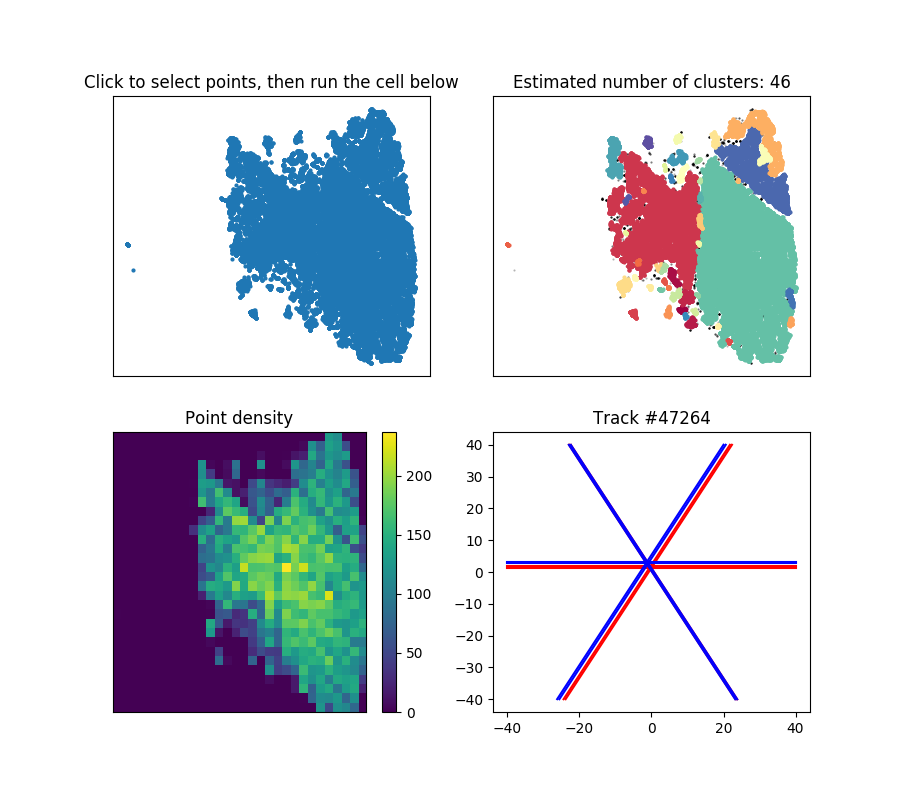

In [61]:
# Reset contents of temporary file used to store user input
with open('temp.txt', 'w') as f:
    f.write('')

subfig_dim = 4  # figure size setting
fig = plt.figure(figsize=(2.25 * subfig_dim, 2 * subfig_dim))

# Define callback to record when user clicks a point
def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    points = tuple(zip(xdata[ind], ydata[ind]))
    # Instead of printing to stdout, write to file
    with open('temp.txt', 'a') as f:
        f.write('\n' + str(list(ind)) + ', ' + str(points))
    # Plot one of the tracks the user clicked on
    ax4.cla()
    t = ind[np.random.randint(0, len(ind))]
    plt.title('Track #' + str(int(t)))
    for hit in g_tracks_2[int(t)]:
        line = shms.hit_to_2d(hit)
        ax4.plot(line[0], line[1], 'r')
    for hit in g_tracks_1[int(t)]:
        line = shms.hit_to_2d(hit)
        ax4.plot(line[0], line[1], 'b')

        
# Add plot of all the data
ax1 = plt.subplot(221)
plt.title('Click to select points, then run the cell below')
plt.xticks([])
plt.yticks([])
plt.plot(x, y, 'o', markersize=2, picker=2)  # I would use plt.scatter() but the callback doesn't seem to work if I do; it's very picky (see what I did there?)

# Attach callback to subplot
fig.canvas.mpl_connect('pick_event', onpick)


# Add plot of DBSCAN clusters
ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
plt.xticks([])
plt.yticks([])
num_clusters2d = len(set(dbscan_labels2d)) - (1 if -1 in dbscan_labels2d else 0)
unique_labels2d = set(dbscan_labels2d)
colors2d = np.array([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels2d))])
np.random.seed(20)
np.random.shuffle(colors2d)

for k, col in zip(unique_labels2d, colors2d):
    xy = g_embedded_tsne2d[:70000][dbscan_labels2d==k]
    if k == -1:
        plt.plot(xy[:, 0], xy[:, 1], 'o', color=(0, 0, 0, 0.3), markersize=0.5)
    else:
        plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col), markersize=2, zorder=10000)

plt.title('Estimated number of clusters: {}'.format(num_clusters2d))


# Add 2d histogram showing point density
ax3 = plt.subplot(223)#, sharex=ax1, sharey=ax1)
plt.title('Point density')
plt.xticks([])
plt.yticks([])
plt.hist2d(x_full, y_full, bins=30)
plt.colorbar()

# Add plot for the last-selected track
ax4 = plt.subplot(224)
plt.title('Selected track')


# Done
plt.show()

<IPython.core.display.Javascript object>


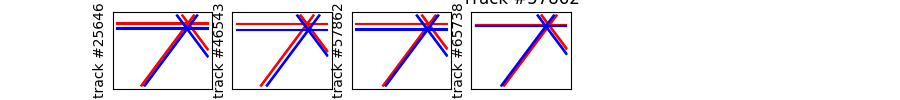

In [58]:
# Get points the user clicked on
indices, _ = last_click()

indices = indices[:np.minimum(len(indices), 100)]  # cap the number of points to keep render times manageable

subfig_dim = 1.5  # size of subfigures
fig_width = 9
fig = plt.figure( figsize=(fig_width, subfig_dim * len(indices) / (fig_width // subfig_dim)) )

for i, t in enumerate(indices):
    ax1 = plt.subplot(np.ceil(len(indices) / (fig_width // subfig_dim)),
                      (fig_width // subfig_dim), i+1)
    plt.ylabel('track #' + str(int(t)))
    plt.xticks([])
    plt.yticks([])
    for hit in g_tracks_2[int(t)]:
        line = shms.hit_to_2d(hit)
        plt.plot(line[0], line[1], 'r')
    for hit in g_tracks_1[int(t)]:
        line = shms.hit_to_2d(hit)
        plt.plot(line[0], line[1], 'b')

plt.show()

# 3D embedding

<IPython.core.display.Javascript object>


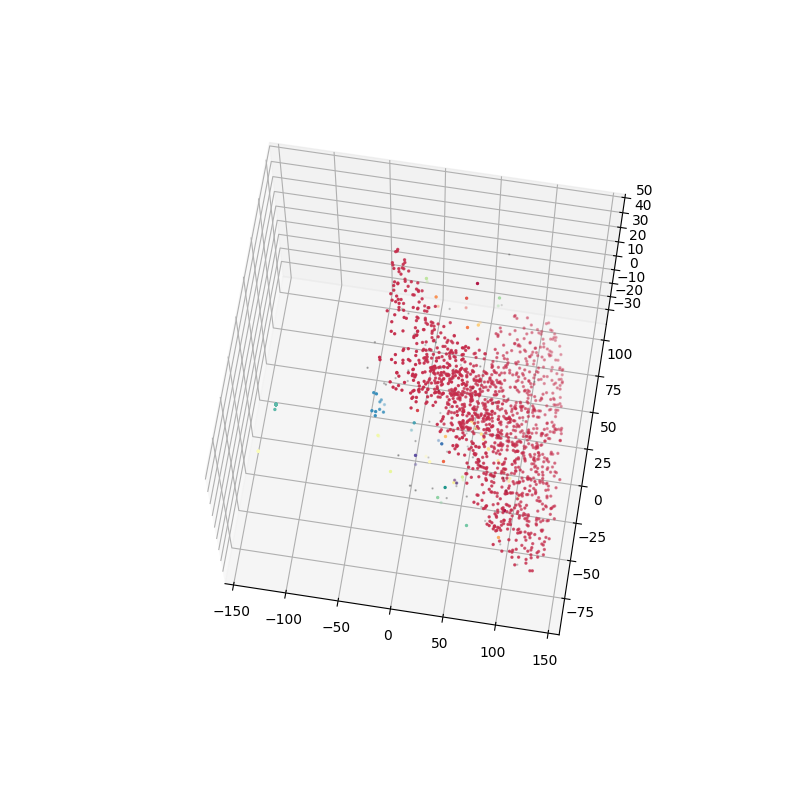

In [62]:
skip = round(10 ** 1.5)  # speed up rendering by only plotting some of the points

num_clusters3d = len(set(dbscan_labels3d)) - (1 if -1 in dbscan_labels3d else 0)
unique_labels3d = set(dbscan_labels3d)
colors3d = np.array([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels3d))])
np.random.seed(0)
np.random.shuffle(colors3d)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

for k, col in zip(unique_labels3d, colors3d):
    xyz = g_embedded_tsne3d[:70000][dbscan_labels3d==k][::skip]
    if k == -1:
        ax1.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=(0, 0, 0, 0.3), s=0.5)
    else:
        ax1.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=tuple(col), s=2)

Hopefully, this was a helpful introduction to scikit-learn, even though these experiments were not directly applicable to our problem of filtering the SHMS data with machine learning. As always, it is encouraged that you continue to explore the capabilities of these techniques before moving on to the next [notebook](SHMS%20Data%20Filtering.ipynb).